In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
import matplotlib.image as mpimg
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

In [2]:
mydata = pd.read_csv('C:/Users/Manas/Downloads/Bike-Sharing-Demand-Prediction-master (1)/Bike-Sharing-Demand-Prediction-master/Data/train.csv', parse_dates=True, index_col='datetime')
testdata = pd.read_csv('C:/Users/Manas/Downloads/Bike-Sharing-Demand-Prediction-master (1)/Bike-Sharing-Demand-Prediction-master/Data/test.csv', parse_dates=True, index_col='datetime')

In [3]:
print('Shape of data: ', mydata.shape)

Shape of data:  (10886, 11)


In [4]:
mydata.head(3)

season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2022-01-01 00:00:00       1        0           0        1  9.84  14.395   
2022-01-01 01:00:00       1        0           0        1  9.02  13.635   
2022-01-01 02:00:00       1        0           0        1  9.02  13.635   

                     humidity  windspeed  casual  registered  count  
datetime                                                             
2022-01-01 00:00:00        81        0.0       3          13     16  
2022-01-01 01:00:00        80        0.0       8          32     40  
2022-01-01 02:00:00        80        0.0       5          27     32

In [5]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2022-01-01 00:00:00 to 2023-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [6]:
mydata.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count  
count  10886.000000  
mean     191.574132  
std      181.144454  
min        1.000000  
25%       42.000000  
50%      145.000000  
75%      284.000000  
max      977.000000

In [7]:
print(mydata.index[[0, -1]]) # Range of time stamp

DatetimeIndex(['2022-01-01 00:00:00', '2023-12-19 23:00:00'], dtype='datetime64[ns]', name='datetime', freq=None)


In [8]:
print('Casual + Registered = Count? ', ~(mydata.casual + mydata.registered - mydata['count']).any())

Casual + Registered = Count?  True


In [9]:
category_list = ['season', 'holiday', 'workingday', 'weather']
for var in category_list:
    mydata[var] = mydata[var].astype('category')
    testdata[var] = testdata[var].astype('category')

In [10]:
season_dict = {1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
weather_dict = {1:'Clear', 2:'Misty+Cloudy', 3:'Light Snow/Rain', 4:'Heavy Snow/Rain'}
mydata['season'] = mydata['season'].map(season_dict)
mydata['weather'] = mydata['weather'].map(weather_dict)

testdata['season'] = testdata['season'].map(season_dict)
testdata['weather'] = testdata['weather'].map(weather_dict)

mydata.head(n=3)

season holiday workingday weather  temp   atemp  \
datetime                                                               
2022-01-01 00:00:00  Spring       0          0   Clear  9.84  14.395   
2022-01-01 01:00:00  Spring       0          0   Clear  9.02  13.635   
2022-01-01 02:00:00  Spring       0          0   Clear  9.02  13.635   

                     humidity  windspeed  casual  registered  count  
datetime                                                             
2022-01-01 00:00:00        81        0.0       3          13     16  
2022-01-01 01:00:00        80        0.0       8          32     40  
2022-01-01 02:00:00        80        0.0       5          27     32

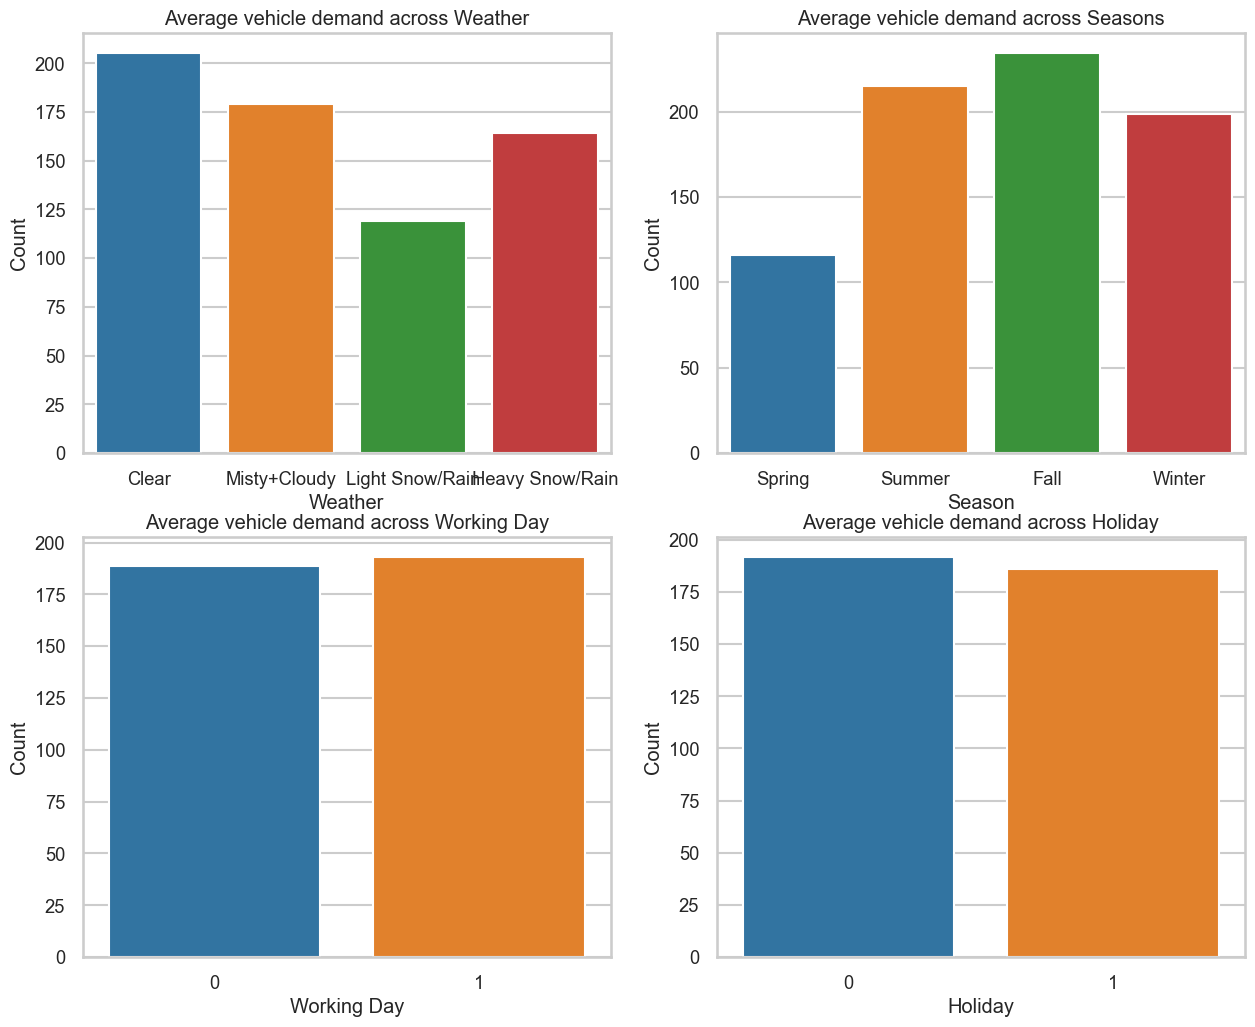

In [11]:
fig = plt.figure(figsize=(15, 12))
axes = fig.add_subplot(2, 2, 1)
group_weather = pd.DataFrame(mydata.groupby(['weather'])['count'].mean()).reset_index()
sns.barplot(data=group_weather, x='weather', y='count', ax=axes)
axes.set(xlabel='Weather', ylabel='Count', title='Average vehicle demand across Weather')

axes = fig.add_subplot(2, 2, 2)
group_season = pd.DataFrame(mydata.groupby(['season'])['count'].mean()).reset_index()
sns.barplot(data=group_season, x='season', y='count', ax=axes)
axes.set(xlabel='Season', ylabel='Count', title='Average vehicle demand across Seasons')

axes = fig.add_subplot(2, 2, 3)
group_workingday = pd.DataFrame(mydata.groupby(['workingday'])['count'].mean()).reset_index()
sns.barplot(data=group_workingday, x='workingday', y='count', ax=axes)
axes.set(xlabel='Working Day', ylabel='Count', title='Average vehicle demand across Working Day')

axes = fig.add_subplot(2, 2, 4)
group_season = pd.DataFrame(mydata.groupby(['holiday'])['count'].mean()).reset_index()
sns.barplot(data=group_season, x='holiday', y='count', ax=axes)
axes.set(xlabel='Holiday', ylabel='Count', title='Average vehicle demand across Holiday')
plt.show()

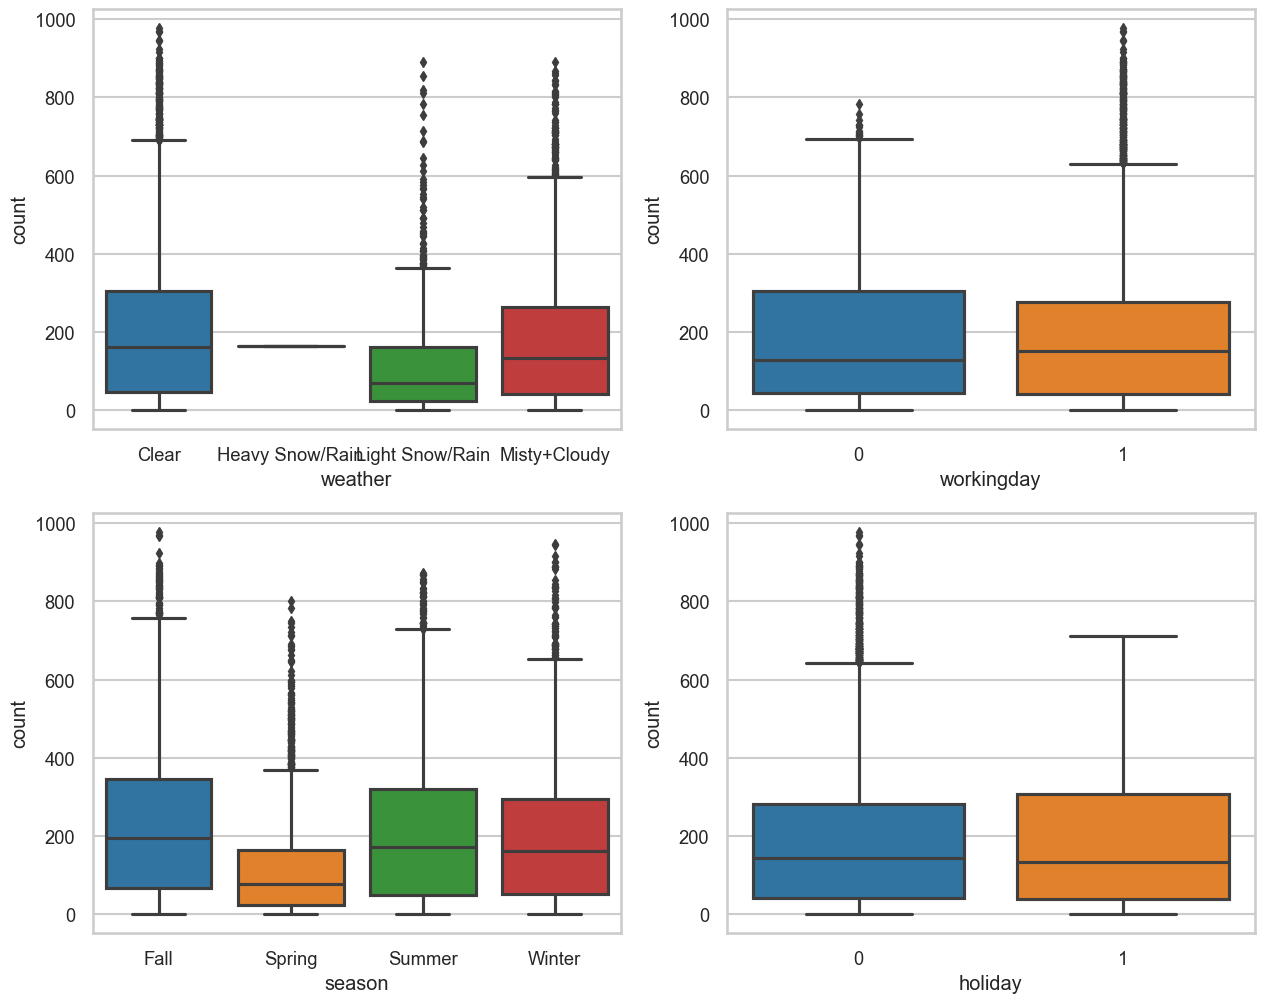

In [12]:
f, axes = plt.subplots(2, 2, figsize=(15, 12))
hue_order= ['Clear', 'Heavy Snow/Rain', 'Light Snow/Rain', 'Misty+Cloudy']
sns.boxplot(data=mydata, y='count', x='weather', ax=axes[0][0], order=hue_order)
sns.boxplot(data=mydata, y='count', x='workingday', ax=axes[0][1])
hue_order= ['Fall', 'Spring', 'Summer', 'Winter']
sns.boxplot(data=mydata, y='count', x='season', ax=axes[1][0], order=hue_order)
sns.boxplot(data=mydata, y='count', x='holiday', ax=axes[1][1])

plt.show()

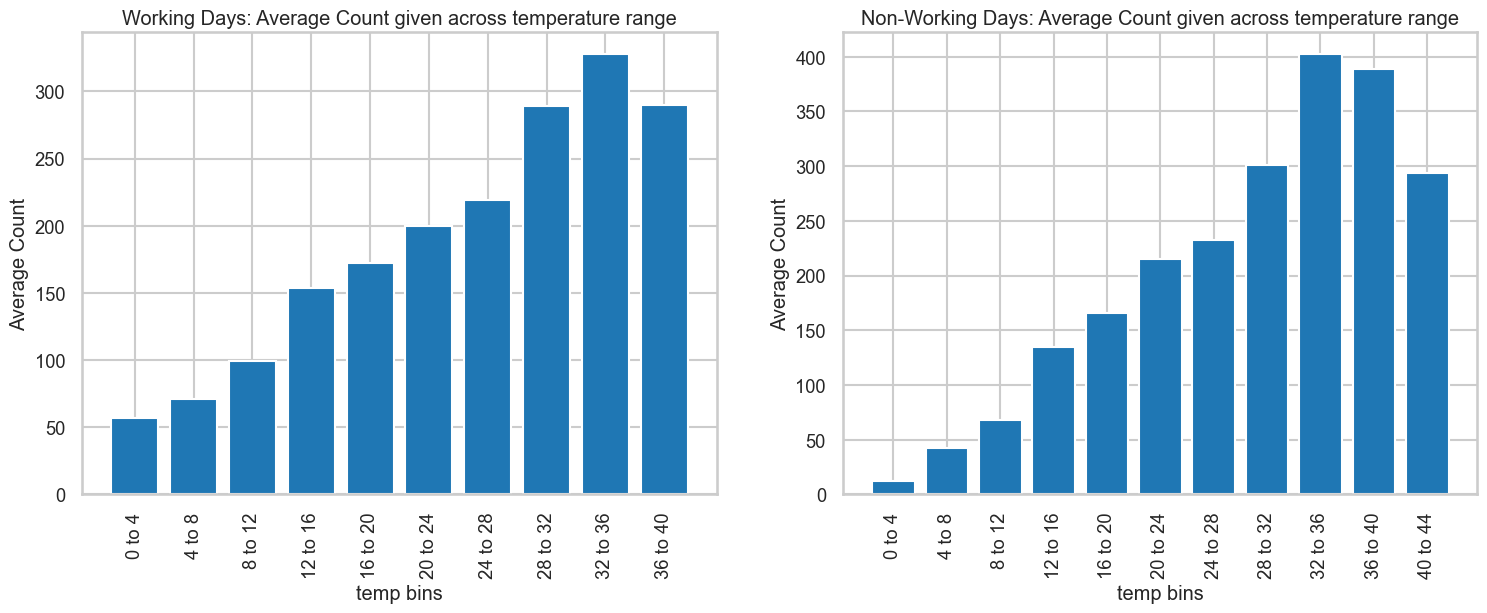

In [13]:
mydata_w = mydata[mydata.workingday==1]
mydata_nw = mydata[mydata.workingday==0]

bin_size = 4
mydata_w['temp_round'] = mydata_w['temp']//bin_size
mydata_nw['temp_round'] = mydata_nw['temp']//bin_size

mean_count_vs_temp_w = mydata_w.groupby('temp_round')['count'].mean()
mean_count_vs_temp_nw = mydata_nw.groupby('temp_round')['count'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Working Days: Average Count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Non-Working Days: Average Count given across temperature range')

plt.show()

<AxesSubplot: >

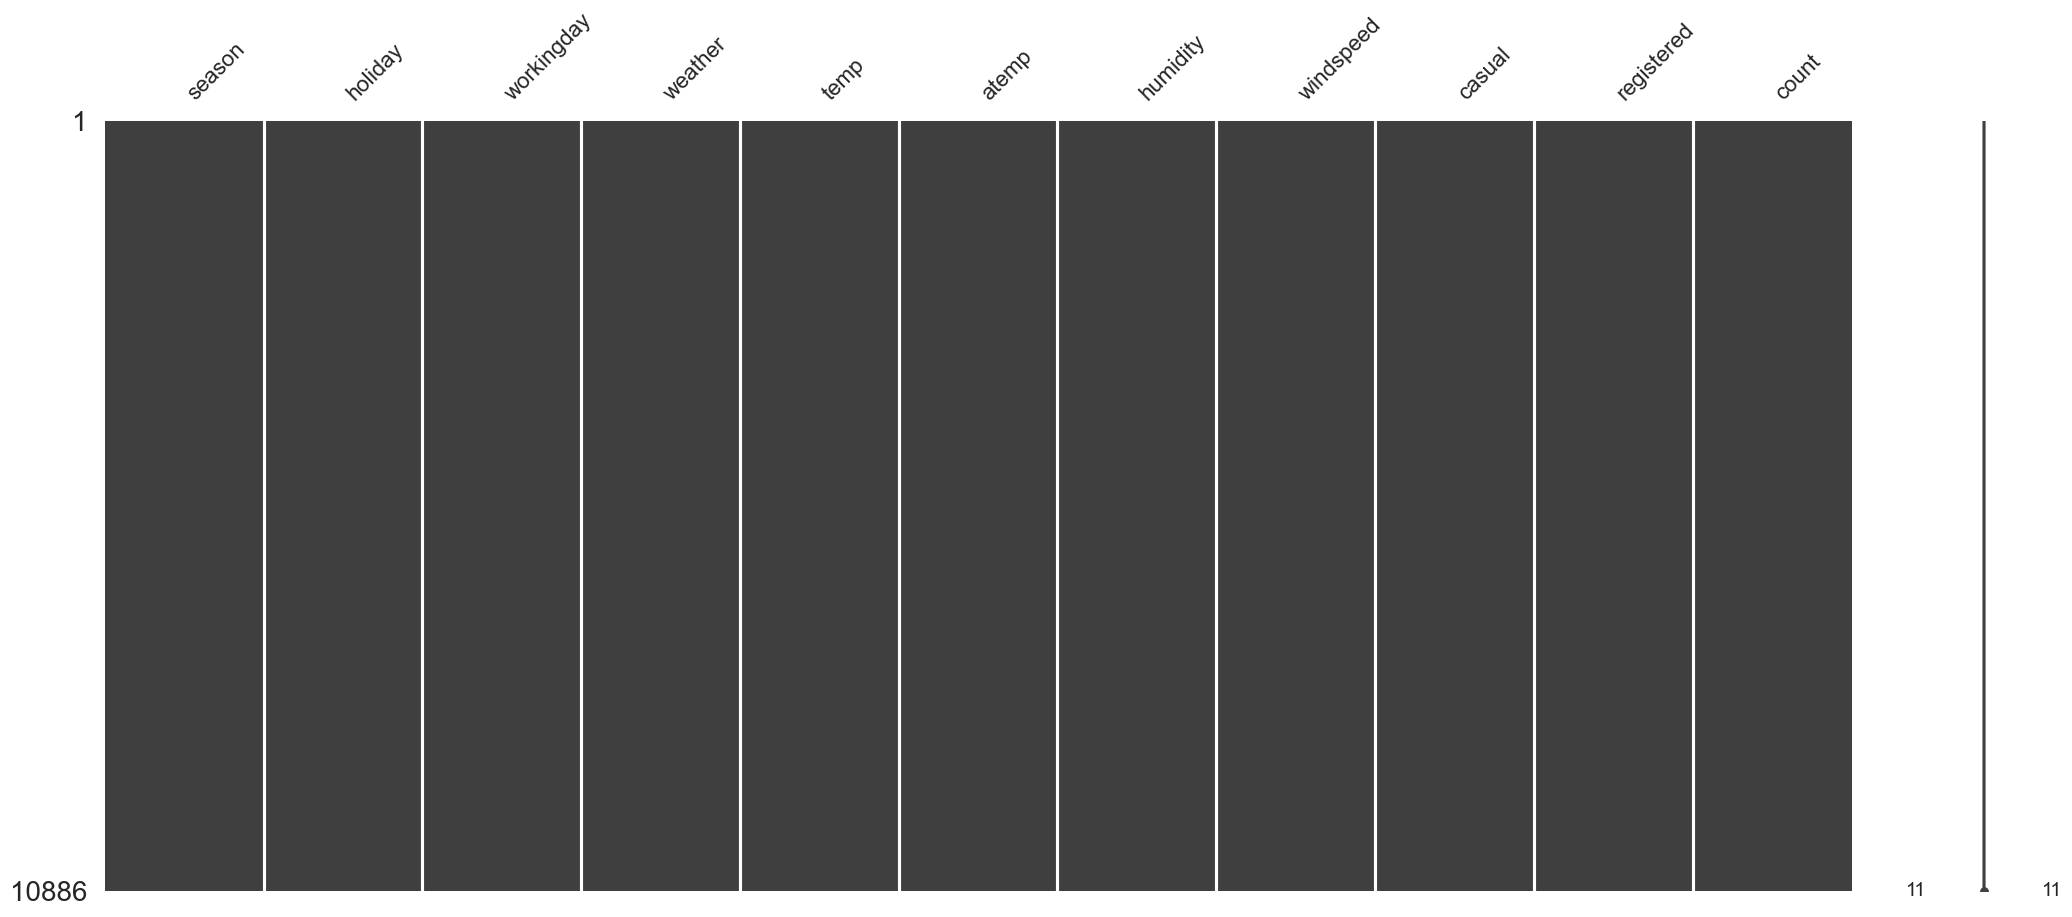

In [14]:
msno.matrix(mydata)

In [15]:
mydata.index = pd.to_datetime(mydata.index, errors='coerce')
testdata.index = pd.to_datetime(testdata.index, errors='coerce')

mydata = mydata[mydata.index.notna()]
testdata = testdata[testdata.index.notna()]

mydata['month'] = [x.month for x in mydata.index]
mydata['date'] = [x.day for x in mydata.index]
mydata['hour'] = [x.hour for x in mydata.index]
mydata['day'] = [x.weekday() for x in mydata.index]

testdata['month'] = [x.month for x in testdata.index]
testdata['date'] = [x.day for x in testdata.index]
testdata['hour'] = [x.hour for x in testdata.index]
testdata['day'] = [x.weekday() for x in testdata.index]

category_list = ['month', 'date', 'hour', 'day']
for var in category_list:
    mydata[var] = mydata[var].astype('category')
    testdata[var] = testdata[var].astype('category')

In [16]:
day_dict = {0:'Monday', 1:'Teusday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
mydata['day'] = mydata['day'].map(day_dict)
testdata['day'] = testdata['day'].map(day_dict)

mydata.head(n=3)

season holiday workingday weather  temp   atemp  \
datetime                                                               
2022-01-01 00:00:00  Spring       0          0   Clear  9.84  14.395   
2022-01-01 01:00:00  Spring       0          0   Clear  9.02  13.635   
2022-01-01 02:00:00  Spring       0          0   Clear  9.02  13.635   

                     humidity  windspeed  casual  registered  count month  \
datetime                                                                    
2022-01-01 00:00:00        81        0.0       3          13     16     1   
2022-01-01 01:00:00        80        0.0       8          32     40     1   
2022-01-01 02:00:00        80        0.0       5          27     32     1   

                    date hour       day  
datetime                                 
2022-01-01 00:00:00    1    0  Saturday  
2022-01-01 01:00:00    1    1  Saturday  
2022-01-01 02:00:00    1    2  Saturday

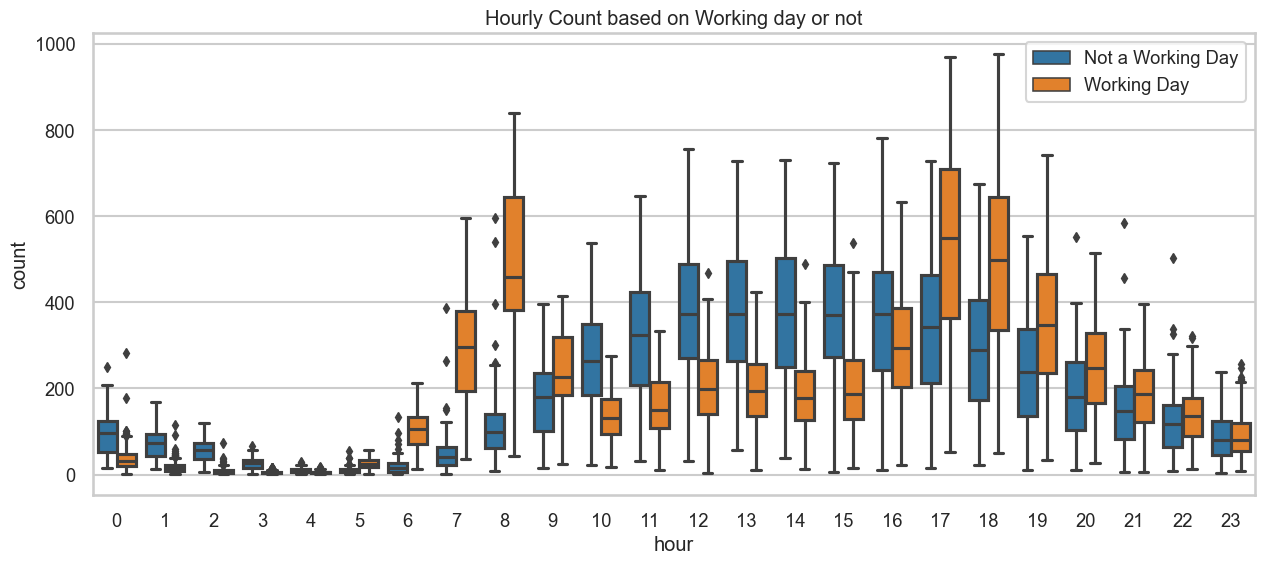

In [17]:
f, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.boxplot(data=mydata, y='count', x='hour', hue='workingday', ax=axes)
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
axes.set(title='Hourly Count based on Working day or not')

plt.show()

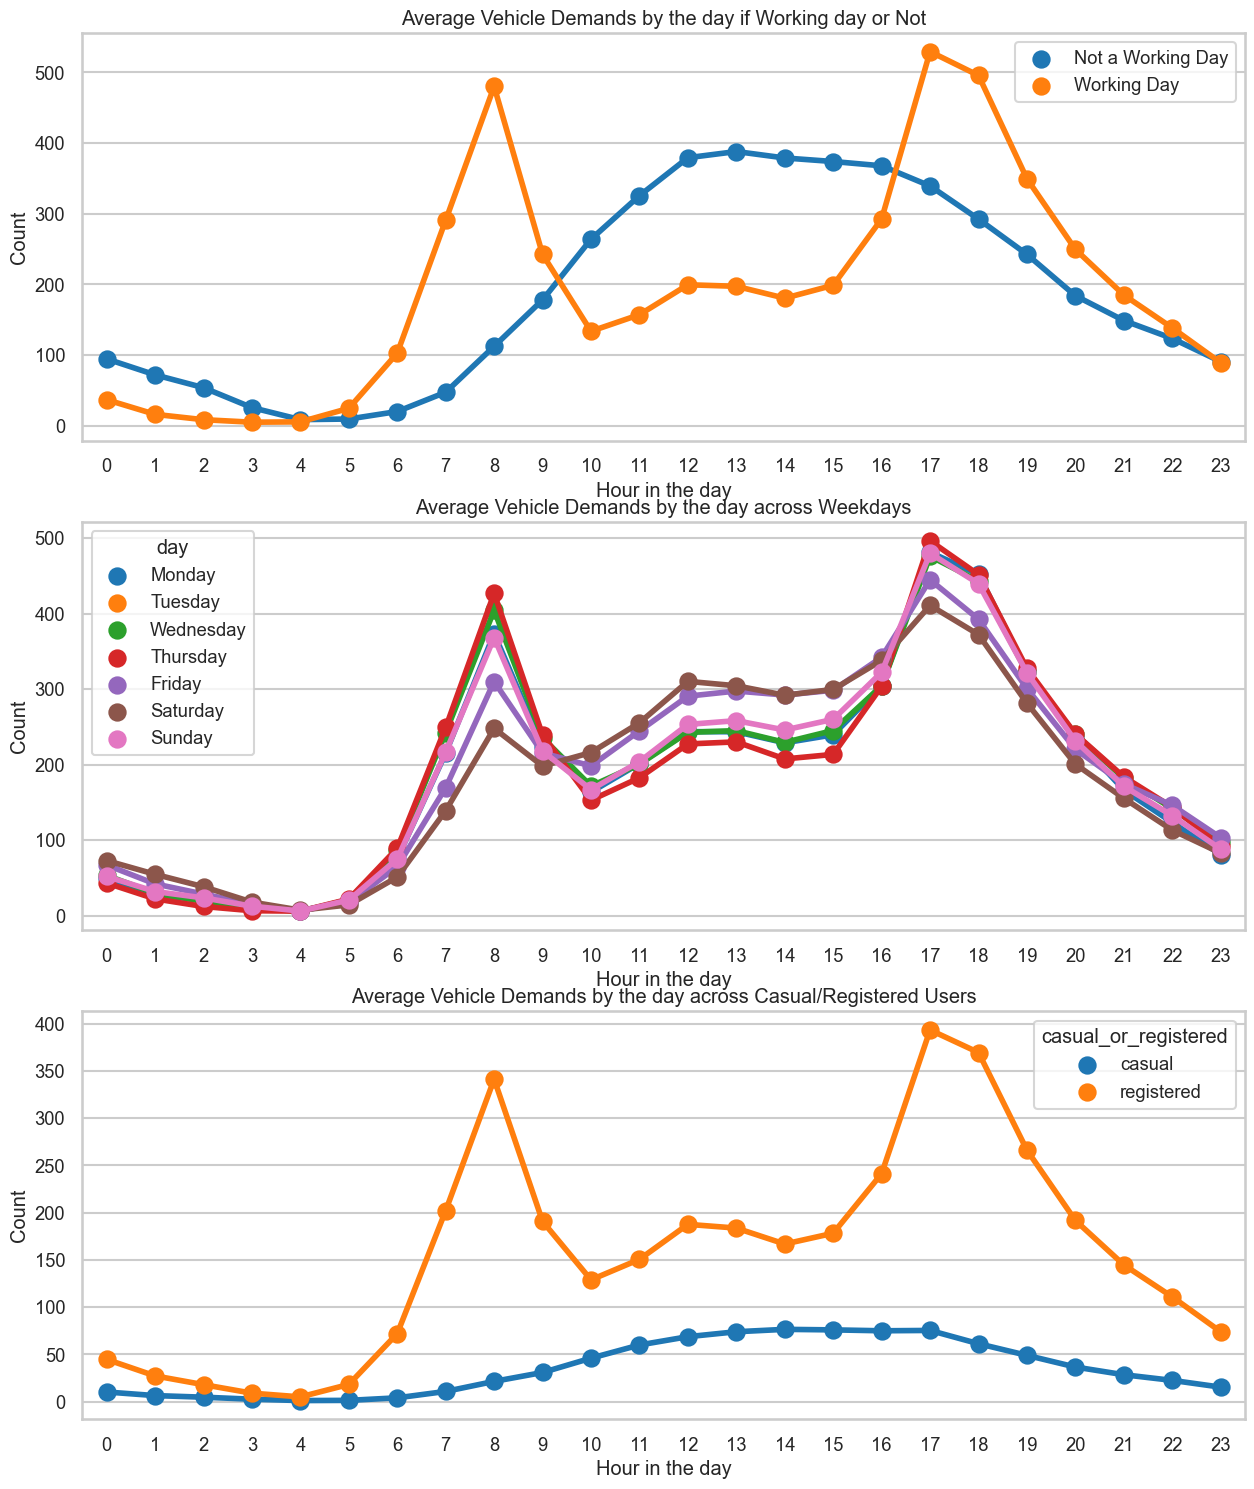

In [18]:
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))

group_work_hour = pd.DataFrame(mydata.groupby(['workingday', 'hour'])['count'].mean()).reset_index()
sns.pointplot(data=group_work_hour, x='hour', y='count', hue='workingday', ax=axes[0])
handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Not a Working Day', 'Working Day'])
axes[0].set(xlabel='Hour in the day', ylabel='Count', title='Average Vehicle Demands by the day if Working day or Not')

hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group_day_hour = pd.DataFrame(mydata.groupby(['day', 'hour'])['count'].mean()).reset_index()
sns.pointplot(data=group_day_hour, x='hour', y='count', hue='day', ax=axes[1], hue_order=hue_order)
axes[1].set(xlabel='Hour in the day', ylabel='Count', title='Average Vehicle Demands by the day across Weekdays')

df_melt = pd.melt(frame=mydata, id_vars='hour', value_vars=['casual', 'registered'], value_name='count', var_name='casual_or_registered')
group_casual_hour = pd.DataFrame(df_melt.groupby(['hour', 'casual_or_registered'])['count'].mean()).reset_index()
sns.pointplot(data=group_casual_hour, x='hour', y='count', hue='casual_or_registered', ax=axes[2])
axes[2].set(xlabel='Hour in the day', ylabel='Count', title='Average Vehicle Demands by the day across Casual/Registered Users')

plt.show()


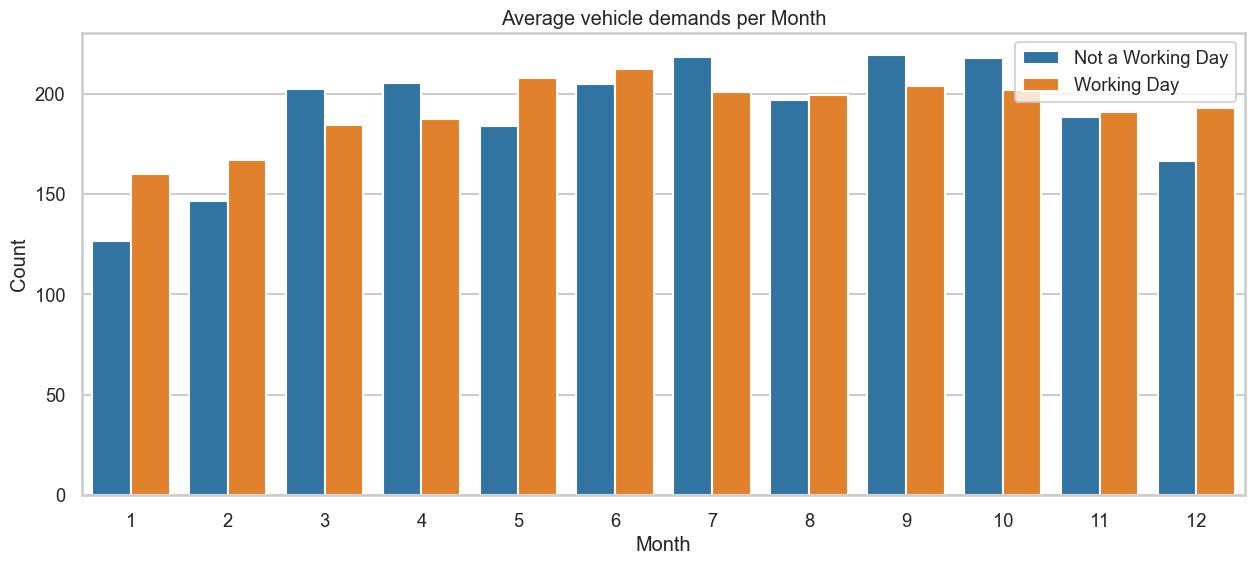

In [19]:
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
group_month = pd.DataFrame(mydata.groupby(['month', 'workingday'])['count'].mean()).reset_index()
sns.barplot(data=group_month, x='month', y='count', hue='workingday', ax=axes)
axes.set(xlabel='Month', ylabel='Count', title='Average vehicle demands per Month')
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
plt.show()

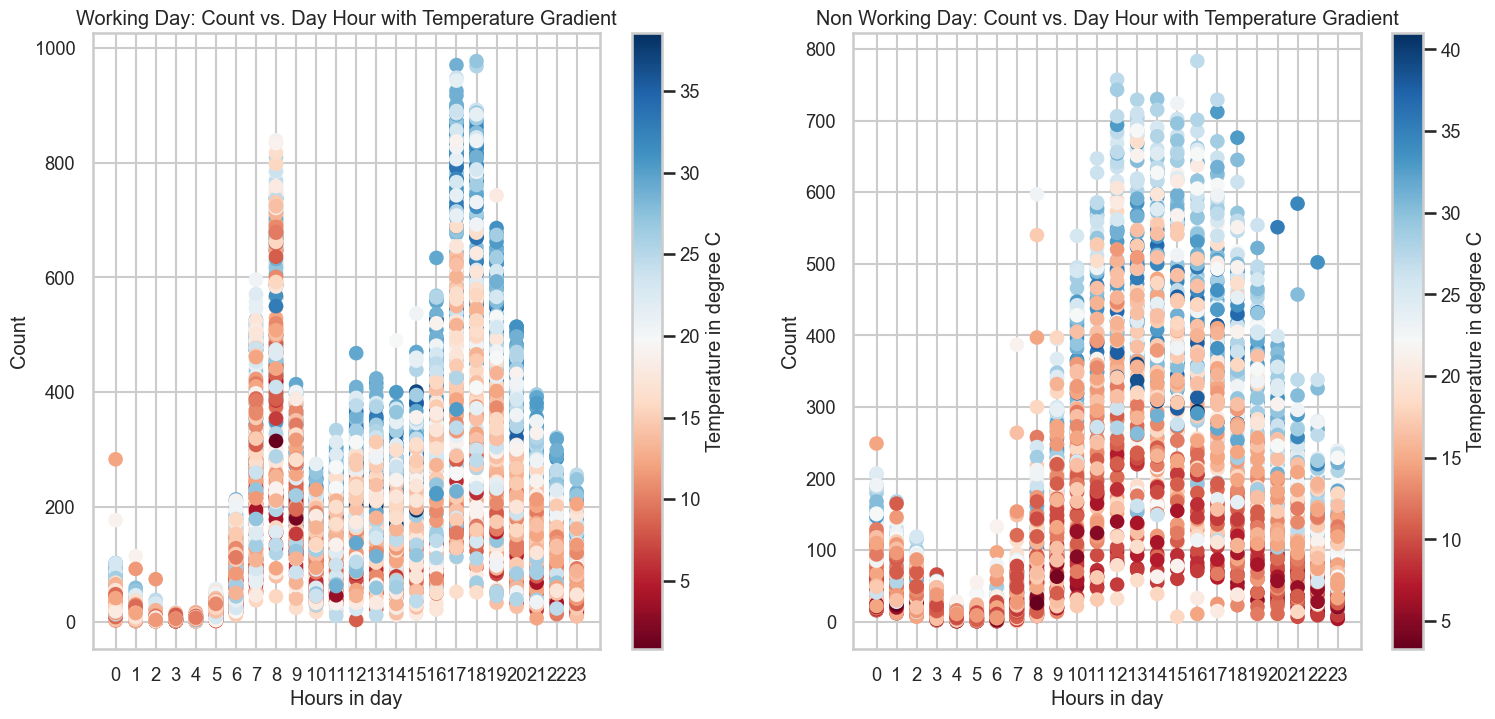

In [20]:
mydata_w = mydata[mydata.workingday==1]
mydata_nw = mydata[mydata.workingday==0]

fig = plt.figure(figsize=(18, 8))

axes = fig.add_subplot(1, 2, 1)
f = axes.scatter(mydata_w.hour, mydata_w['count'], c=mydata_w.temp, cmap = 'RdBu')
axes.set(xticks = range(24), xlabel='Hours in day', ylabel='Count', title='Working Day: Count vs. Day Hour with Temperature Gradient')
cbar = plt.colorbar(f)
cbar.set_label('Temperature in degree C')

axes = fig.add_subplot(1, 2, 2)
f = axes.scatter(mydata_nw.hour, mydata_nw['count'], c=mydata_nw.temp, cmap = 'RdBu')
axes.set(xticks = range(24), xlabel='Hours in day', ylabel='Count', title='Non Working Day: Count vs. Day Hour with Temperature Gradient')
cbar = plt.colorbar(f)
cbar.set_label('Temperature in degree C')

plt.show()

In [21]:
heavy_weather_data = mydata.loc[mydata['weather']=='Heavy Snow/Rain', :]
print(heavy_weather_data.index)
mydata['2023-01-09 08:00' : '2023-01-09 20:00']

DatetimeIndex(['2023-09-01 18:00:00'], dtype='datetime64[ns]', name='datetime', freq=None)


season holiday workingday          weather   temp   atemp  \
datetime                                                                        
2023-01-09 08:00:00   Fall       0          0     Misty+Cloudy  31.16  35.605   
2023-01-09 09:00:00   Fall       0          0     Misty+Cloudy  31.16  35.605   
2023-01-09 10:00:00   Fall       0          0     Misty+Cloudy  31.98  36.365   
2023-01-09 11:00:00   Fall       0          0     Misty+Cloudy  32.80  37.880   
2023-01-09 12:00:00   Fall       0          0     Misty+Cloudy  32.80  37.880   
2023-01-09 13:00:00   Fall       0          0     Misty+Cloudy  33.62  38.635   
2023-01-09 14:00:00   Fall       0          0     Misty+Cloudy  35.26  39.395   
2023-01-09 15:00:00   Fall       0          0     Misty+Cloudy  35.26  39.395   
2023-01-09 16:00:00   Fall       0          0     Misty+Cloudy  34.44  39.395   
2023-01-09 17:00:00   Fall       0          0     Misty+Cloudy  33.62  38.635   
2023-01-09 18:00:00   Fall       0          0     Misty+Cloudy  33.62  38.635   
2023-01-09 19:00:00   Fall       0          0  Light Snow/Rain  31.98  37.120   
2023-01-09 20:00:00   Fall       0          0  Light Snow/Rain  31.16  36.365   

                     humidity  windspeed  casual  registered  count month  \
datetime                                                                    
2023-01-09 08:00:00        58    16.9979      28         134    162     1   
2023-01-09 09:00:00        58    12.9980      62         175    237     1   
2023-01-09 10:00:00        55    12.9980     128         289    417     1   
2023-01-09 11:00:00        55    15.0013     219         273    492     1   
2023-01-09 12:00:00        55    11.0014     187         284    471     1   
2023-01-09 13:00:00        52     6.0032     237         267    504     1   
2023-01-09 14:00:00        44    11.0014     240         274    514     1   
2023-01-09 15:00:00        44    19.0012     257         306    563     1   
2023-01-09 16:00:00        49    11.0014     209         253    462     1   
2023-01-09 17:00:00        52     0.0000     205         258    463     1   
2023-01-09 18:00:00        52     0.0000     184         258    442     1   
2023-01-09 19:00:00        62     0.0000     157         235    392     1   
2023-01-09 20:00:00        67    16.9979      67         140    207     1   

                    date hour     day  
datetime                               
2023-01-09 08:00:00    9    8  Monday  
2023-01-09 09:00:00    9    9  Monday  
2023-01-09 10:00:00    9   10  Monday  
2023-01-09 11:00:00    9   11  Monday  
2023-01-09 12:00:00    9   12  Monday  
2023-01-09 13:00:00    9   13  Monday  
2023-01-09 14:00:00    9   14  Monday  
2023-01-09 15:00:00    9   15  Monday  
2023-01-09 16:00:00    9   16  Monday  
2023-01-09 17:00:00    9   17  Monday  
2023-01-09 18:00:00    9   18  Monday  
2023-01-09 19:00:00    9   19  Monday  
2023-01-09 20:00:00    9   20  Monday

In [22]:
mydata.loc[mydata['weather']=='Heavy Snow/Rain', 'weather'] = 'Light Snow/Rain'
testdata.loc[testdata['weather']=='Heavy Snow/Rain', 'weather'] = 'Light Snow/Rain'

mydata['2023-01-09 18:00' : '2023-01-09 18:00']

season holiday workingday       weather   temp   atemp  \
datetime                                                                     
2023-01-09 18:00:00   Fall       0          0  Misty+Cloudy  33.62  38.635   

                     humidity  windspeed  casual  registered  count month  \
datetime                                                                    
2023-01-09 18:00:00        52        0.0     184         258    442     1   

                    date hour     day  
datetime                               
2023-01-09 18:00:00    9   18  Monday

In [23]:
def zscore(series): 
    return (series-series.mean())/series.std()

mydata['count_zscore'] = mydata.groupby(['hour', 'workingday'])['count'].transform(zscore)
outlier_idx = np.abs(mydata['count_zscore'])>4
outlier_data = mydata.loc[outlier_idx, :]
print('Shape of the outlier data entries: ', outlier_data.shape)
outlier_data

Shape of the outlier data entries:  (15, 16)


season holiday workingday       weather   temp   atemp  \
datetime                                                                      
2022-02-05 00:00:00  Summer       0          1         Clear  18.86  22.725   
2022-02-05 01:00:00  Summer       0          1         Clear  18.86  22.725   
2022-07-15 02:00:00    Fall       0          1         Clear  24.60  28.790   
2023-01-04 06:00:00  Summer       0          0  Misty+Cloudy  14.76  17.425   
2023-04-16 06:00:00  Summer       1          0         Clear  21.32  25.000   
2023-04-16 07:00:00  Summer       1          0         Clear  21.32  25.000   
2023-04-16 08:00:00  Summer       1          0  Misty+Cloudy  22.96  26.515   
2023-04-07 21:00:00    Fall       1          0         Clear  34.44  40.150   
2023-04-07 22:00:00    Fall       1          0         Clear  33.62  39.395   
2023-09-09 05:00:00    Fall       0          0         Clear  21.32  25.000   
2023-07-11 00:00:00  Winter       0          1  Misty+Cloudy  12.30  14.395   
2023-07-11 01:00:00  Winter       0          1  Misty+Cloudy  11.48  13.635   
2023-07-11 02:00:00  Winter       0          1  Misty+Cloudy  11.48  12.880   
2023-12-11 07:00:00  Winter       1          0         Clear  16.40  20.455   
2023-12-11 08:00:00  Winter       1          0         Clear  17.22  21.210   

                     humidity  windspeed  casual  registered  count month  \
datetime                                                                    
2022-02-05 00:00:00        72     8.9981      68         109    177     2   
2022-02-05 01:00:00        72     8.9981      41          73    114     2   
2022-07-15 02:00:00        78    11.0014      16          22     38     7   
2023-01-04 06:00:00        76     8.9981       9          88     97     1   
2023-04-16 06:00:00        83    11.0014      10         123    133     4   
2023-04-16 07:00:00        83     8.9981      20         367    387     4   
2023-04-16 08:00:00        83    11.0014      48         549    597     4   
2023-04-07 21:00:00        53     8.9981     222         362    584     4   
2023-04-07 22:00:00        56    15.0013     175         327    502     4   
2023-09-09 05:00:00        77    12.9980      16          39     55     9   
2023-07-11 00:00:00        56    19.0012      49         234    283     7   
2023-07-11 01:00:00        61    16.9979       6          86     92     7   
2023-07-11 02:00:00        56    19.9995       6          68     74     7   
2023-12-11 07:00:00        87     0.0000      16         248    264    12   
2023-12-11 08:00:00        82    11.0014      50         490    540    12   

                    date hour        day  count_zscore  
datetime                                                
2022-02-05 00:00:00    5    0   Saturday      5.328782  
2022-02-05 01:00:00    5    1   Saturday      7.899886  
2022-07-15 02:00:00   15    2     Friday      4.248737  
2023-01-04 06:00:00    4    6  Wednesday      4.227851  
2023-04-16 06:00:00   16    6     Sunday      6.204331  
2023-04-16 07:00:00   16    7     Sunday      7.784914  
2023-04-16 08:00:00   16    8     Sunday      5.864166  
2023-04-07 21:00:00    7   21     Friday      4.970624  
2023-04-07 22:00:00    7   22     Friday      5.022732  
2023-09-09 05:00:00    9    5   Saturday      6.062216  
2023-07-11 00:00:00   11    0    Teusday      9.355729  
2023-07-11 01:00:00   11    1    Teusday      6.126384  
2023-07-11 02:00:00   11    2    Teusday      9.422423  
2023-12-11 07:00:00   11    7     Monday      4.966377  
2023-12-11 08:00:00   11    8     Monday      5.174612

In [24]:
mydata_without_outliers = mydata.loc[~outlier_idx, :]
print('Shape of data before outliner pruning: ', mydata.shape)
print('Shape of data after outlier pruning: ', mydata_without_outliers.shape)

Shape of data before outliner pruning:  (10886, 16)
Shape of data after outlier pruning:  (10871, 16)


In [25]:
mydata_without_outliers = mydata_without_outliers.drop('count_zscore', axis=1)
mydata_without_outliers.head(n=3)

season holiday workingday weather  temp   atemp  \
datetime                                                               
2022-01-01 00:00:00  Spring       0          0   Clear  9.84  14.395   
2022-01-01 01:00:00  Spring       0          0   Clear  9.02  13.635   
2022-01-01 02:00:00  Spring       0          0   Clear  9.02  13.635   

                     humidity  windspeed  casual  registered  count month  \
datetime                                                                    
2022-01-01 00:00:00        81        0.0       3          13     16     1   
2022-01-01 01:00:00        80        0.0       8          32     40     1   
2022-01-01 02:00:00        80        0.0       5          27     32     1   

                    date hour       day  
datetime                                 
2022-01-01 00:00:00    1    0  Saturday  
2022-01-01 01:00:00    1    1  Saturday  
2022-01-01 02:00:00    1    2  Saturday

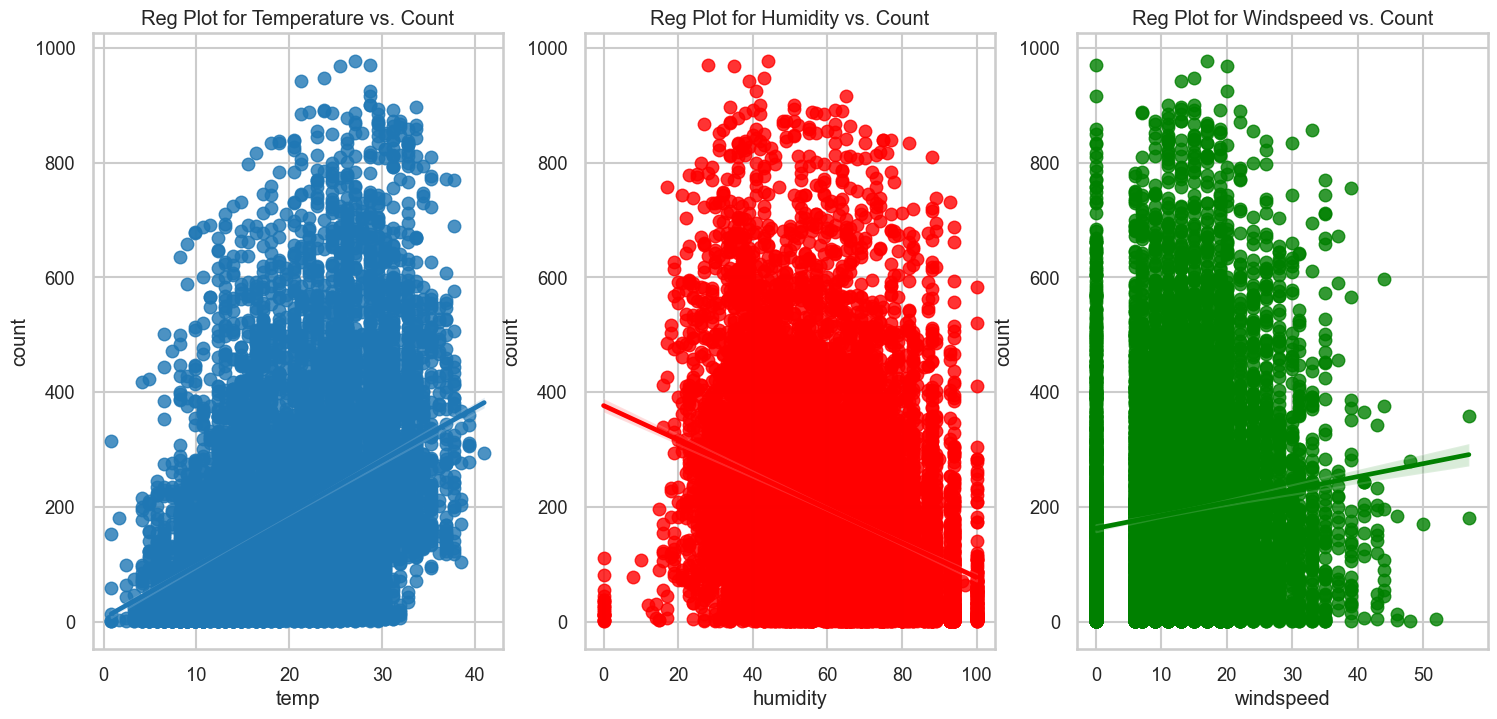

In [26]:
fig = plt.figure(figsize=(18, 8))
axes = fig.add_subplot(1, 3, 1)
sns.regplot(data=mydata_without_outliers, x='temp', y='count',ax=axes)
axes.set(title='Reg Plot for Temperature vs. Count')
axes = fig.add_subplot(1, 3, 2)
sns.regplot(data=mydata_without_outliers, x='humidity', y='count',ax=axes, color='r')
axes.set(title='Reg Plot for Humidity vs. Count')
axes = fig.add_subplot(1, 3, 3)
sns.regplot(data=mydata_without_outliers, x='windspeed', y='count',ax=axes, color='g')
axes.set(title='Reg Plot for Windspeed vs. Count')
plt.show()

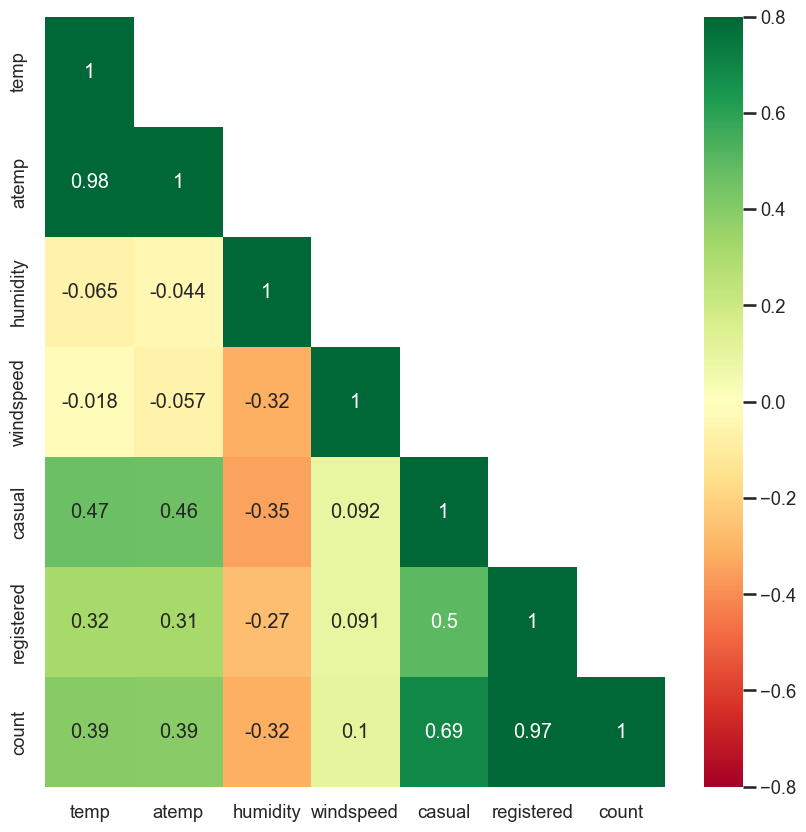

In [27]:
corr_matrix = mydata_without_outliers.corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

fig = plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cbar=True, vmax=0.8, vmin=-0.8, cmap='RdYlGn')
plt.show()

In [28]:
season_inv_dict = {'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4}
weather_inv_dict = {'Clear':1, 'Misty+Cloudy':2, 'Light Snow/Rain':3, 'Heavy Snow/Rain':4}
day_inv_dict = {'Monday':0, 'Teusday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}

mydata_without_outliers['season'] = mydata_without_outliers['season'].map(season_inv_dict)
mydata_without_outliers['weather'] = mydata_without_outliers['weather'].map(weather_inv_dict)
mydata_without_outliers['day'] = mydata_without_outliers['day'].map(day_inv_dict)

testdata['season'] = testdata['season'].map(season_inv_dict)
testdata['weather'] = testdata['weather'].map(weather_inv_dict)
testdata['day'] = testdata['day'].map(day_inv_dict)

drop_columns_1 = ['season', 'holiday', 'atemp', 'windspeed', 'date', 'day']
mydata_without_outliers = mydata_without_outliers.drop(drop_columns_1, axis=1)
testdata = testdata.drop(drop_columns_1, axis=1)
mydata_without_outliers.head(n=3)

workingday weather  temp  humidity  casual  registered  \
datetime                                                                     
2022-01-01 00:00:00          0       1  9.84        81       3          13   
2022-01-01 01:00:00          0       1  9.02        80       8          32   
2022-01-01 02:00:00          0       1  9.02        80       5          27   

                     count month hour  
datetime                               
2022-01-01 00:00:00     16     1    0  
2022-01-01 01:00:00     40     1    1  
2022-01-01 02:00:00     32     1    2

In [29]:
month=pd.get_dummies(mydata_without_outliers['month'], prefix='month')
weather=pd.get_dummies(mydata_without_outliers['weather'], prefix='weather')
hour=pd.get_dummies(mydata_without_outliers['hour'], prefix='hour')
mydata_train=pd.concat([mydata_without_outliers, weather, month, hour],axis=1)

month=pd.get_dummies(testdata['month'], prefix='month')
weather=pd.get_dummies(testdata['weather'], prefix='weather')
hour=pd.get_dummies(testdata['hour'], prefix='hour')
mydata_test=pd.concat([testdata, weather, month, hour],axis=1)

mydata_train.columns

Index(['workingday', 'weather', 'temp', 'humidity', 'casual', 'registered',
       'count', 'month', 'hour', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [30]:
drop_columns_2 = ['weather', 'month', 'hour', 'weather_3', 'month_12', 'hour_23']

mydata_train = mydata_train.drop(drop_columns_2+['casual', 'registered'], axis=1)
mydata_test = mydata_test.drop(drop_columns_2, axis=1)
mydata_without_outliers = mydata_without_outliers.drop(['casual', 'registered'], axis=1)

mydata_train.columns

Index(['workingday', 'temp', 'humidity', 'count', 'weather_1', 'weather_2',
       'weather_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22'],
      dtype='object')

In [31]:
model_train, model_test = mydata_train[mydata_train.index.day<15], mydata_train[mydata_train.index.day>=15]
model_train2, model_test2 = mydata_without_outliers[mydata_without_outliers.index.day<15], mydata_without_outliers[mydata_without_outliers.index.day>=15]
 
model_train_w = model_train[model_train['workingday']==1]
model_train_nw = model_train[model_train['workingday']==0]
model_train2_w = model_train2[model_train2['workingday']==1]
model_train2_nw = model_train2[model_train2['workingday']==0]

model_test_w = model_test[model_test['workingday']==1]
model_test_nw = model_test[model_test['workingday']==0]
model_test2_w = model_test2[model_test2['workingday']==1]
model_test2_nw = model_test2[model_test2['workingday']==0]
 
model_train_w = model_train_w.drop('workingday', axis=1)
model_train_nw = model_train_nw.drop('workingday', axis=1)
model_train2_w = model_train2_w.drop('workingday', axis=1)
model_train2_nw = model_train2_nw.drop('workingday', axis=1)

model_test_w = model_test_w.drop('workingday', axis=1)
model_test_nw = model_test_nw.drop('workingday', axis=1)
model_test2_w = model_test2_w.drop('workingday', axis=1)
model_test2_nw = model_test2_nw.drop('workingday', axis=1)

In [32]:
X, X_w, X_nw = model_train.drop('count', axis=1), model_train_w.drop('count', axis=1), model_train_nw.drop('count', axis=1)
y, y_w, y_nw = model_train['count'], model_train_w['count'], model_train_nw['count']
logy, logy_w, logy_nw = np.log1p(y), np.log1p(y_w), np.log1p(y_nw)

Xtest, Xtest_w, Xtest_nw = model_test.drop('count', axis=1), model_test_w.drop('count', axis=1), model_test_nw.drop('count', axis=1)
ytest, ytest_w, ytest_nw = model_test['count'], model_test_w['count'], model_test_nw['count']
logytest, logytest_w, logytest_nw = np.log1p(y), np.log1p(y_w), np.log1p(y_nw)

X2, X2_w, X2_nw = model_train2.drop('count', axis=1), model_train2_w.drop('count', axis=1), model_train2_nw.drop('count', axis=1)
y2, y2_w, y2_nw = model_train2['count'], model_train2_w['count'], model_train2_nw['count']
logy2, logy2_w, logy2_nw = np.log1p(y2), np.log1p(y2_w), np.log1p(y2_nw)

Xtest2, Xtest2_w, Xtest2_nw = model_test2.drop('count', axis=1), model_test2_w.drop('count', axis=1), model_test2_nw.drop('count', axis=1)
ytest2, ytest2_w, ytest2_nw = model_test2['count'], model_test2_w['count'], model_test2_nw['count']
logytest2, logytest2_w, logytest2_nw = np.log1p(y), np.log1p(y_w), np.log1p(y_nw)

algo_score = pd.DataFrame()
algo_score.index.name = 'Modelling Algo'
algo_score['Train RMSLE (Working Day)'] = None
algo_score['Train RMSLE (Non Working Day)'] = None
algo_score['Train RMSLE (Average)'] = None
algo_score['Test RMSLE (Working Day)'] = None
algo_score['Test RMSLE (Non Working Day)'] = None
algo_score['Test RMSLE (Average)'] = None
algo_score['Validation RMSLE (Working Day)'] = None
algo_score['Validation RMSLE (Non Working Day)'] = None
algo_score['Validation RMSLE (Average)'] = None
algo_score['Hyperparameters-Working'] = None
algo_score['Hyperparameters-Non Working'] = None
algo_score['Training+Test Time (sec)'] = None
cv_time = []

ypred_train = pd.DataFrame(index = X.index)
ypred_test = pd.DataFrame(index = Xtest.index)
ypred_train['count'], ypred_test['count'] = y, ytest 

In [33]:
from sklearn.metrics import make_scorer

def rmsle(y_actual, y_pred):
    log1 = np.nan_to_num(np.array([np.log1p(v) for v in y_pred]))
    log2 = np.nan_to_num(np.array([np.log1p(v) for v in y_actual]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

def rmsle_log(logy_actual, logy_pred):
    calc = (logy_actual - logy_pred) ** 2
    return np.sqrt(np.mean(calc))
rmsle_cv = make_scorer(rmsle_log, greater_is_better=False)


In [34]:
def plot_true_vs_pred (y_w_actual, y_nw_actual, y_w_pred, y_nw_pred, algo, t_from, t_to):
    fig = plt.figure(figsize=(18, 16))
    
    axes = fig.add_subplot(2, 1, 1)
    axes.plot(y_w_actual[t_from:t_to], label='Actual', marker='.', markersize=15)
    axes.plot(y_w_pred[t_from:t_to], label='Predicted', marker='.', markersize=15)
    axes.set(xlabel='Time', ylabel='Count', title='{0} Model for Working Day: Count between time {1} and {2}'.format(algo, t_from, t_to))
    axes.legend()

    axes = fig.add_subplot(2, 1, 2)
    axes.plot(y_nw_actual[t_from:t_to], label='Actual', marker='.', markersize=15)
    axes.plot(y_nw_pred[t_from:t_to], label='Predicted', marker='.', markersize=15)
    axes.set(xlabel='Time', ylabel='Count', title='{0} Model for Non Working Day: Count between time {1} and {2}'.format(algo, t_from, t_to))
    axes.legend()
    plt.show()

In [35]:
def model_fit (model_w, X_tr_w, X_t_w, y_tr_w, y_t_w, model_nw=None, X_tr_nw=None, X_t_nw=None, y_tr_nw=None, y_t_nw=None):
    
    model_w.fit(X_tr_w, np.log1p(y_tr_w))
    logy_tr_w_predict = model_w.predict(X_tr_w)
    logy_t_w_predict = model_w.predict(X_t_w)
    
    y_tr_w_predict = np.expm1(logy_tr_w_predict)
    y_t_w_predict = np.expm1(logy_t_w_predict)
    
    rmsle_w_tr = rmsle(y_tr_w, y_tr_w_predict)
    rmsle_w_t = rmsle(y_t_w, y_t_w_predict)
    
    if model_nw is None:
        [rmsle_avg_tr, rmsle_avg_t] = [rmsle_w_tr, rmsle_w_t] 
        rmsle_w_tr = rmsle(y_tr_w[X_tr_w.workingday==1], y_tr_w_predict[X_tr_w.workingday==1])
        rmsle_nw_tr = rmsle(y_tr_w[X_tr_w.workingday==0], y_tr_w_predict[X_tr_w.workingday==0])
        rmsle_w_t = rmsle(y_t_w[X_t_w.workingday==1], y_t_w_predict[X_t_w.workingday==1])
        rmsle_nw_t = rmsle(y_t_w[X_t_w.workingday==0], y_t_w_predict[X_t_w.workingday==0])
        y_tr_nw_predict, y_t_nw_predict = None, None
    else:
        model_nw.fit(X_tr_nw, np.log1p(y_tr_nw))
        logy_tr_nw_predict = model_nw.predict(X_tr_nw)
        logy_t_nw_predict = model_nw.predict(X_t_nw)

        y_tr_nw_predict = np.expm1(logy_tr_nw_predict)
        y_t_nw_predict = np.expm1(logy_t_nw_predict)

        rmsle_nw_tr = rmsle(y_tr_nw, y_tr_nw_predict)
        rmsle_nw_t = rmsle(y_t_nw, y_t_nw_predict)

        [rmsle_avg_tr, rmsle_avg_t] = [rmsle(np.concatenate([y_tr_w, y_tr_nw]), np.concatenate([y_tr_w_predict, y_tr_nw_predict])), 
                                       rmsle(np.concatenate([y_t_w, y_t_nw]), np.concatenate([y_t_w_predict, y_t_nw_predict]))]
    
    rmsle_all = [rmsle_w_tr, rmsle_nw_tr, rmsle_avg_tr, rmsle_w_t, rmsle_nw_t, rmsle_avg_t]
    y_pred_all = [y_tr_w_predict, y_t_w_predict, y_tr_nw_predict, y_t_nw_predict]
    
    return(rmsle_all, y_pred_all)
    

In [36]:
def cross_val(model_w, X_in_w, y_in_w, model_nw=None, X_in_nw=None, y_in_nw=None, cv=5):
    y_val_pred_w = pd.Series(index=y_in_w.index)
    y_val_pred_nw = None if model_nw == None else pd.Series(index=y_in_nw.index)
    for idx in range(cv):
        from_, to_ = idx*15/cv, (idx+1)*15/cv
        
        val_idx_w = (X_in_w.index.day>from_) & (X_in_w.index.day<=to_)
        train_idx_w = ~val_idx_w
        
        X_idx_w, y_idx_w, X_val_idx_w = X_in_w[train_idx_w], y_in_w[train_idx_w], X_in_w[val_idx_w]
        model_w.fit(X_idx_w, np.log1p(y_idx_w))
        logy_val_pred_idx_w = model_w.predict(X_val_idx_w)
        y_val_pred_w[val_idx_w] = np.expm1(logy_val_pred_idx_w)
        
        if model_nw is not None:
            val_idx_nw = (X_in_nw.index.day>from_) & (X_in_nw.index.day<=to_)
            train_idx_nw = ~val_idx_nw
            
            X_idx_nw, y_idx_nw, X_val_idx_nw = X_in_nw[train_idx_nw], y_in_nw[train_idx_nw], X_in_nw[val_idx_nw]
            model_nw.fit(X_idx_nw, np.log1p(y_idx_nw))
            logy_val_pred_idx_nw = model_nw.predict(X_val_idx_nw)
            y_val_pred_nw[val_idx_nw] = np.expm1(logy_val_pred_idx_nw)
    
    if model_nw is None: 
        rmsle_avg = rmsle(y_in_w, y_val_pred_w)
        rmsle_w = rmsle(y_in_w[X_in_w.workingday==1], y_val_pred_w[X_in_w.workingday==1])
        rmsle_nw = rmsle(y_in_w[X_in_w.workingday==0], y_val_pred_w[X_in_w.workingday==0])
    else:
        rmsle_w = rmsle(y_in_w, y_val_pred_w)
        rmsle_nw = rmsle(y_in_nw, y_val_pred_nw)
        rmsle_avg = rmsle(np.concatenate([y_in_w, y_in_nw]), np.concatenate([y_val_pred_w, y_val_pred_nw]))
    
    rmsle_all = [rmsle_w, rmsle_nw, rmsle_avg]
    y_pred_all =[y_val_pred_w, y_val_pred_nw]
    return(rmsle_all, y_pred_all)

In [37]:
def stack_model_fit (model, X_tr, X_t, y_tr, y_t):
    model.fit(X_tr, y_tr)
    y_tr_pred = model.predict(X_tr)
    y_t_pred = model.predict(X_t)
    
    [rmsle_avg_tr, rmsle_avg_t] = rmsle(y_tr, y_tr_pred), rmsle(y_t, y_t_pred)
    
    y_tr_w_pred, y_tr_nw_pred = y_tr_pred[X.workingday==1], y_tr_pred[X.workingday==0]
    y_t_w_pred, y_t_nw_pred = y_t_pred[Xtest.workingday==1], y_t_pred[Xtest.workingday==0]
    y_tr_w, y_tr_nw = y_tr[X.workingday==1], y_tr[X.workingday==0]
    y_t_w, y_t_nw = y_t[Xtest.workingday==1], y_t[Xtest.workingday==0]
    
    rmsle_w_tr, rmsle_nw_tr = rmsle(y_tr_w, y_tr_w_pred), rmsle(y_tr_nw, y_tr_nw_pred)
    rmsle_w_t, rmsle_nw_t = rmsle(y_t_w, y_t_w_pred), rmsle(y_t_nw, y_t_nw_pred)
    
    rmsle_all = [rmsle_w_tr, rmsle_nw_tr, rmsle_avg_tr, rmsle_w_t, rmsle_nw_t, rmsle_avg_t]
    y_pred_all = [y_tr_pred, y_t_pred]
    
    return(rmsle_all, y_pred_all)


In [38]:
from sklearn.linear_model import LinearRegression
lreg_w, lreg_nw = LinearRegression(), LinearRegression()

param_summary = ['', '', '']

rmsle_summary, y_predict_summary = model_fit(lreg_w, X_w, Xtest_w, y_w, ytest_w, lreg_nw, X_nw, Xtest_nw, y_nw, ytest_nw)
ypred_test.loc[Xtest.workingday==1,'LR'], ypred_test.loc[Xtest.workingday==0,'LR'] = y_predict_summary[1], y_predict_summary[3]

In [39]:
rmsle_val_summary, y_predict_val_summary = cross_val(lreg_w, X_w, y_w, lreg_nw, X_nw, y_nw)
ypred_train.loc[X.workingday==1,'LR'], ypred_train.loc[X.workingday==0,'LR'] = y_predict_val_summary[0], y_predict_val_summary[1]

algo_score.loc['Linear Regression'] = rmsle_summary+rmsle_val_summary+param_summary
algo_score.loc[['Linear Regression']]

Train RMSLE (Working Day)  Train RMSLE (Non Working Day)  \
Modelling Algo                                                                
Linear Regression                   0.453983                       0.496261   

                   Train RMSLE (Average)  Test RMSLE (Working Day)  \
Modelling Algo                                                       
Linear Regression               0.467624                  0.412354   

                   Test RMSLE (Non Working Day)  Test RMSLE (Average)  \
Modelling Algo                                                          
Linear Regression                      0.520985              0.451675   

                   Validation RMSLE (Working Day)  \
Modelling Algo                                      
Linear Regression                        0.535812   

                   Validation RMSLE (Non Working Day)  \
Modelling Algo                                          
Linear Regression                            0.655684   

                   Validation RMSLE (Average) Hyperparameters-Working  \
Modelling Algo                                                          
Linear Regression                     0.57601                           

                  Hyperparameters-Non Working Training+Test Time (sec)  
Modelling Algo                                                          
Linear Regression

In [40]:
algo_score.loc['Linear Regression', 'Training+Test Time (sec)'] = 0.197
cv_time.append(0.237)

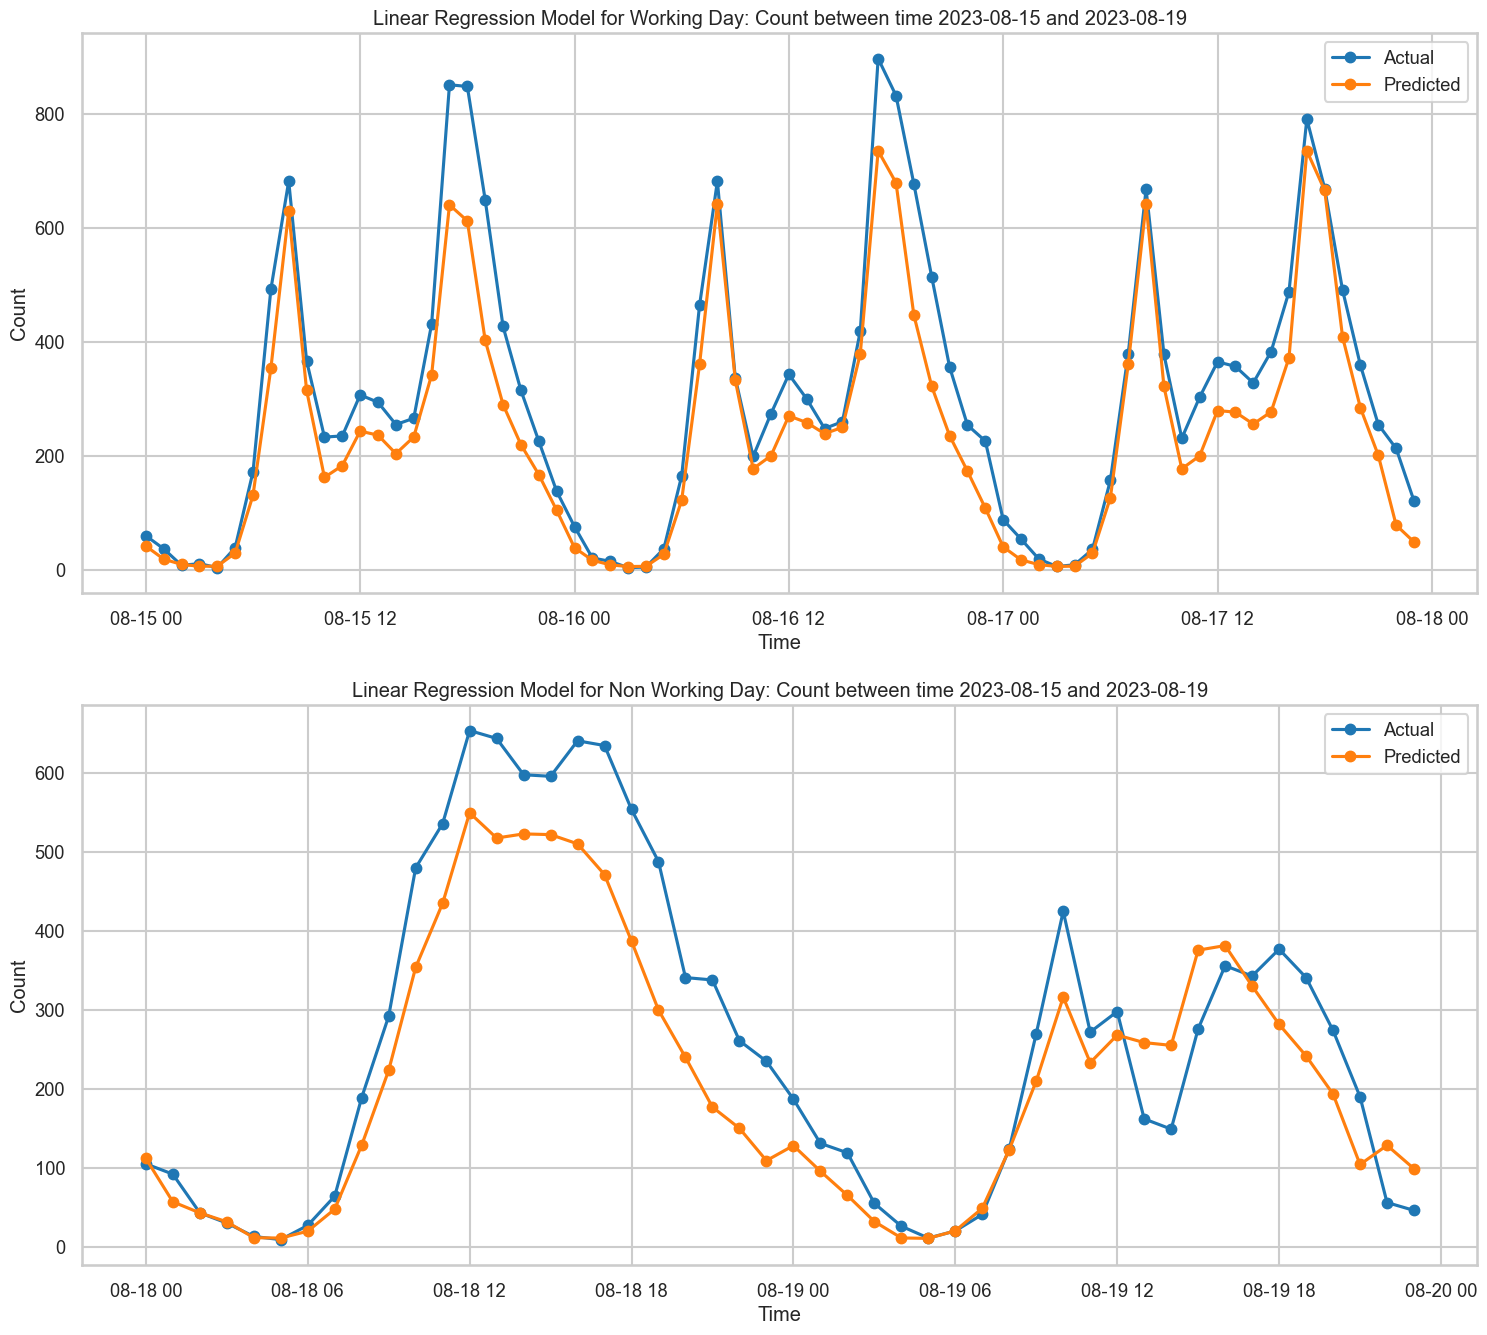

In [41]:
t_from, t_to = '2023-08-15', '2023-08-19'
ytest_w_predict, ytest_nw_predict = y_predict_summary[1], y_predict_summary[3]
ytest_w_predict = pd.Series(ytest_w_predict, index = ytest_w.index)
ytest_nw_predict = pd.Series(ytest_nw_predict, index = ytest_nw.index)

plot_true_vs_pred(ytest_w, ytest_nw, ytest_w_predict, ytest_nw_predict, 'Linear Regression', t_from, t_to)

In [42]:
df_coeff = pd.DataFrame({'features': X_w.columns, 'Lin_Coeff_Working': lreg_w.coef_, 'Lin_Coeff_Non_Working': lreg_nw.coef_})

In [43]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]}
ridge_w = GridSearchCV(Ridge(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
ridge_w.fit(X_w, logy_w)
print('Best alpha for Working Day Ridge Regression Model: {}'.format(ridge_w.best_params_))
ridge_nw = GridSearchCV(Ridge(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
ridge_nw.fit(X_nw, logy_nw)
print('Best alpha for Non Working Day Ridge Regression Model: {}'.format(ridge_nw.best_params_))

Best alpha for Working Day Ridge Regression Model: {'alpha': 0.1}
Best alpha for Non Working Day Ridge Regression Model: {'alpha': 0.5}


In [44]:
param_summary = [ridge_w.best_params_, ridge_nw.best_params_,'']

rmsle_summary, y_predict_summary = model_fit(ridge_w, X_w, Xtest_w, y_w, ytest_w, ridge_nw, X_nw, Xtest_nw, y_nw, ytest_nw)
ypred_test.loc[Xtest.workingday==1,'Ridge'], ypred_test.loc[Xtest.workingday==0,'Ridge'] = y_predict_summary[1], y_predict_summary[3]

In [45]:
rmsle_val_summary, y_predict_val_summary = cross_val(ridge_w, X_w, y_w, ridge_nw, X_nw, y_nw)
ypred_train.loc[X.workingday==1,'Ridge'], ypred_train.loc[X.workingday==0,'Ridge'] = y_predict_val_summary[0], y_predict_val_summary[1]

algo_score.loc['Ridge Regression'] = rmsle_summary+rmsle_val_summary+param_summary
algo_score.loc[['Ridge Regression']]

Train RMSLE (Working Day)  Train RMSLE (Non Working Day)  \
Modelling Algo                                                               
Ridge Regression                   0.453984                       0.496327   

                  Train RMSLE (Average)  Test RMSLE (Working Day)  \
Modelling Algo                                                      
Ridge Regression               0.467646                  0.412324   

                  Test RMSLE (Non Working Day)  Test RMSLE (Average)  \
Modelling Algo                                                         
Ridge Regression                      0.521429              0.451828   

                  Validation RMSLE (Working Day)  \
Modelling Algo                                     
Ridge Regression                        0.536396   

                  Validation RMSLE (Non Working Day)  \
Modelling Algo                                         
Ridge Regression                            0.658249   

                  Validation RMSLE (Average) Hyperparameters-Working  \
Modelling Algo                                                         
Ridge Regression                    0.577297          {'alpha': 0.1}   

                 Hyperparameters-Non Working Training+Test Time (sec)  
Modelling Algo                                                         
Ridge Regression              {'alpha': 0.5}

In [46]:
algo_score.loc['Ridge Regression', 'Training+Test Time (sec)'] = 1.3
cv_time.append(4.64)

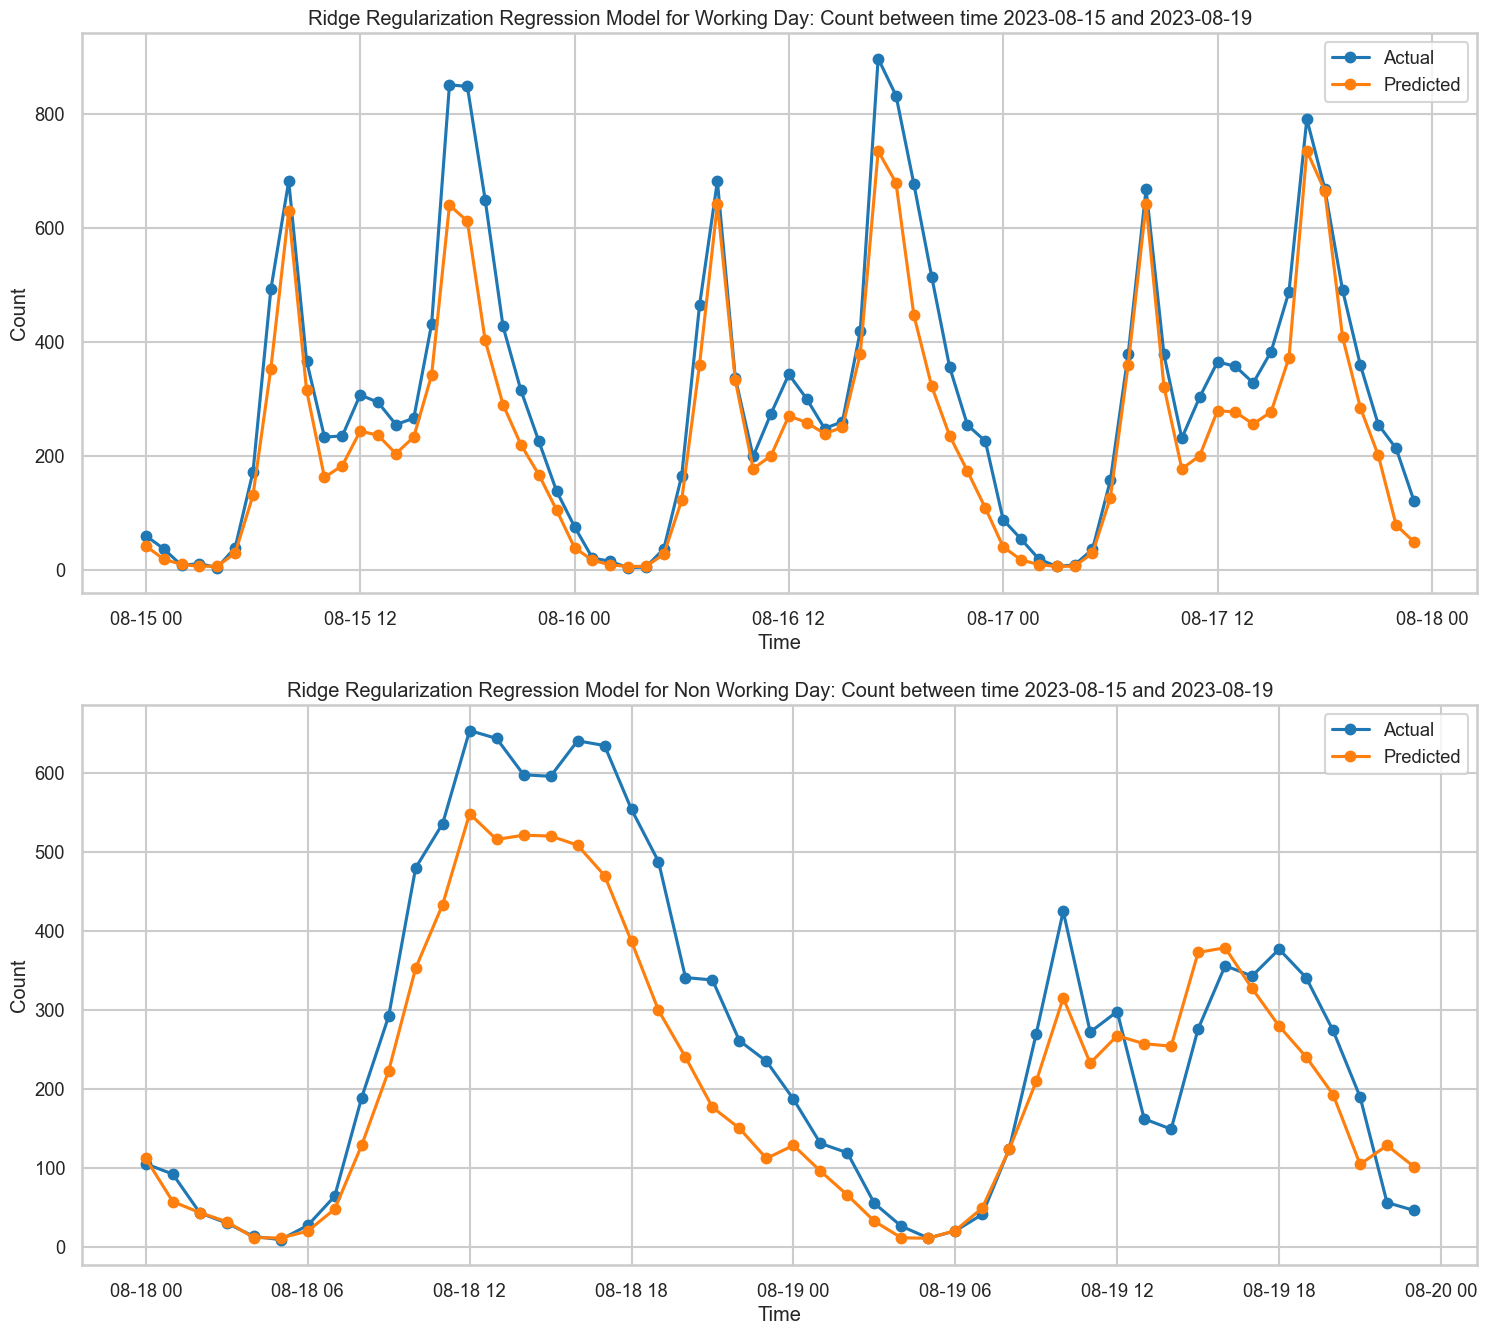

In [47]:
t_from, t_to = '2023-08-15', '2023-08-19'
ytest_w_predict, ytest_nw_predict = y_predict_summary[1], y_predict_summary[3]
ytest_w_predict = pd.Series(ytest_w_predict, index = ytest_w.index)
ytest_nw_predict = pd.Series(ytest_nw_predict, index = ytest_nw.index)

plot_true_vs_pred(ytest_w, ytest_nw, ytest_w_predict, ytest_nw_predict, 'Ridge Regularization Regression', t_from, t_to)

In [48]:
df_coeff['Ridge_Coeff_Working'] = ridge_w.best_estimator_.coef_
df_coeff['Ridge_Coeff_Non_Working'] = ridge_nw.best_estimator_.coef_

In [49]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]}
lasso_w = GridSearchCV(Lasso(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
lasso_w.fit(X_w, logy_w)
print('Best alpha for Working Day Lasso Regression Model: {}'.format(lasso_w.best_params_))

lasso_nw = GridSearchCV(Lasso(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
lasso_nw.fit(X_nw, logy_nw)
print('Best alpha for Non Working Day Lasso Regression Model: {}'.format(lasso_nw.best_params_))

Best alpha for Working Day Lasso Regression Model: {'alpha': 0.1}
Best alpha for Non Working Day Lasso Regression Model: {'alpha': 0.5}


In [50]:
param_summary = [lasso_w.best_params_, lasso_nw.best_params_,'']

rmsle_summary, y_predict_summary = model_fit(lasso_w, X_w, Xtest_w, y_w, ytest_w, lasso_nw, X_nw, Xtest_nw, y_nw, ytest_nw)
ypred_test.loc[Xtest.workingday==1,'Lasso'], ypred_test.loc[Xtest.workingday==0,'Lasso'] = y_predict_summary[1], y_predict_summary[3]

In [51]:
rmsle_val_summary, y_predict_val_summary = cross_val(lasso_w, X_w, y_w, lasso_nw, X_nw, y_nw)
ypred_train.loc[X.workingday==1,'Lasso'], ypred_train.loc[X.workingday==0,'Lasso'] = y_predict_val_summary[0], y_predict_val_summary[1]

algo_score.loc['Lasso Regression'] = rmsle_summary+rmsle_val_summary+param_summary
algo_score.loc[['Lasso Regression']]

Train RMSLE (Working Day)  Train RMSLE (Non Working Day)  \
Modelling Algo                                                               
Lasso Regression                   1.313353                       1.065252   

                  Train RMSLE (Average)  Test RMSLE (Working Day)  \
Modelling Algo                                                      
Lasso Regression               1.241062                  1.285346   

                  Test RMSLE (Non Working Day)  Test RMSLE (Average)  \
Modelling Algo                                                         
Lasso Regression                      1.117959              1.231794   

                  Validation RMSLE (Working Day)  \
Modelling Algo                                     
Lasso Regression                        1.346177   

                  Validation RMSLE (Non Working Day)  \
Modelling Algo                                         
Lasso Regression                            1.160387   

                  Validation RMSLE (Average) Hyperparameters-Working  \
Modelling Algo                                                         
Lasso Regression                    1.290919          {'alpha': 0.1}   

                 Hyperparameters-Non Working Training+Test Time (sec)  
Modelling Algo                                                         
Lasso Regression              {'alpha': 0.5}

In [52]:
algo_score.loc['Lasso Regression', 'Training+Test Time (sec)'] = 1.3
cv_time.append(4.57)

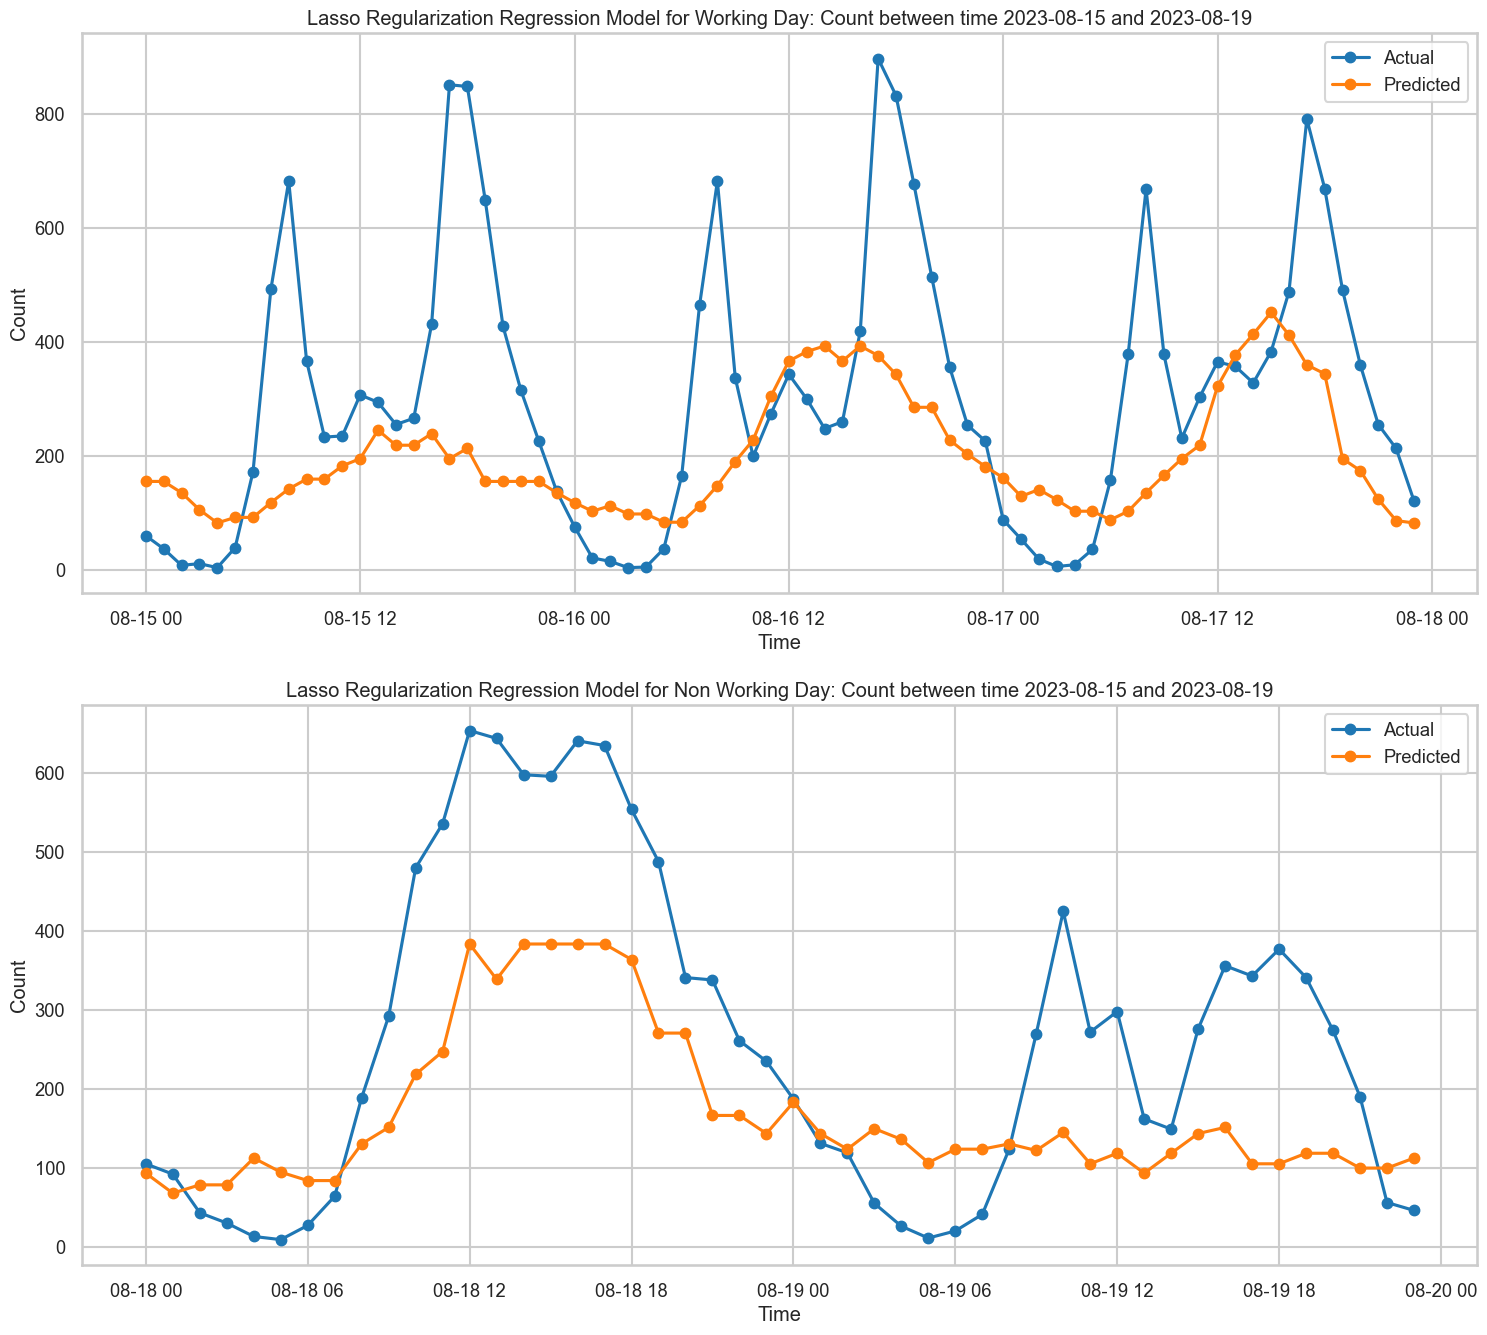

In [53]:
t_from, t_to = '2023-08-15', '2023-08-19'
ytest_w_predict, ytest_nw_predict = y_predict_summary[1], y_predict_summary[3]
ytest_w_predict = pd.Series(ytest_w_predict, index = ytest_w.index)
ytest_nw_predict = pd.Series(ytest_nw_predict, index = ytest_nw.index)

plot_true_vs_pred(ytest_w, ytest_nw, ytest_w_predict, ytest_nw_predict, 'Lasso Regularization Regression', t_from, t_to)

In [54]:
df_coeff['Lasso_Coeff_Working'] = lasso_w.best_estimator_.coef_
df_coeff['Lasso_Coeff_Non_Working'] = lasso_nw.best_estimator_.coef_

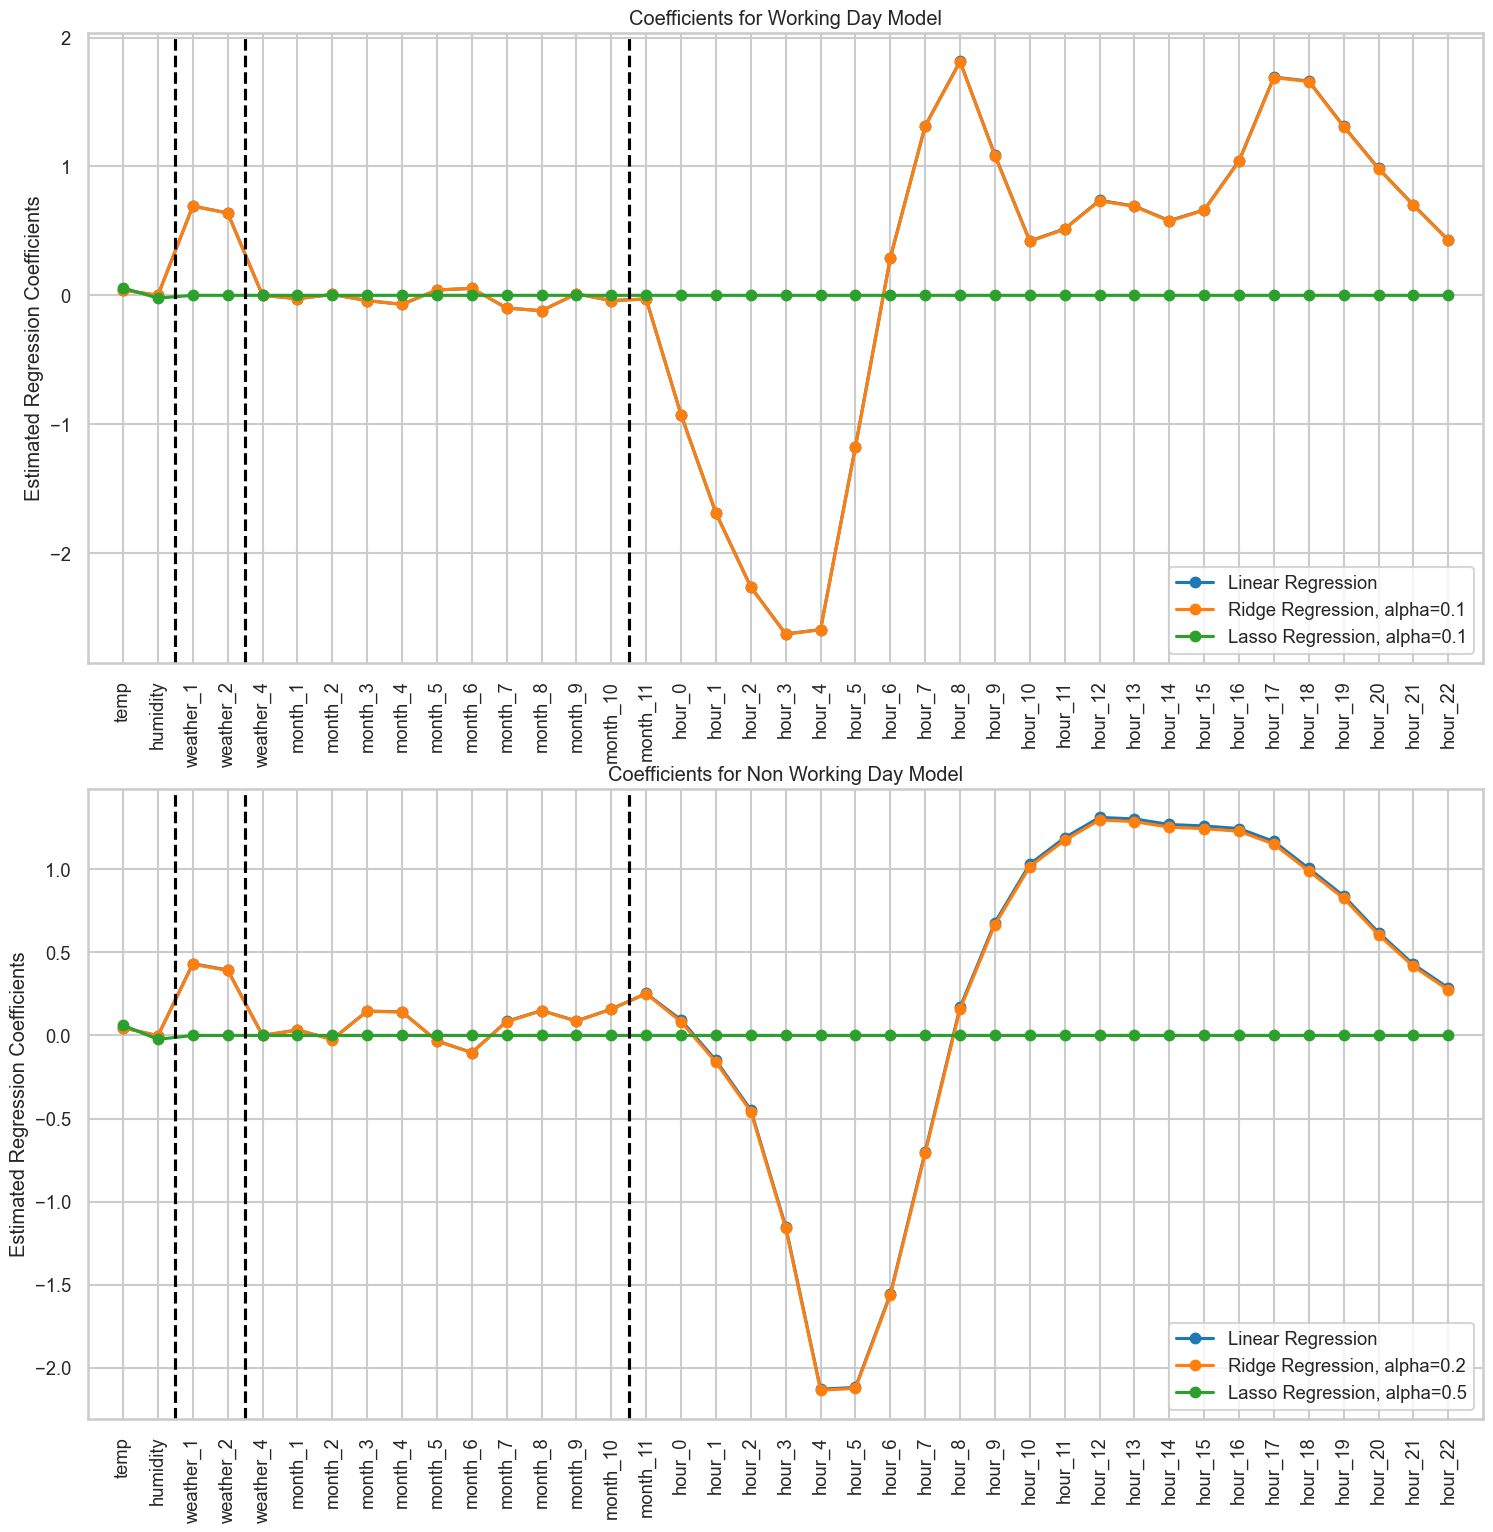

In [55]:
fig = plt.figure(figsize=(18, 18))

axes = fig.add_subplot(2, 1, 1)
axes.plot(df_coeff.Lin_Coeff_Working, label='Linear Regression', marker='.', markersize=15)
axes.plot(df_coeff.Ridge_Coeff_Working, label='Ridge Regression, alpha={}'.format(ridge_w.best_params_['alpha']), marker='.', markersize=15)
axes.plot(df_coeff.Lasso_Coeff_Working, label='Lasso Regression, alpha={}'.format(lasso_w.best_params_['alpha']), marker='.', markersize=15)
axes.axvline(2-0.5, c='k', ls='--')
axes.axvline(4-0.5,  c='k', ls='--')
axes.axvline(15-0.5,  c='k', ls='--')
plt.xticks(range(len(df_coeff.Lin_Coeff_Working)), df_coeff.features, rotation=90)
axes.set(ylabel='Estimated Regression Coefficients', title='Coefficients for Working Day Model')
axes.set(xlim=[-1, len(df_coeff.Lin_Coeff_Working)])
axes.legend()

axes = fig.add_subplot(2, 1, 2)
axes.plot(df_coeff.Lin_Coeff_Non_Working, label='Linear Regression', marker='.', markersize=15)
axes.plot(df_coeff.Ridge_Coeff_Non_Working, label='Ridge Regression, alpha={}'.format(ridge_nw.best_params_['alpha']), marker='.', markersize=15)
axes.plot(df_coeff.Lasso_Coeff_Non_Working, label='Lasso Regression, alpha={}'.format(lasso_nw.best_params_['alpha']), marker='.', markersize=15)
axes.axvline(2-0.5,  c='k', ls='--')
axes.axvline(4-0.5,  c='k', ls='--')
axes.axvline(15-0.5,  c='k', ls='--')
plt.xticks(range(len(df_coeff.Lin_Coeff_Working)), df_coeff.features, rotation=90)
axes.set(ylabel='Estimated Regression Coefficients', title='Coefficients for Non Working Day Model')
axes.set(xlim=[-1, len(df_coeff.Lin_Coeff_Working)])
axes.legend()

plt.show()

In [56]:
X2.head(n=3)

workingday weather  temp  humidity month hour
datetime                                                         
2022-01-01 00:00:00          0       1  9.84        81     1    0
2022-01-01 01:00:00          0       1  9.02        80     1    1
2022-01-01 02:00:00          0       1  9.02        80     1    2

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

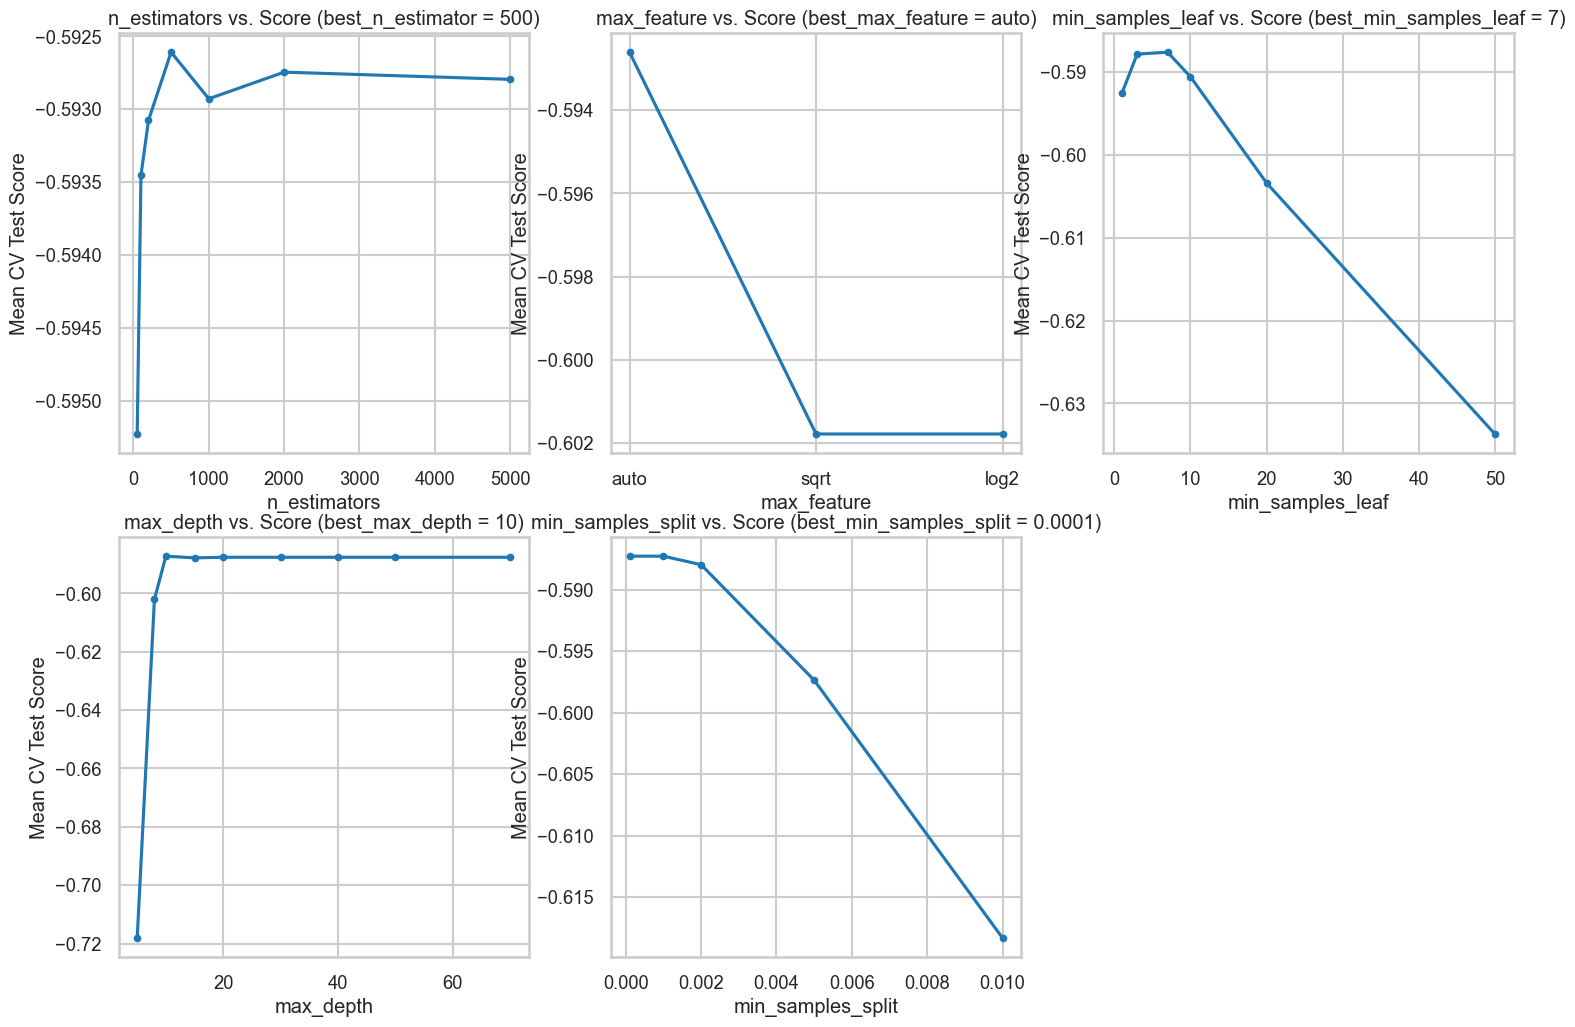

In [58]:
fig=plt.figure(figsize=(18, 12))

n_est_array = [50, 100, 200, 500, 1000, 2000, 5000]
n_est_cv_score = [-0.59522862, -0.59345376, -0.59307606, -0.59260841, -0.59292831,-0.59274538, -0.59279494]
axes=fig.add_subplot(2, 3, 1)
axes.plot(n_est_array, n_est_cv_score, marker='.')
axes.set(xlabel='n_estimators', ylabel='Mean CV Test Score', title='n_estimators vs. Score (best_n_estimator = 500)')

max_feature_array = ['auto', 'sqrt', 'log2']
max_feature_cv_score = [-0.59260841, -0.60178303, -0.60178303]
axes=fig.add_subplot(2, 3, 2)
axes.plot(range(3), max_feature_cv_score, marker='.')
plt.xticks(range(3), max_feature_array)
axes.set(xlabel='max_feature', ylabel='Mean CV Test Score', title='max_feature vs. Score (best_max_feature = auto)')

min_samples_leaf_array = [1, 3, 7, 10, 20, 50]
min_samples_leaf_cv_score = [-0.59260841, -0.58788348, -0.58764415, -0.59060404, -0.60340495,-0.63367843]
axes=fig.add_subplot(2, 3, 3)
axes.plot(min_samples_leaf_array, min_samples_leaf_cv_score, marker='.')
axes.set(xlabel='min_samples_leaf', ylabel='Mean CV Test Score', title='min_samples_leaf vs. Score (best_min_samples_leaf = 7)')

max_depth_array = [5, 8, 10, 15, 20, 30, 40, 50, 70]
max_depth_cv_score = [-0.71808668, -0.60209726, -0.58727382, -0.58785334, -0.58764068, -0.58764415, -0.58764415, -0.58764415, -0.58764415]
axes=fig.add_subplot(2, 3, 4)
axes.plot(max_depth_array, max_depth_cv_score, marker='.')
axes.set(xlabel='max_depth', ylabel='Mean CV Test Score', title='max_depth vs. Score (best_max_depth = 10)')

min_samples_split_array = [0.0001, 0.001, 0.002, 0.005, 0.01]
min_samples_split_cv_score = [-0.58727382, -0.58727382, -0.58796633, -0.59735637, -0.61832167]
axes=fig.add_subplot(2, 3, 5)
axes.plot(min_samples_split_array, min_samples_split_cv_score, marker='.')
axes.set(xlabel='min_samples_split', ylabel='Mean CV Test Score', title='min_samples_split vs. Score (best_min_samples_split = 0.0001)')

plt.show()

In [59]:
from sklearn.ensemble import RandomForestRegressor

best_n_estimators, best_max_features = 500, 'auto'
best_min_samples_leaf, best_max_depth = 7, 10
param_summary = ['n_estimators: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators, best_max_features, best_min_samples_leaf, best_max_depth), 
                 'n_estimators: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators, best_max_features, best_min_samples_leaf, best_max_depth),'']

rfa = RandomForestRegressor(n_estimators = best_n_estimators, max_features = best_max_features, 
                           min_samples_leaf = best_min_samples_leaf, max_depth = best_max_depth, random_state=42)

rmsle_summary, y_predict_summary = model_fit(rfa, X2, Xtest2, y2, ytest2)
ypred_test['RF1'] = y_predict_summary[1]

In [60]:
rmsle_val_summary, y_predict_val_summary = cross_val(rfa, X2, y2)
ypred_train['RF1'] = y_predict_val_summary[0]

algo_score.loc['Random Forest-Categorical+Single'] = rmsle_summary+rmsle_val_summary+param_summary
algo_score.loc[['Random Forest-Categorical+Single']]

Train RMSLE (Working Day)  \
Modelling Algo                                                
Random Forest-Categorical+Single                    0.37515   

                                  Train RMSLE (Non Working Day)  \
Modelling Algo                                                    
Random Forest-Categorical+Single                       0.423445   

                                  Train RMSLE (Average)  \
Modelling Algo                                            
Random Forest-Categorical+Single               0.390904   

                                  Test RMSLE (Working Day)  \
Modelling Algo                                               
Random Forest-Categorical+Single                  0.402572   

                                  Test RMSLE (Non Working Day)  \
Modelling Algo                                                   
Random Forest-Categorical+Single                      0.495153   

                                  Test RMSLE (Average)  \
Modelling Algo                                           
Random Forest-Categorical+Single              0.435791   

                                  Validation RMSLE (Working Day)  \
Modelling Algo                                                     
Random Forest-Categorical+Single                        0.511343   

                                  Validation RMSLE (Non Working Day)  \
Modelling Algo                                                         
Random Forest-Categorical+Single                            0.600791   

                                  Validation RMSLE (Average)  \
Modelling Algo                                                 
Random Forest-Categorical+Single                    0.540925   

                                                            Hyperparameters-Working  \
Modelling Algo                                                                        
Random Forest-Categorical+Single  n_estimators: 500, max_features: auto, min_sam...   

                                                        Hyperparameters-Non Working  \
Modelling Algo                                                                        
Random Forest-Categorical+Single  n_estimators: 500, max_features: auto, min_sam...   

                                 Training+Test Time (sec)  
Modelling Algo                                             
Random Forest-Categorical+Single

In [61]:
algo_score.loc['Random Forest-Categorical+Single', 'Training+Test Time (sec)'] = 5.48
cv_time.append(19.9)

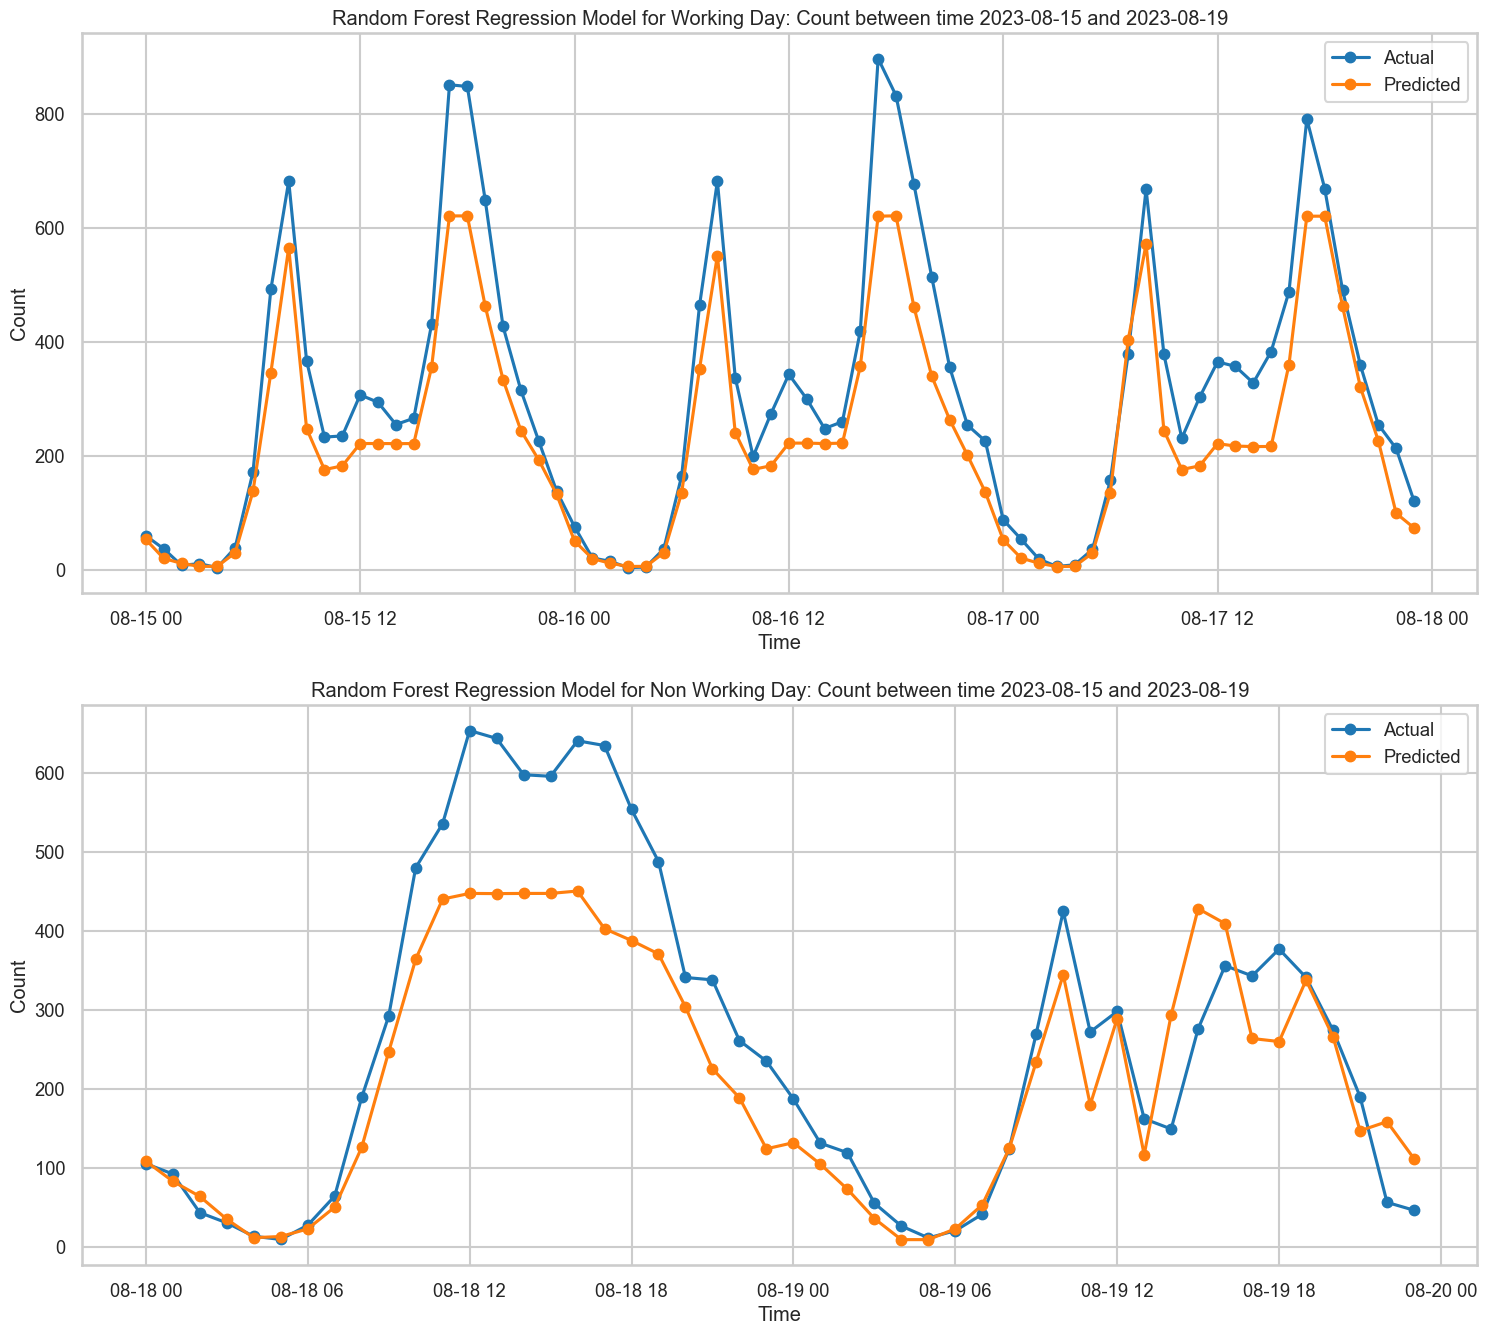

In [62]:
t_from, t_to = '2023-08-15', '2023-08-19'
y_test_predict =  pd.Series(y_predict_summary[1], index = ytest2.index) 
ytest_w_predict, ytest_nw_predict = y_test_predict[Xtest2.workingday==1], y_test_predict[Xtest2.workingday==0]
plot_true_vs_pred(ytest2_w, ytest2_nw, ytest_w_predict, ytest_nw_predict, 'Random Forest Regression', t_from, t_to)

In [63]:
Xtest2['2023-08-19 09':'2023-08-19 15']

workingday weather   temp  humidity month hour
datetime                                                          
2023-08-19 09:00:00          0       2  27.06        74     8    9
2023-08-19 10:00:00          0       2  27.88        69     8   10
2023-08-19 11:00:00          0       3  26.24        78     8   11
2023-08-19 12:00:00          0       3  26.24        73     8   12
2023-08-19 13:00:00          0       3  26.24        83     8   13
2023-08-19 14:00:00          0       3  26.24        73     8   14
2023-08-19 15:00:00          0       2  26.24        65     8   15

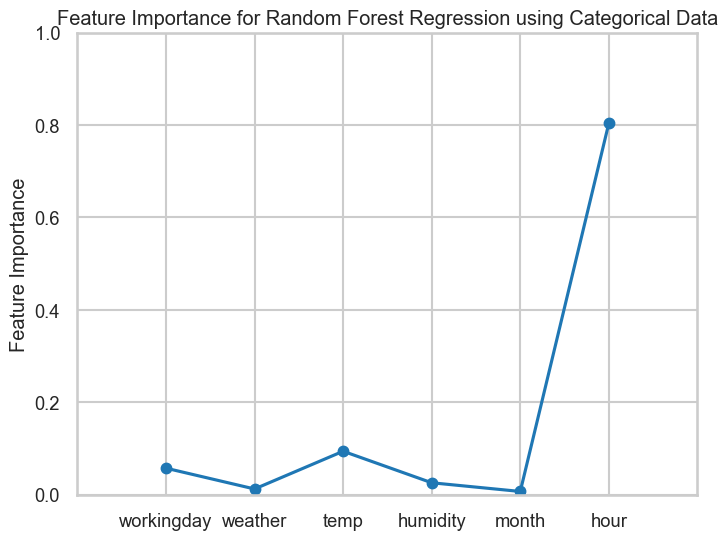

In [64]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(rfa.feature_importances_, marker='.', markersize=15)
plt.xticks(range(len(rfa.feature_importances_)), X2.columns)
axes.set(ylabel='Feature Importance', title='Feature Importance for Random Forest Regression using Categorical Data')
axes.set(xlim=[-1, len(X2.columns)], ylim=[0, 1])

plt.show()

RMSLE score for Random Forest Regressor using a small tree (max_depth = 3) for simple visualization = 0.745


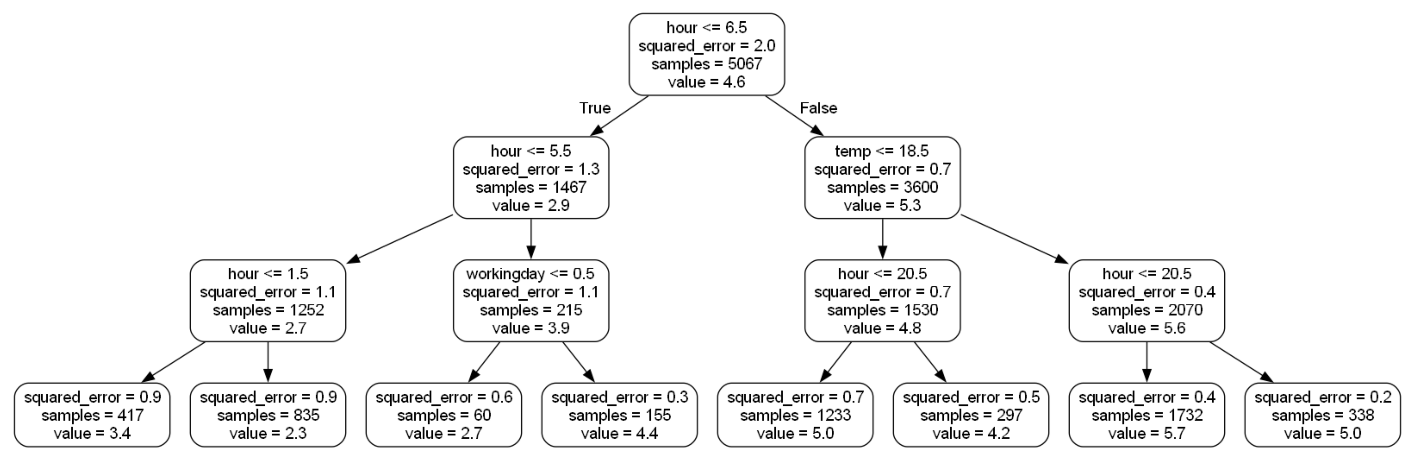

In [65]:
rf_small = RandomForestRegressor(n_estimators=10, max_features='auto', max_depth=3, random_state=42)
rf_small.fit(X2, logy2)

logy2_predict_small = rf_small.predict(X2)
rmsle2_small = rmsle(y2, np.expm1(logy2_predict_small))
print('RMSLE score for Random Forest Regressor using a small tree (max_depth = 3) for simple visualization = {0:.3f}'.format(rmsle2_small))

tree = rf_small.estimators_[0]

dot_data = export_graphviz(tree, out_file='./Images/tree_rf1.dot', feature_names=X2.columns, rounded=True, precision=1)

(graph,) = pydot.graph_from_dot_file('./Images/tree_rf1.dot')

graph.write_png('./Images/tree_rf1.png')

img = mpimg.imread('./Images/tree_rf1.png')
plt.figure(figsize=(18, 12))
plt.imshow(img)
plt.axis('off')  
plt.show()

In [66]:
X_w.head(n=2)

temp  humidity  weather_1  weather_2  weather_4  month_1  \
datetime                                                                        
2022-03-01 00:00:00  9.02        44          1          0          0        0   
2022-03-01 01:00:00  8.20        44          1          0          0        0   

                     month_2  month_3  month_4  month_5  ...  hour_13  \
datetime                                                 ...            
2022-03-01 00:00:00        0        1        0        0  ...        0   
2022-03-01 01:00:00        0        1        0        0  ...        0   

                     hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  \
datetime                                                                    
2022-03-01 00:00:00        0        0        0        0        0        0   
2022-03-01 01:00:00        0        0        0        0        0        0   

                     hour_20  hour_21  hour_22  
datetime                                        
2022-03-01 00:00:00        0        0        0  
2022-03-01 01:00:00        0        0        0  

[2 rows x 39 columns]

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

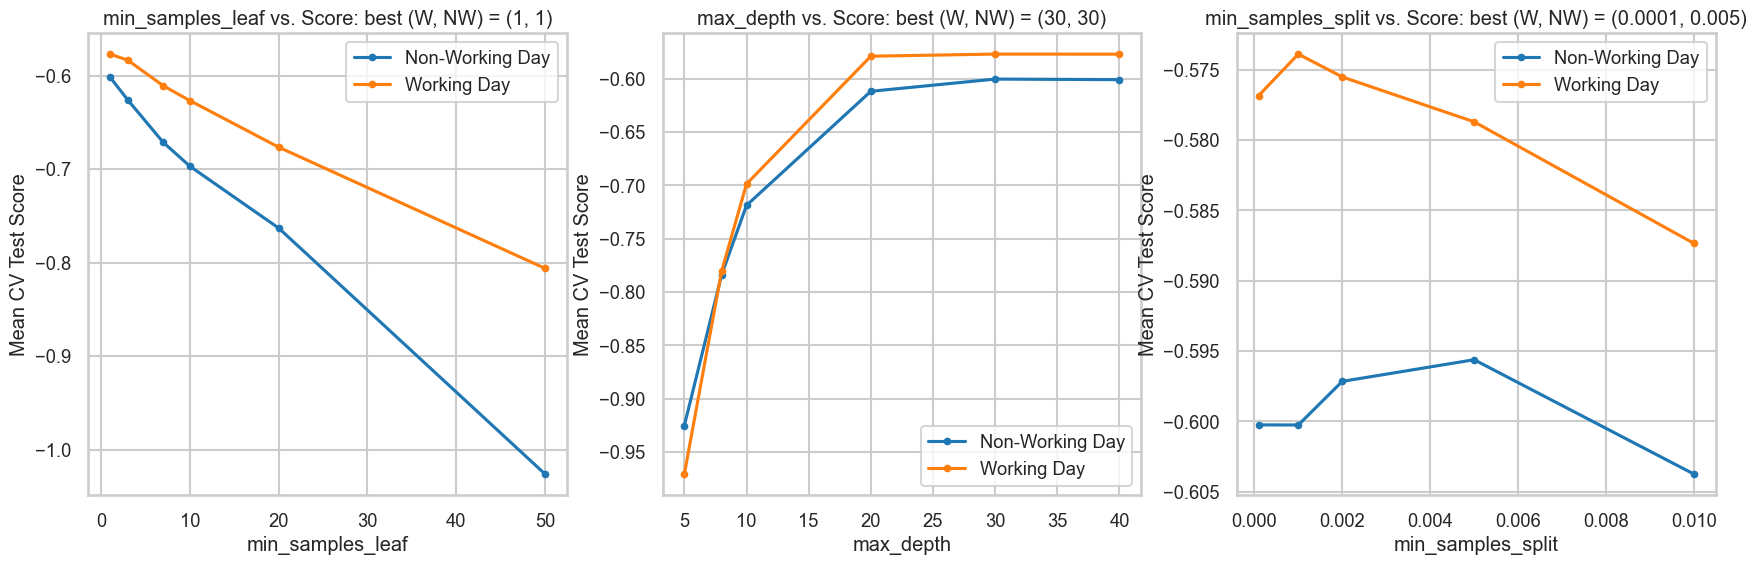

In [68]:
fig=plt.figure(figsize=(21, 6))

min_samples_leaf_array = [1, 3, 7, 10, 20, 50]
min_samples_leaf_cv_score_nw = [-0.6014166 , -0.62586217, -0.6713266 , -0.69684692, -0.76302209, -1.02612827]
min_samples_leaf_cv_score_w = [-0.57692764, -0.58339873, -0.61078536, -0.62668656, -0.67648766, -0.806137]
axes=fig.add_subplot(1, 3, 1)
axes.plot(min_samples_leaf_array, min_samples_leaf_cv_score_nw, marker='.', label='Non-Working Day')
axes.plot(min_samples_leaf_array, min_samples_leaf_cv_score_w, marker='.', label='Working Day')
axes.set(xlabel='min_samples_leaf', ylabel='Mean CV Test Score', title='min_samples_leaf vs. Score: best (W, NW) = (1, 1)')
axes.legend()

max_depth_array = [5, 8, 10, 20, 30, 40]
max_depth_cv_score_nw = [-0.92512009, -0.7837481 , -0.71864241, -0.61170644, -0.60025831, -0.6007901 ]
max_depth_cv_score_w = [-0.97058161, -0.78030942, -0.69859085, -0.57880264, -0.57681758, -0.57689858]
axes=fig.add_subplot(1, 3, 2)
axes.plot(max_depth_array, max_depth_cv_score_nw, marker='.', label='Non-Working Day')
axes.plot(max_depth_array, max_depth_cv_score_w, marker='.', label='Working Day')
axes.set(xlabel='max_depth', ylabel='Mean CV Test Score', title='max_depth vs. Score: best (W, NW) = (30, 30)')
axes.legend()

min_samples_split_array = [0.0001, 0.001, 0.002, 0.005, 0.01]
min_samples_split_cv_score_nw = [-0.60025831, -0.6002647 , -0.59716144, -0.59562094, -0.60375905]
min_samples_split_cv_score_w = [-0.57681758, -0.57386935, -0.57549636, -0.57868933, -0.58734106]
axes=fig.add_subplot(1, 3, 3)
axes.plot(min_samples_split_array, min_samples_split_cv_score_nw, marker='.', label='Non-Working Day')
axes.plot(min_samples_split_array, min_samples_split_cv_score_w, marker='.', label='Working Day')
axes.set(xlabel='min_samples_split', ylabel='Mean CV Test Score', title='min_samples_split vs. Score: best (W, NW) = (0.0001, 0.005)')
axes.legend()

plt.show()

In [69]:
best_n_estimators_w, best_max_features_w, best_min_samples_leaf_w, best_max_depth_w, best_min_samples_split_w = 2000, 'sqrt', 1, 30, 0.0001
best_n_estimators_nw, best_max_features_nw ,best_min_samples_leaf_nw, best_max_depth_nw, best_min_samples_split_nw = 200, 'log2', 1, 30, 0.005
param_summary = ['n_estimators: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}, min_samples_split: {}'.format(best_n_estimators_w, best_max_features_w, best_min_samples_leaf_w, best_max_depth_w, best_min_samples_split_w), 
                 'n_estimators: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}, min_samples_split: {}'.format(best_n_estimators_nw, best_max_features_nw, best_min_samples_leaf_nw, best_max_depth_nw, best_min_samples_split_nw),'']

print('Best parameters via GridSearchCV for Working Day:     '+param_summary[0])
print('Best parameters via GridSearchCV for Non Working Day: '+param_summary[1])

rfb_w = RandomForestRegressor(n_estimators=best_n_estimators_w, max_features=best_max_features_w, min_samples_leaf=best_min_samples_leaf_w, 
                             max_depth=best_max_depth_w, min_samples_split=best_min_samples_split_w, random_state=42)
rfb_nw = RandomForestRegressor(n_estimators=best_n_estimators_nw, max_features=best_max_features_nw, min_samples_leaf=best_min_samples_leaf_nw, 
                             max_depth=best_max_depth_nw, min_samples_split=best_min_samples_split_nw, random_state=42)

rmsle_summary, y_predict_summary = model_fit(rfb_w, X_w, Xtest_w, y_w, ytest_w, rfb_nw, X_nw, Xtest_nw, y_nw, ytest_nw)
ypred_test.loc[Xtest.workingday==1,'RF2'], ypred_test.loc[Xtest.workingday==0,'RF2'] = y_predict_summary[1], y_predict_summary[3]

Best parameters via GridSearchCV for Working Day:     n_estimators: 2000, max_features: sqrt, min_samples_leaf: 1, max_depth: 30, min_samples_split: 0.0001
Best parameters via GridSearchCV for Non Working Day: n_estimators: 200, max_features: log2, min_samples_leaf: 1, max_depth: 30, min_samples_split: 0.005


In [70]:
rmsle_val_summary, y_predict_val_summary = cross_val(rfb_w, X_w, y_w, rfb_nw, X_nw, y_nw)
ypred_train.loc[X.workingday==1,'RF2'], ypred_train.loc[X.workingday==0,'RF2'] = y_predict_val_summary[0], y_predict_val_summary[1]

algo_score.loc['Random Forest-OneHotEncoding'] = rmsle_summary+rmsle_val_summary+param_summary
algo_score.loc[['Random Forest-OneHotEncoding']]


Train RMSLE (Working Day)  \
Modelling Algo                                            
Random Forest-OneHotEncoding                   0.192137   

                              Train RMSLE (Non Working Day)  \
Modelling Algo                                                
Random Forest-OneHotEncoding                       0.401101   

                              Train RMSLE (Average)  Test RMSLE (Working Day)  \
Modelling Algo                                                                  
Random Forest-OneHotEncoding               0.275149                  0.416997   

                              Test RMSLE (Non Working Day)  \
Modelling Algo                                               
Random Forest-OneHotEncoding                      0.549244   

                              Test RMSLE (Average)  \
Modelling Algo                                       
Random Forest-OneHotEncoding              0.465515   

                              Validation RMSLE (Working Day)  \
Modelling Algo                                                 
Random Forest-OneHotEncoding                        0.515423   

                              Validation RMSLE (Non Working Day)  \
Modelling Algo                                                     
Random Forest-OneHotEncoding                            0.624949   

                              Validation RMSLE (Average)  \
Modelling Algo                                             
Random Forest-OneHotEncoding                    0.552036   

                                                        Hyperparameters-Working  \
Modelling Algo                                                                    
Random Forest-OneHotEncoding  n_estimators: 2000, max_features: sqrt, min_sa...   

                                                    Hyperparameters-Non Working  \
Modelling Algo                                                                    
Random Forest-OneHotEncoding  n_estimators: 200, max_features: log2, min_sam...   

                             Training+Test Time (sec)  
Modelling Algo                                         
Random Forest-OneHotEncoding

In [71]:
algo_score.loc['Random Forest-OneHotEncoding', 'Training+Test Time (sec)'] = 22.4
cv_time.append(80.3)

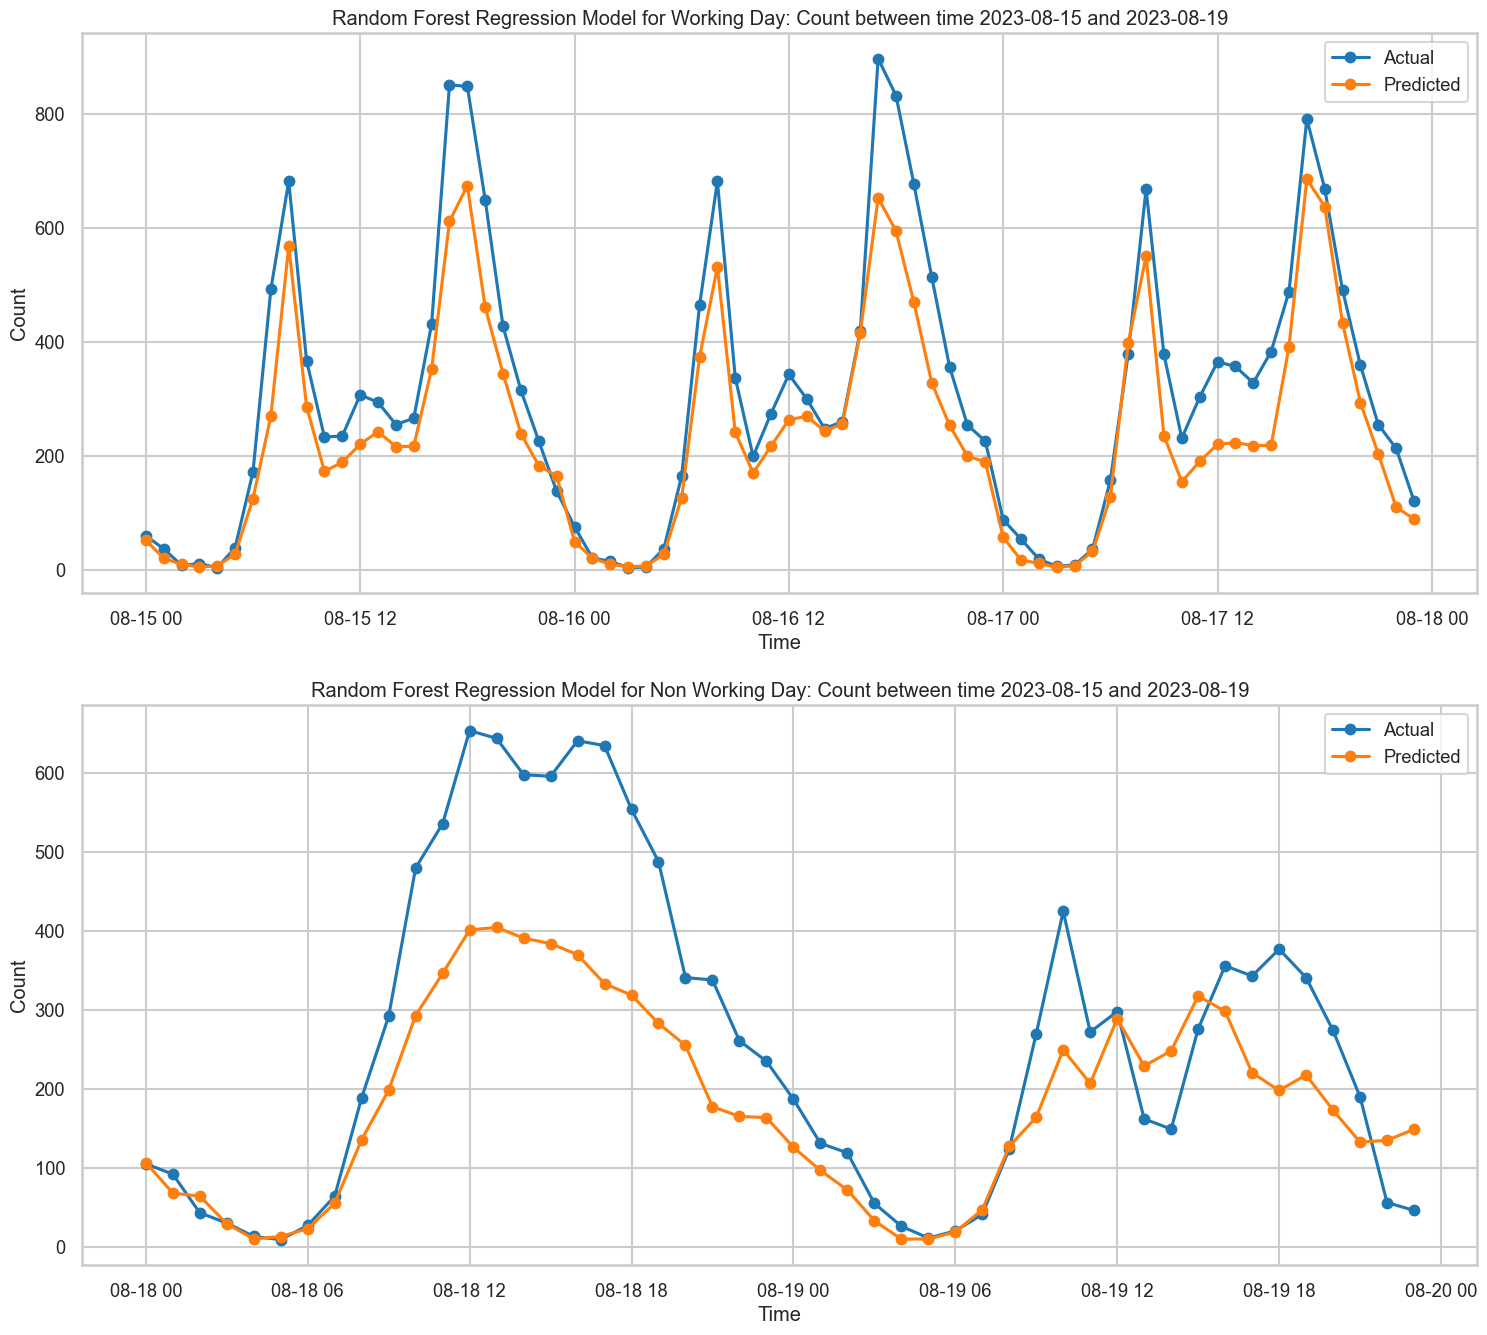

In [72]:
 t_from, t_to = '2023-08-15', '2023-08-19'
ytest_w_predict, ytest_nw_predict = y_predict_summary[1], y_predict_summary[3]
ytest_w_predict = pd.Series(ytest_w_predict, index = ytest_w.index)
ytest_nw_predict = pd.Series(ytest_nw_predict, index = ytest_nw.index)

plot_true_vs_pred(ytest_w, ytest_nw, ytest_w_predict, ytest_nw_predict, 'Random Forest Regression', t_from, t_to)

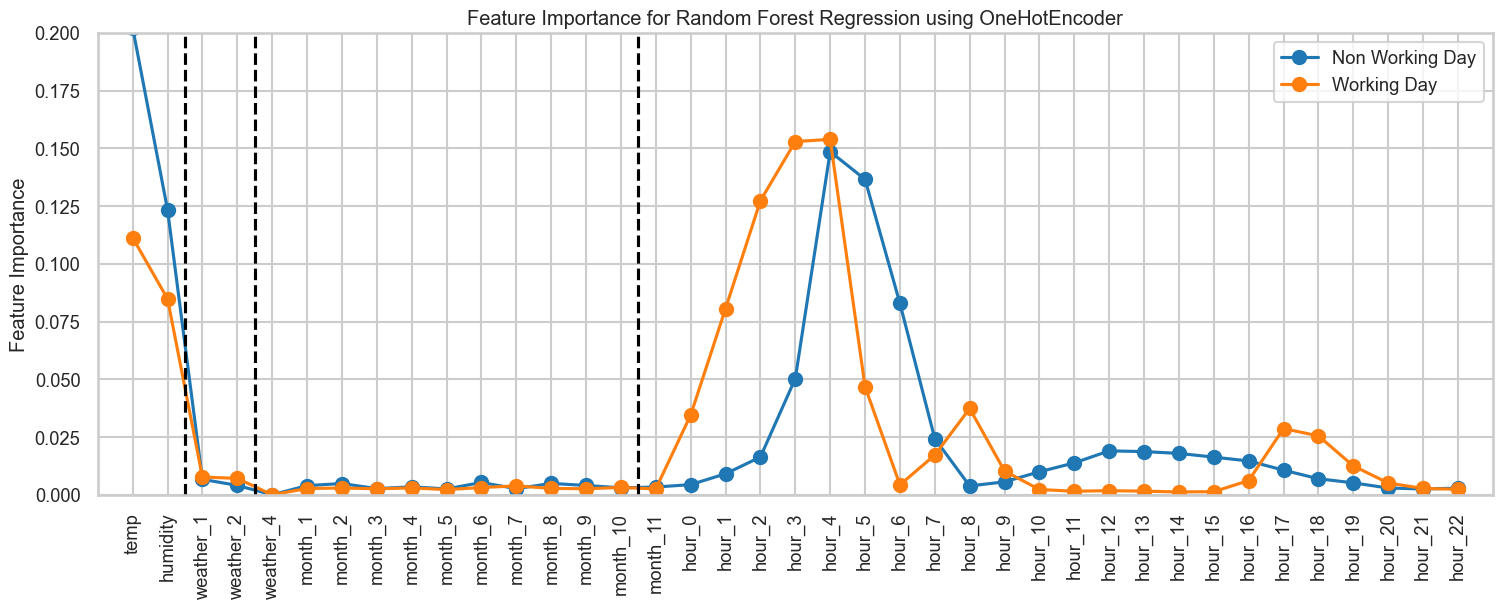

In [73]:
fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(rfb_nw.feature_importances_, label='Non Working Day', marker='.', markersize=20)
axes.plot(rfb_w.feature_importances_, label='Working Day', marker='.', markersize=20)
plt.xticks(range(len(rfb_w.feature_importances_)), X_w.columns, rotation=90)
axes.axvline(2-0.5, c='k', ls='--')
axes.axvline(4-0.5,  c='k', ls='--')
axes.axvline(15-0.5,  c='k', ls='--')
axes.set(ylabel='Feature Importance', title='Feature Importance for Random Forest Regression using OneHotEncoder')
axes.set(xlim=[-1, len(X_w.columns)], ylim=[0, 0.2])
axes.legend()

plt.show()

In [74]:
X2_w.head(n=3)

weather  temp  humidity month hour
datetime                                              
2022-03-01 00:00:00       1  9.02        44     3    0
2022-03-01 01:00:00       1  8.20        44     3    1
2022-03-01 04:00:00       1  6.56        47     3    4

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


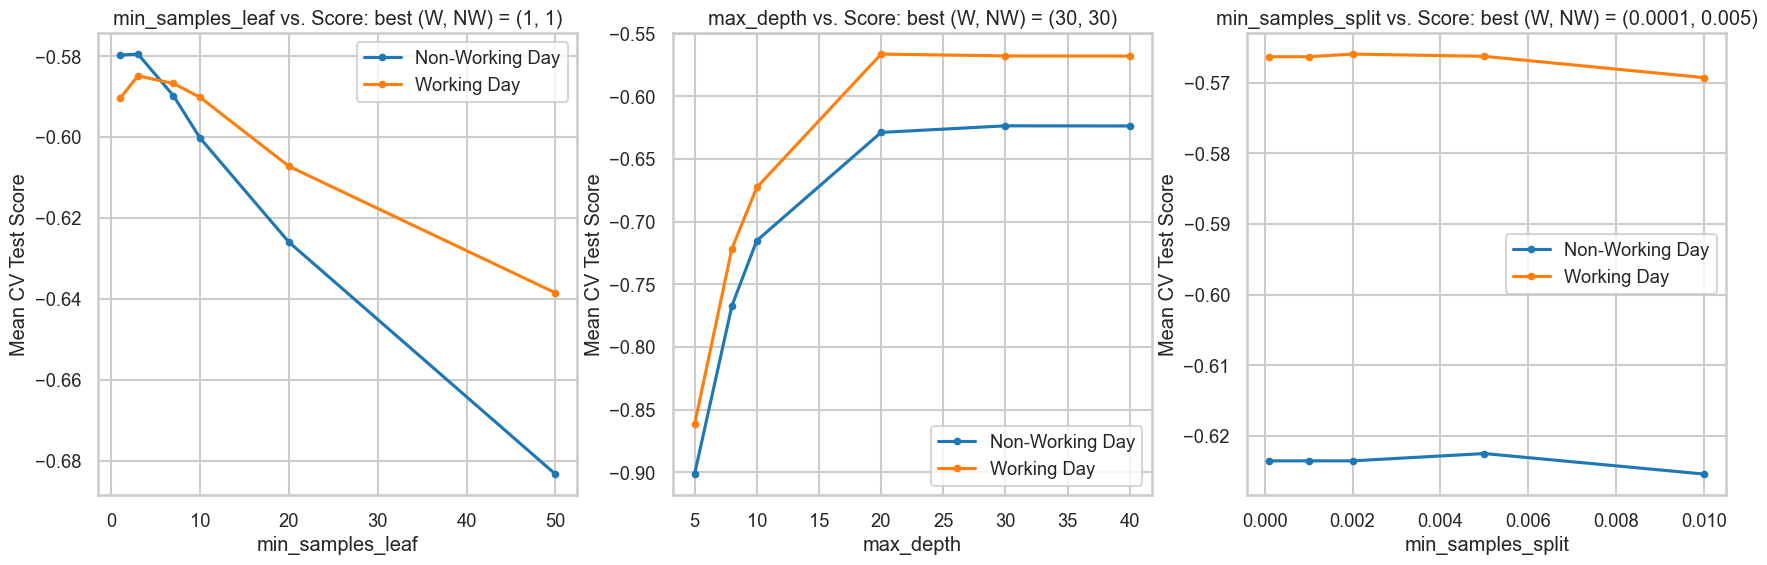

In [76]:
fig=plt.figure(figsize=(21, 6))

min_samples_leaf_array = [1, 3, 7, 10, 20, 50]
min_samples_leaf_cv_score_nw = [-0.57970417, -0.57946332, -0.58976635, -0.6002362 , -0.6259668 ,
       -0.68333543]
min_samples_leaf_cv_score_w = [-0.59039957, -0.58484149, -0.58673642, -0.59015947, -0.60721752,
       -0.63850817]
axes=fig.add_subplot(1, 3, 1)
axes.plot(min_samples_leaf_array, min_samples_leaf_cv_score_nw, marker='.', label='Non-Working Day')
axes.plot(min_samples_leaf_array, min_samples_leaf_cv_score_w, marker='.', label='Working Day')
axes.set(xlabel='min_samples_leaf', ylabel='Mean CV Test Score', title='min_samples_leaf vs. Score: best (W, NW) = (1, 1)')
axes.legend()

max_depth_array = [5, 8, 10, 20, 30, 40]
max_depth_cv_score_nw = [-0.9013261 , -0.76711388, -0.7151308 , -0.6287906 , -0.62354017, -0.62364191]
max_depth_cv_score_w = [-0.86157536, -0.72155214, -0.67269418, -0.56630213, -0.56777392, -0.56789159]
axes=fig.add_subplot(1, 3, 2)
axes.plot(max_depth_array, max_depth_cv_score_nw, marker='.', label='Non-Working Day')
axes.plot(max_depth_array, max_depth_cv_score_w, marker='.', label='Working Day')
axes.set(xlabel='max_depth', ylabel='Mean CV Test Score', title='max_depth vs. Score: best (W, NW) = (30, 30)')
axes.legend()

min_samples_split_array = [0.0001, 0.001, 0.002, 0.005, 0.01]
min_samples_split_cv_score_nw = [-0.62354017, -0.62354017, -0.62354017, -0.62250308, -0.62541206]
min_samples_split_cv_score_w = [-0.56630213, -0.56630213, -0.56592649, -0.56624378, -0.56926262]
axes=fig.add_subplot(1, 3, 3)
axes.plot(min_samples_split_array, min_samples_split_cv_score_nw, marker='.', label='Non-Working Day')
axes.plot(min_samples_split_array, min_samples_split_cv_score_w, marker='.', label='Working Day')
axes.set(xlabel='min_samples_split', ylabel='Mean CV Test Score', title='min_samples_split vs. Score: best (W, NW) = (0.0001, 0.005)')
axes.legend()

plt.show()

In [77]:
best_n_estimators_w, best_max_features_w, best_min_samples_leaf_w, best_max_depth_w, best_min_samples_split_w = 500, 'auto', 3, 20, 0.002
best_n_estimators_nw, best_max_features_nw ,best_min_samples_leaf_nw, best_max_depth_nw, best_min_samples_split_nw = 500, 'sqrt', 3, 30, 0.005
param_summary = ['n_estimators: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}, min_samples_split: {}'.format(best_n_estimators_w, best_max_features_w, best_min_samples_leaf_w, best_max_depth_w, best_min_samples_split_w), 
                 'n_estimators: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}, min_samples_split: {}'.format(best_n_estimators_nw, best_max_features_nw, best_min_samples_leaf_nw, best_max_depth_nw, best_min_samples_split_nw),'']

print('Best parameters via GridSearchCV for Working Day:     '+param_summary[0])
print('Best parameters via GridSearchCV for Non Working Day: '+param_summary[1])

rfc_w = RandomForestRegressor(n_estimators=best_n_estimators_w, max_features=best_max_features_w, min_samples_leaf=best_min_samples_leaf_w, 
                             max_depth=best_max_depth_w, min_samples_split=best_min_samples_split_w, random_state=42)
rfc_nw = RandomForestRegressor(n_estimators=best_n_estimators_nw, max_features=best_max_features_nw, min_samples_leaf=best_min_samples_leaf_nw, 
                             max_depth=best_max_depth_nw, min_samples_split=best_min_samples_split_nw, random_state=42)

rmsle_summary, y_predict_summary = model_fit(rfc_w, X2_w, Xtest2_w, y2_w, ytest2_w, rfc_nw, X2_nw, Xtest2_nw, y2_nw, ytest2_nw)
ypred_test.loc[Xtest2.workingday==1,'RF3'], ypred_test.loc[Xtest2.workingday==0,'RF3'] = y_predict_summary[1], y_predict_summary[3]

Best parameters via GridSearchCV for Working Day:     n_estimators: 500, max_features: auto, min_samples_leaf: 3, max_depth: 20, min_samples_split: 0.002
Best parameters via GridSearchCV for Non Working Day: n_estimators: 500, max_features: sqrt, min_samples_leaf: 3, max_depth: 30, min_samples_split: 0.005


In [78]:
rmsle_val_summary, y_predict_val_summary = cross_val(rfc_w, X2_w, y2_w, rfc_nw, X2_nw, y2_nw)
ypred_train.loc[X2.workingday==1,'RF3'], ypred_train.loc[X2.workingday==0,'RF3'] = y_predict_val_summary[0], y_predict_val_summary[1]

algo_score.loc['Random Forest-Categorical Features'] = rmsle_summary+rmsle_val_summary+param_summary
algo_score.loc[['Random Forest-Categorical Features']]

Train RMSLE (Working Day)  \
Modelling Algo                                                  
Random Forest-Categorical Features                   0.307955   

                                    Train RMSLE (Non Working Day)  \
Modelling Algo                                                      
Random Forest-Categorical Features                       0.376976   

                                    Train RMSLE (Average)  \
Modelling Algo                                              
Random Forest-Categorical Features               0.331103   

                                    Test RMSLE (Working Day)  \
Modelling Algo                                                 
Random Forest-Categorical Features                  0.403613   

                                    Test RMSLE (Non Working Day)  \
Modelling Algo                                                     
Random Forest-Categorical Features                      0.522758   

                                    Test RMSLE (Average)  \
Modelling Algo                                             
Random Forest-Categorical Features              0.447088   

                                    Validation RMSLE (Working Day)  \
Modelling Algo                                                       
Random Forest-Categorical Features                        0.492207   

                                    Validation RMSLE (Non Working Day)  \
Modelling Algo                                                           
Random Forest-Categorical Features                            0.613605   

                                    Validation RMSLE (Average)  \
Modelling Algo                                                   
Random Forest-Categorical Features                    0.533173   

                                                              Hyperparameters-Working  \
Modelling Algo                                                                          
Random Forest-Categorical Features  n_estimators: 500, max_features: auto, min_sam...   

                                                          Hyperparameters-Non Working  \
Modelling Algo                                                                          
Random Forest-Categorical Features  n_estimators: 500, max_features: sqrt, min_sam...   

                                   Training+Test Time (sec)  
Modelling Algo                                               
Random Forest-Categorical Features

In [79]:
algo_score.loc['Random Forest-Categorical Features', 'Training+Test Time (sec)'] = 6.54
cv_time.append(23.9)

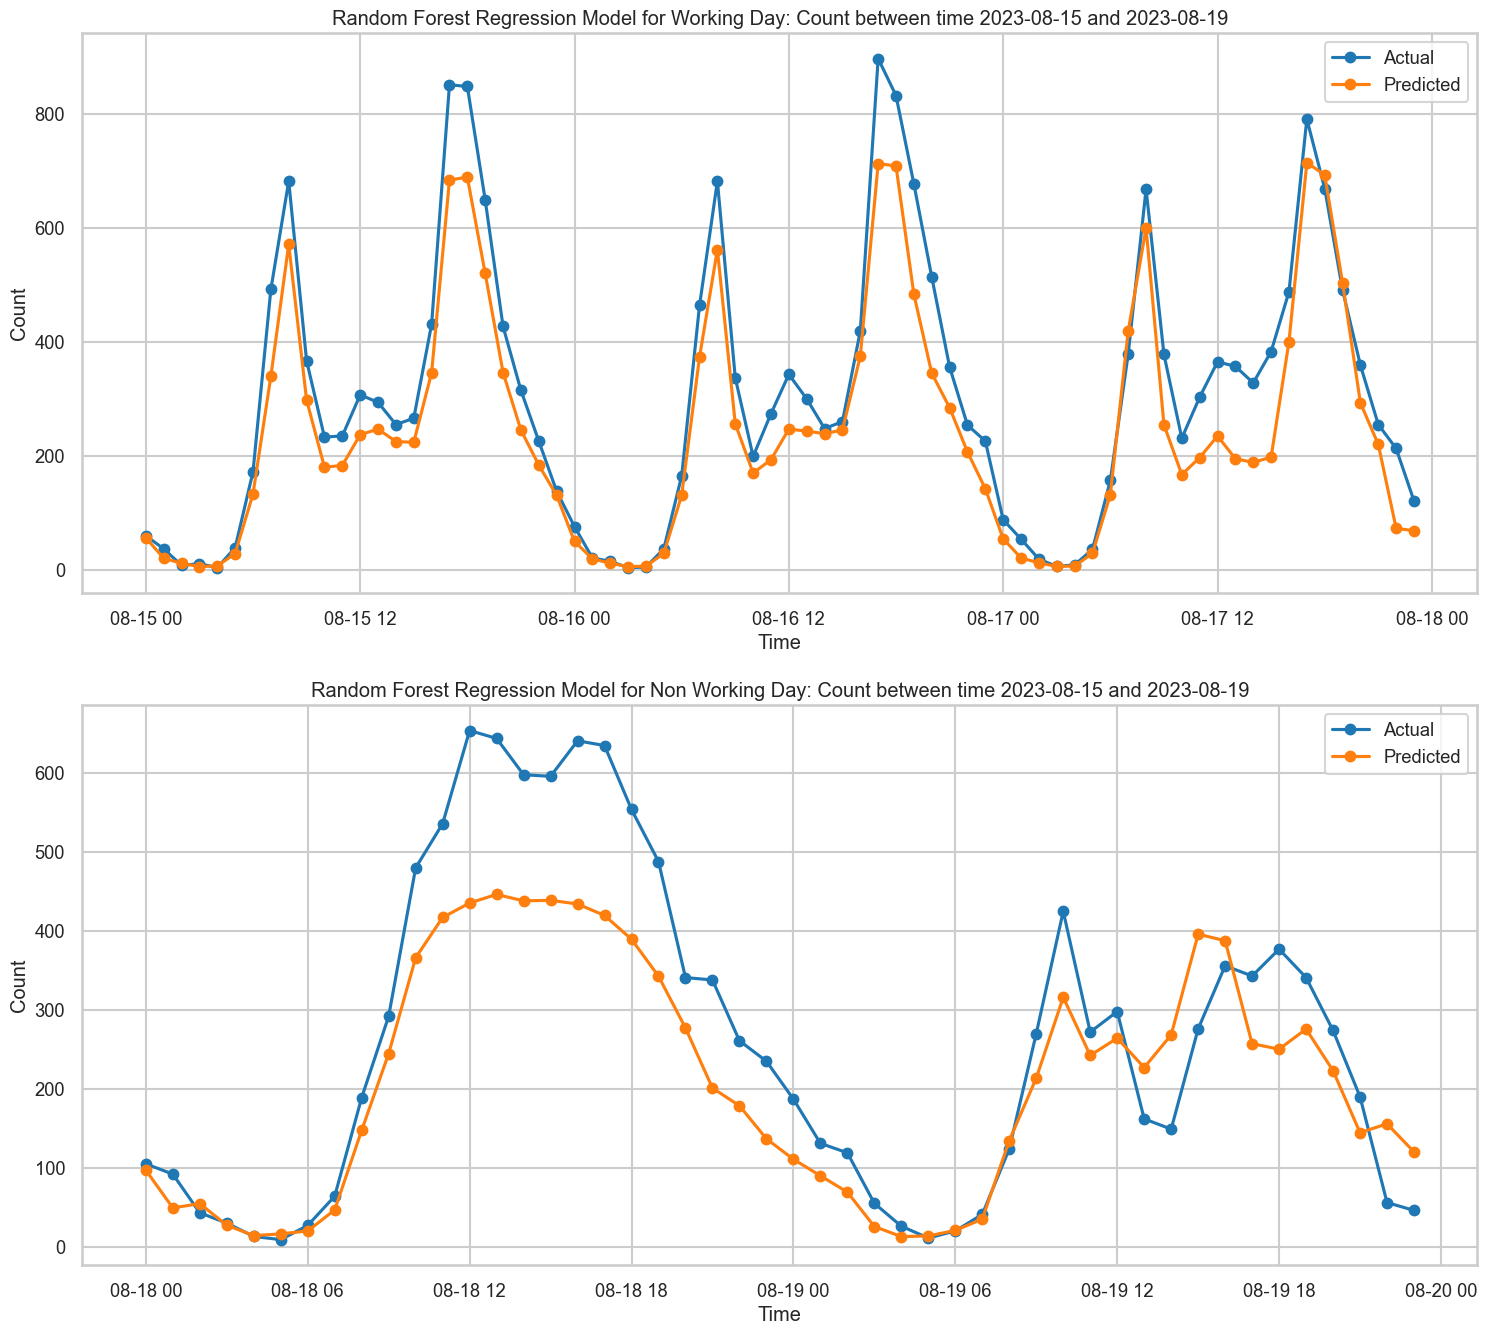

In [80]:
t_from, t_to = '2023-08-15', '2023-08-19'
ytest_w_predict, ytest_nw_predict = y_predict_summary[1], y_predict_summary[3]
ytest_w_predict = pd.Series(ytest_w_predict, index = ytest_w.index)
ytest_nw_predict = pd.Series(ytest_nw_predict, index = ytest_nw.index)

plot_true_vs_pred(ytest_w, ytest_nw, ytest_w_predict, ytest_nw_predict, 'Random Forest Regression', t_from, t_to)

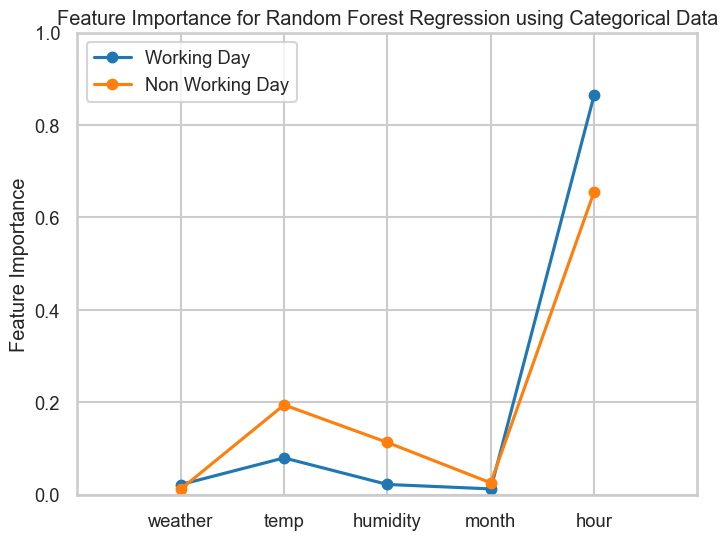

In [81]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(rfc_w.feature_importances_, label='Working Day', marker='.', markersize=15)
axes.plot(rfc_nw.feature_importances_, label='Non Working Day', marker='.', markersize=15)
plt.xticks(range(len(rfc_w.feature_importances_)), X2_w.columns)
axes.set(ylabel='Feature Importance', title='Feature Importance for Random Forest Regression using Categorical Data')
axes.set(xlim=[-1, len(X2_w.columns)], ylim=[0, 1])
axes.legend()

plt.show()

RMSLE score for Random Forest Regressor using a small tree (max_depth = 3) for simple visualization = 0.659


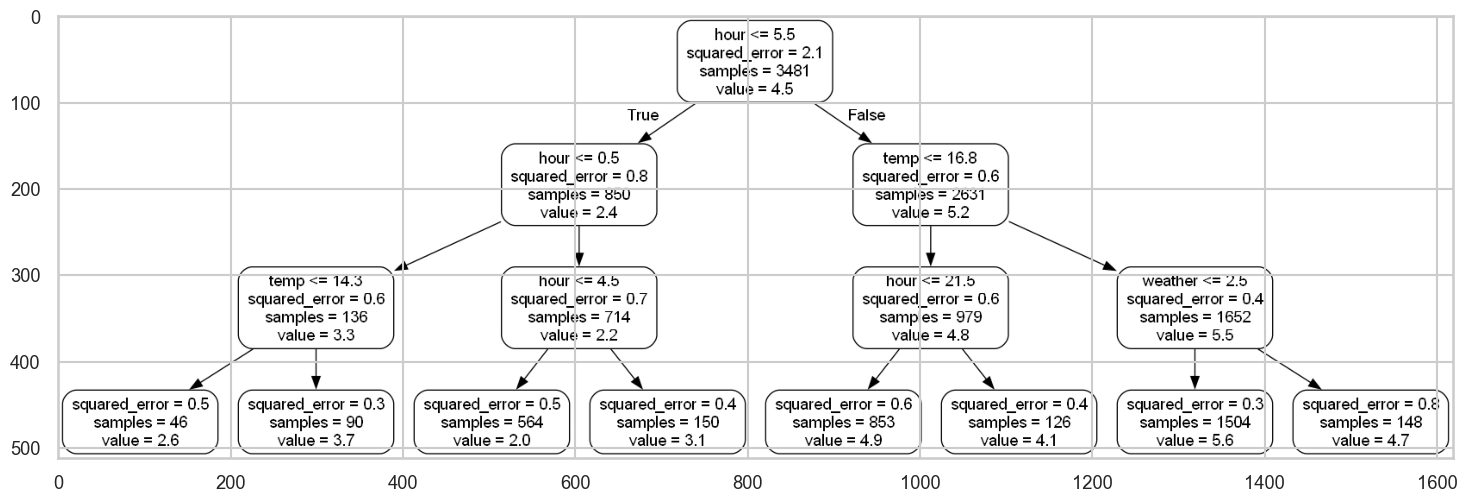

In [82]:
rf_w_small = RandomForestRegressor(n_estimators=10, max_features = 'auto', max_depth=3, random_state=42)
rf_w_small.fit(X2_w, logy2_w)
logy2_w_predict_small = rf_w_small.predict(X2_w)
rmsle2_w_small = rmsle(y2_w, np.expm1(logy2_w_predict_small))
print('RMSLE score for Random Forest Regressor using a small tree (max_depth = 3) for simple visualization = {0:.3f}'.format(rmsle2_w_small))

from sklearn.tree import export_graphviz
import pydot
import matplotlib.image as mpimg

tree = rf_w_small.estimators_[0]

dot_data = export_graphviz(tree, out_file = './Images/tree_rf3.dot', feature_names = X2_w.columns, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('./Images/tree_rf3.dot')

graph.write_png('./Images/tree_rf3.png')

img=mpimg.imread('./Images/tree_rf3.png')
plt.figure(figsize=(18, 12))
imgplot = plt.imshow(img)
plt.show()

In [83]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [84]:
best_max_depth, best_max_features, best_min_samples_leaf = 6, 1.0, 5
best_n_estimators_w, best_learning_rate_w = 3000, 0.01
best_n_estimators_nw, best_learning_rate_nw = 3000, 0.005
param_summary = ['n_estimators: {}, learning_rate: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators_w, best_learning_rate_w, best_max_features, best_min_samples_leaf, best_max_depth), 
                 'n_estimators: {}, learning_rate: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators_nw, best_learning_rate_nw, best_max_features, best_min_samples_leaf, best_max_depth),'']
print('Best parameters via GridSearchCV for Working Day:     '+param_summary[0])
print('Best parameters via GridSearchCV for Non Working Day: '+param_summary[1])

gb_w = GradientBoostingRegressor(n_estimators = best_n_estimators_w, learning_rate = best_learning_rate_w, 
                                 max_depth=best_max_depth, max_features=best_max_features, min_samples_leaf=best_min_samples_leaf, random_state=42)
gb_nw = GradientBoostingRegressor(n_estimators = best_n_estimators_nw, learning_rate = best_learning_rate_nw, 
                                  max_depth=best_max_depth, max_features=best_max_features, min_samples_leaf=best_min_samples_leaf, random_state=42)

rmsle_summary, y_predict_summary = model_fit(gb_w, X_w, Xtest_w, y_w, ytest_w, gb_nw, X_nw, Xtest_nw, y_nw, ytest_nw)
ypred_test.loc[Xtest.workingday==1,'GB1'], ypred_test.loc[Xtest.workingday==0,'GB1'] = y_predict_summary[1], y_predict_summary[3]

Best parameters via GridSearchCV for Working Day:     n_estimators: 3000, learning_rate: 0.01, max_features: 1.0, min_samples_leaf: 5, max_depth: 6
Best parameters via GridSearchCV for Non Working Day: n_estimators: 3000, learning_rate: 0.005, max_features: 1.0, min_samples_leaf: 5, max_depth: 6


In [85]:
rmsle_val_summary, y_predict_val_summary = cross_val(gb_w, X_w, y_w, gb_nw, X_nw, y_nw)
ypred_train.loc[X.workingday==1,'GB1'], ypred_train.loc[X.workingday==0,'GB1'] = y_predict_val_summary[0], y_predict_val_summary[1]

algo_score.loc['Gradient Boosting-OneHotEncoding'] = rmsle_summary+rmsle_val_summary+param_summary
algo_score.loc[['Gradient Boosting-OneHotEncoding']]

Train RMSLE (Working Day)  \
Modelling Algo                                                
Gradient Boosting-OneHotEncoding                   0.289375   

                                  Train RMSLE (Non Working Day)  \
Modelling Algo                                                    
Gradient Boosting-OneHotEncoding                        0.31078   

                                  Train RMSLE (Average)  \
Modelling Algo                                            
Gradient Boosting-OneHotEncoding               0.296239   

                                  Test RMSLE (Working Day)  \
Modelling Algo                                               
Gradient Boosting-OneHotEncoding                   0.41517   

                                  Test RMSLE (Non Working Day)  \
Modelling Algo                                                   
Gradient Boosting-OneHotEncoding                      0.574037   

                                  Test RMSLE (Average)  \
Modelling Algo                                           
Gradient Boosting-OneHotEncoding              0.474369   

                                  Validation RMSLE (Working Day)  \
Modelling Algo                                                     
Gradient Boosting-OneHotEncoding                        0.513597   

                                  Validation RMSLE (Non Working Day)  \
Modelling Algo                                                         
Gradient Boosting-OneHotEncoding                             0.61457   

                                  Validation RMSLE (Average)  \
Modelling Algo                                                 
Gradient Boosting-OneHotEncoding                      0.5472   

                                                            Hyperparameters-Working  \
Modelling Algo                                                                        
Gradient Boosting-OneHotEncoding  n_estimators: 3000, learning_rate: 0.01, max_f...   

                                                        Hyperparameters-Non Working  \
Modelling Algo                                                                        
Gradient Boosting-OneHotEncoding  n_estimators: 3000, learning_rate: 0.005, max_...   

                                 Training+Test Time (sec)  
Modelling Algo                                             
Gradient Boosting-OneHotEncoding

In [86]:
algo_score.loc['Gradient Boosting-OneHotEncoding', 'Training+Test Time (sec)'] = 42.9
cv_time.append(210)

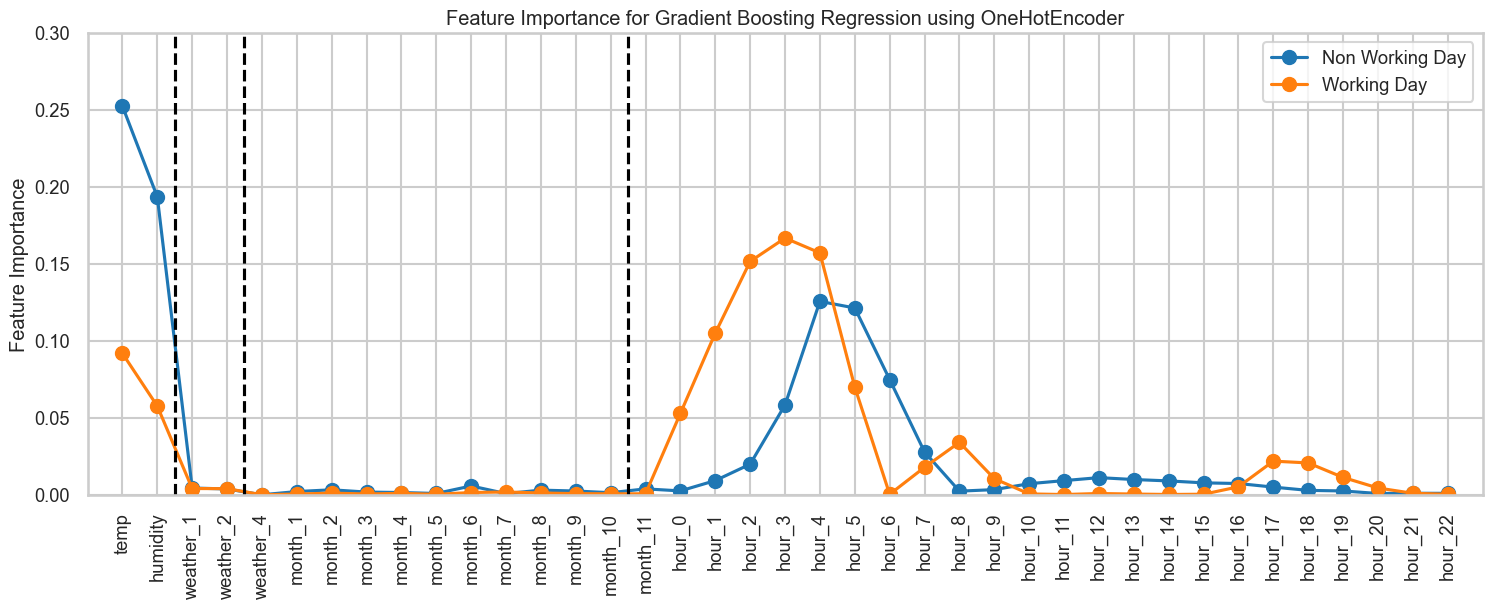

In [87]:
fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(gb_nw.feature_importances_, label='Non Working Day', marker='.', markersize=20)
axes.plot(gb_w.feature_importances_, label='Working Day', marker='.', markersize=20)
plt.xticks(range(len(gb_w.feature_importances_)), X_w.columns, rotation=90)
axes.axvline(2-0.5, c='k', ls='--')
axes.axvline(4-0.5,  c='k', ls='--')
axes.axvline(15-0.5,  c='k', ls='--')
axes.set(ylabel='Feature Importance', title='Feature Importance for Gradient Boosting Regression using OneHotEncoder')
axes.set(xlim=[-1, len(X_w.columns)], ylim=[0, 0.3])
axes.legend()

plt.show()

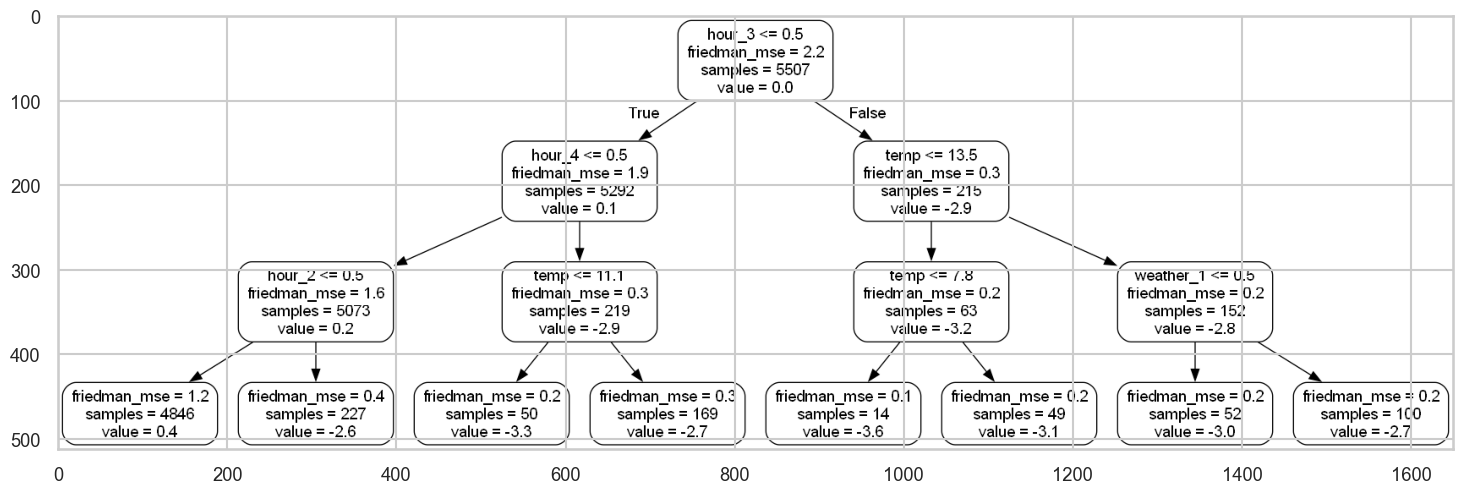

In [88]:
from sklearn.tree import export_graphviz
import pydot
import matplotlib.image as mpimg

gb_w_small = GradientBoostingRegressor(n_estimators = best_n_estimators_w, learning_rate = best_learning_rate_w, max_depth=3, random_state=42)
gb_w_small.fit(X_w, logy_w)

tree = gb_w_small.estimators_[0][0]

dot_data = export_graphviz(tree, out_file = './Images/tree_gb1.dot', feature_names = X_w.columns, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('./Images/tree_gb1.dot')

graph.write_png('./Images/tree_gb1.png')

img=mpimg.imread('./Images/tree_gb1.png')
plt.figure(figsize=(18, 12))
imgplot = plt.imshow(img)
plt.show()

In [89]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [90]:
best_max_depth, best_max_features, best_min_samples_leaf = 4, 1.0, 21
best_n_estimators_w, best_learning_rate_w = 3000, 0.01
best_n_estimators_nw, best_learning_rate_nw = 3000, 0.005
param_summary = ['n_estimators: {}, learning_rate: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators_w, best_learning_rate_w, best_max_features, best_min_samples_leaf, best_max_depth), 
                 'n_estimators: {}, learning_rate: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators_nw, best_learning_rate_nw, best_max_features, best_min_samples_leaf, best_max_depth),'']
print('Best parameters via GridSearchCV for Working Day:     '+param_summary[0])
print('Best parameters via GridSearchCV for Non Working Day: '+param_summary[1])

gb2_w = GradientBoostingRegressor(n_estimators = best_n_estimators_w, learning_rate = best_learning_rate_w, 
                                 max_depth=best_max_depth, max_features=best_max_features, min_samples_leaf=best_min_samples_leaf, random_state=42)
gb2_nw = GradientBoostingRegressor(n_estimators = best_n_estimators_nw, learning_rate = best_learning_rate_nw, 
                                  max_depth=best_max_depth, max_features=best_max_features, min_samples_leaf=best_min_samples_leaf, random_state=42)

rmsle_summary, y_predict_summary = model_fit(gb2_w, X2_w, Xtest2_w, y2_w, ytest2_w, gb2_nw, X2_nw, Xtest2_nw, y2_nw, ytest2_nw)
ypred_test.loc[Xtest2.workingday==1,'GB2'], ypred_test.loc[Xtest2.workingday==0,'GB2'] = y_predict_summary[1], y_predict_summary[3]

Best parameters via GridSearchCV for Working Day:     n_estimators: 3000, learning_rate: 0.01, max_features: 1.0, min_samples_leaf: 21, max_depth: 4
Best parameters via GridSearchCV for Non Working Day: n_estimators: 3000, learning_rate: 0.005, max_features: 1.0, min_samples_leaf: 21, max_depth: 4


In [91]:
rmsle_val_summary, y_predict_val_summary = cross_val(gb2_w, X2_w, y2_w, gb2_nw, X2_nw, y2_nw)
ypred_train.loc[X2.workingday==1,'GB2'], ypred_train.loc[X2.workingday==0,'GB2'] = y_predict_val_summary[0], y_predict_val_summary[1]

algo_score.loc['Gradient Boosting-Categorical Features'] = rmsle_summary+rmsle_val_summary+param_summary
algo_score.loc[['Gradient Boosting-Categorical Features']]

Train RMSLE (Working Day)  \
Modelling Algo                                                      
Gradient Boosting-Categorical Features                   0.340912   

                                        Train RMSLE (Non Working Day)  \
Modelling Algo                                                          
Gradient Boosting-Categorical Features                       0.348996   

                                        Train RMSLE (Average)  \
Modelling Algo                                                  
Gradient Boosting-Categorical Features               0.343462   

                                        Test RMSLE (Working Day)  \
Modelling Algo                                                     
Gradient Boosting-Categorical Features                   0.39084   

                                        Test RMSLE (Non Working Day)  \
Modelling Algo                                                         
Gradient Boosting-Categorical Features                      0.533038   

                                        Test RMSLE (Average)  \
Modelling Algo                                                 
Gradient Boosting-Categorical Features              0.443595   

                                        Validation RMSLE (Working Day)  \
Modelling Algo                                                           
Gradient Boosting-Categorical Features                        0.516378   

                                        Validation RMSLE (Non Working Day)  \
Modelling Algo                                                               
Gradient Boosting-Categorical Features                            0.614895   

                                        Validation RMSLE (Average)  \
Modelling Algo                                                       
Gradient Boosting-Categorical Features                    0.549109   

                                                                  Hyperparameters-Working  \
Modelling Algo                                                                              
Gradient Boosting-Categorical Features  n_estimators: 3000, learning_rate: 0.01, max_f...   

                                                              Hyperparameters-Non Working  \
Modelling Algo                                                                              
Gradient Boosting-Categorical Features  n_estimators: 3000, learning_rate: 0.005, max_...   

                                       Training+Test Time (sec)  
Modelling Algo                                                   
Gradient Boosting-Categorical Features

In [92]:
algo_score.loc['Gradient Boosting-Categorical Features', 'Training+Test Time (sec)'] = 10.1
cv_time.append(42.6)

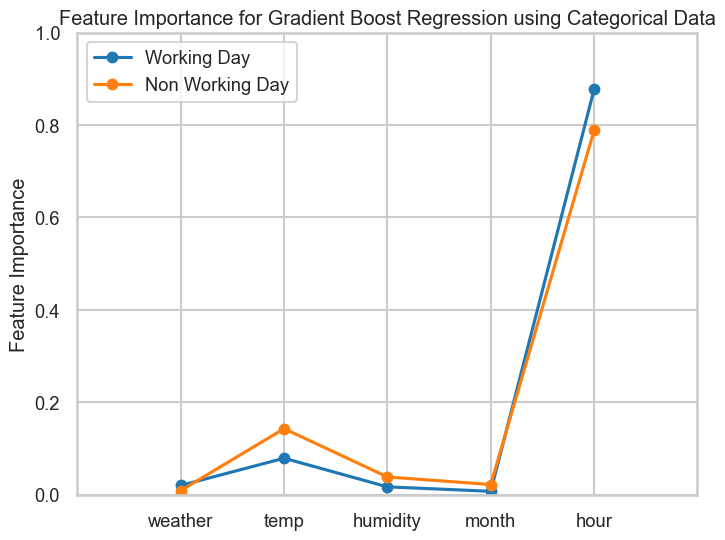

In [93]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(gb2_w.feature_importances_, label='Working Day', marker='.', markersize=15)
axes.plot(gb2_nw.feature_importances_, label='Non Working Day', marker='.', markersize=15)
plt.xticks(range(len(gb2_w.feature_importances_)), X2_w.columns)
axes.set(ylabel='Feature Importance', title='Feature Importance for Gradient Boost Regression using Categorical Data')
axes.set(xlim=[-1, len(X2_w.columns)], ylim=[0, 1])
axes.legend()

plt.show()

In [94]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

In [95]:
best_n_estimators_w, best_learning_rate_w = 5000, 0.001
best_n_estimators_nw, best_learning_rate_nw = 5000, 0.001
param_summary = ['n_estimators: {}, learning_rate: {}'.format(best_n_estimators_w, best_learning_rate_w), 
                 'n_estimators: {}, learning_rate: {}'.format(best_n_estimators_nw, best_learning_rate_nw),'']
print('Best parameters via GridSearchCV for Working Day:     '+param_summary[0])
print('Best parameters via GridSearchCV for Non Working Day: '+param_summary[1])

ab_w = AdaBoostRegressor(n_estimators = best_n_estimators_w, learning_rate = best_learning_rate_w, random_state=42)
ab_nw = AdaBoostRegressor(n_estimators = best_n_estimators_nw, learning_rate = best_learning_rate_nw, random_state=42)

rmsle_summary, y_predict_summary = model_fit(ab_w, X2_w, Xtest2_w, y2_w, ytest2_w, ab_nw, X2_nw, Xtest2_nw, y2_nw, ytest2_nw)
ypred_test.loc[Xtest2.workingday==1,'AB'], ypred_test.loc[Xtest2.workingday==0,'AB'] = y_predict_summary[1], y_predict_summary[3]

Best parameters via GridSearchCV for Working Day:     n_estimators: 5000, learning_rate: 0.001
Best parameters via GridSearchCV for Non Working Day: n_estimators: 5000, learning_rate: 0.001


In [96]:
rmsle_val_summary, y_predict_val_summary = cross_val(ab_w, X2_w, y2_w, ab_nw, X2_nw, y2_nw)
ypred_train.loc[X2.workingday==1,'AB'], ypred_train.loc[X2.workingday==0,'AB'] = y_predict_val_summary[0], y_predict_val_summary[1]

algo_score.loc['AdaBoost-OneHotEncoding'] = rmsle_summary+rmsle_val_summary+param_summary
algo_score.loc[['AdaBoost-OneHotEncoding']]

Train RMSLE (Working Day)  \
Modelling Algo                                       
AdaBoost-OneHotEncoding                   0.621062   

                         Train RMSLE (Non Working Day)  Train RMSLE (Average)  \
Modelling Algo                                                                  
AdaBoost-OneHotEncoding                       0.581618               0.608994   

                         Test RMSLE (Working Day)  \
Modelling Algo                                      
AdaBoost-OneHotEncoding                  0.597872   

                         Test RMSLE (Non Working Day)  Test RMSLE (Average)  \
Modelling Algo                                                                
AdaBoost-OneHotEncoding                       0.61744              0.604499   

                         Validation RMSLE (Working Day)  \
Modelling Algo                                            
AdaBoost-OneHotEncoding                         0.69716   

                         Validation RMSLE (Non Working Day)  \
Modelling Algo                                                
AdaBoost-OneHotEncoding                            0.730577   

                         Validation RMSLE (Average)  \
Modelling Algo                                        
AdaBoost-OneHotEncoding                    0.707786   

                                          Hyperparameters-Working  \
Modelling Algo                                                      
AdaBoost-OneHotEncoding  n_estimators: 5000, learning_rate: 0.001   

                                      Hyperparameters-Non Working  \
Modelling Algo                                                      
AdaBoost-OneHotEncoding  n_estimators: 5000, learning_rate: 0.001   

                        Training+Test Time (sec)  
Modelling Algo                                    
AdaBoost-OneHotEncoding

In [97]:
algo_score.loc['AdaBoost-OneHotEncoding', 'Training+Test Time (sec)'] = 59.2
cv_time.append(198)

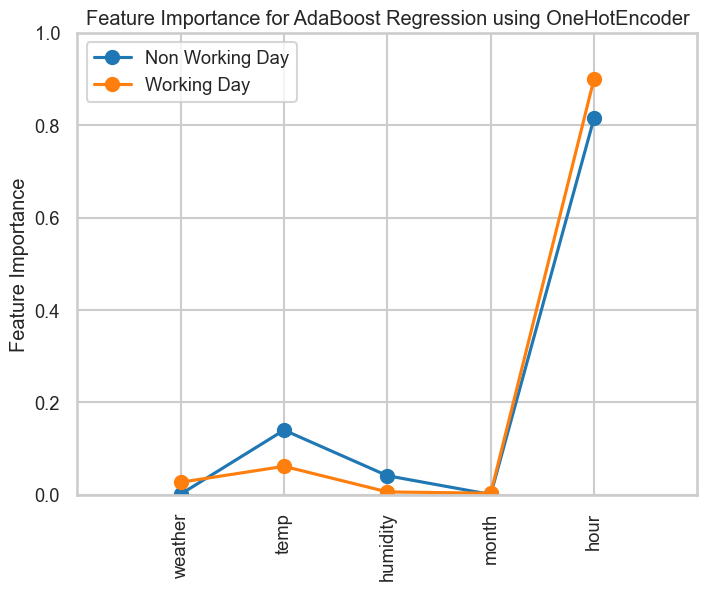

In [98]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(ab_nw.feature_importances_, label='Non Working Day', marker='.', markersize=20)
axes.plot(ab_w.feature_importances_, label='Working Day', marker='.', markersize=20)
plt.xticks(range(len(ab_w.feature_importances_)), X2_w.columns, rotation=90)
axes.set(ylabel='Feature Importance', title='Feature Importance for AdaBoost Regression using OneHotEncoder')
axes.set(xlim=[-1, len(X2_w.columns)], ylim=[0, 1])
axes.legend()

plt.show()

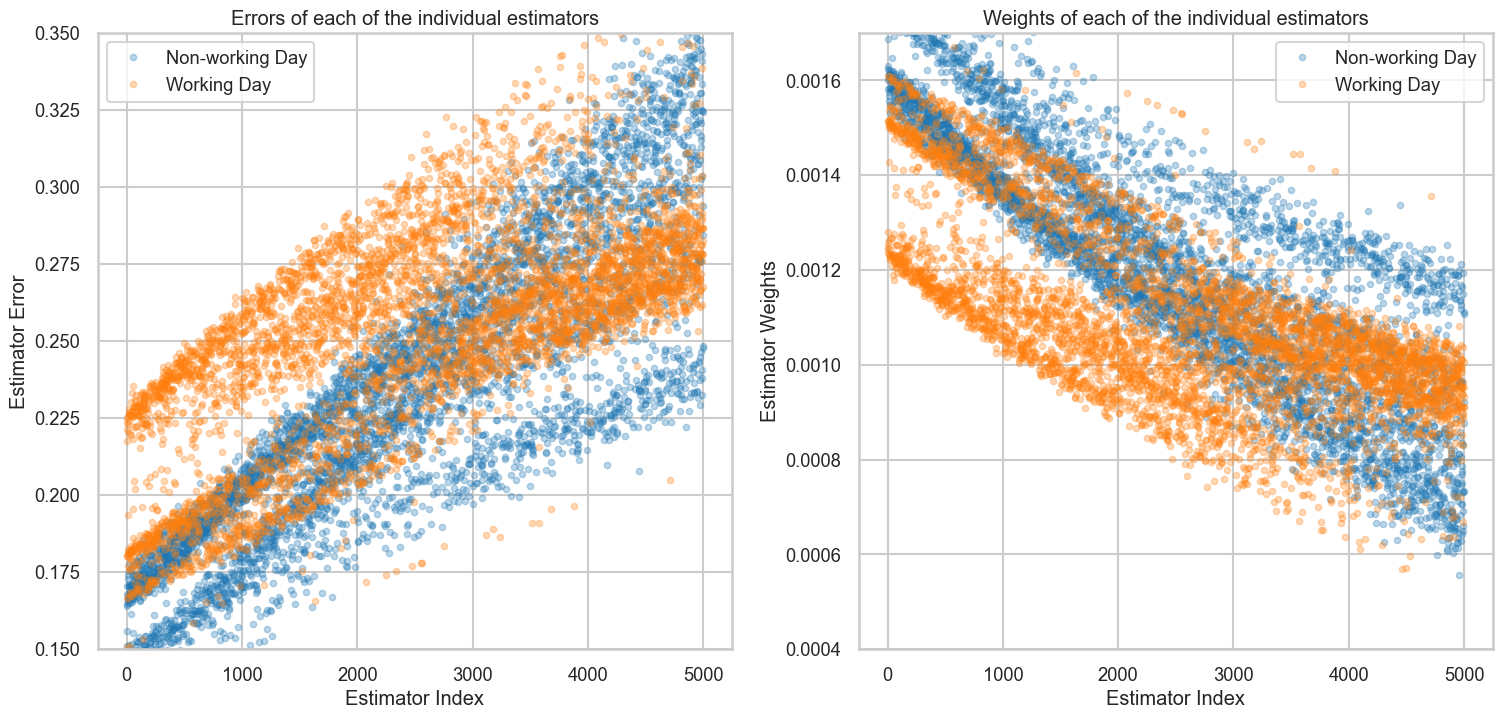

In [99]:
fig = plt.figure(figsize=(18, 8))

axes = fig.add_subplot(1, 2, 1)
axes.plot(ab_nw.estimator_errors_, linestyle='None', marker='.', alpha=0.3, label = 'Non-working Day')
axes.plot(ab_w.estimator_errors_, linestyle='None', marker='.', alpha=0.3, label='Working Day')
axes.set(xlabel='Estimator Index', ylabel='Estimator Error', title='Errors of each of the individual estimators')
axes.set(ylim=[0.15, 0.35])
axes.legend()

axes = fig.add_subplot(1, 2, 2)
axes.plot(ab_nw.estimator_weights_, linestyle='None', marker='.', alpha=0.3, label = 'Non-working Day')
axes.plot(ab_w.estimator_weights_, linestyle='None', marker='.', alpha=0.3, label = 'Working Day')
axes.set(xlabel='Estimator Index', ylabel='Estimator Weights', title='Weights of each of the individual estimators')
axes.set(ylim=[0.0004, 0.0017])
axes.legend()
plt.show()

### Preparing data for Stacking

In [100]:
X_stack, Xtest_stack = ypred_train.drop('count', axis=1), ypred_test.drop('count', axis=1)
y_stack, ytest_stack = ypred_train['count'], ypred_test['count']

Applying Linear Regression Modeling..

In [101]:
param_summary = ['', '', '']

lr_stack = LinearRegression()
rmsle_summary, y_predict_summary = stack_model_fit(lr_stack, X_stack, Xtest_stack, y_stack, ytest_stack)
rmsle_val_summary = ['', '', '']

algo_score.loc['Stacking-LR'] = rmsle_summary+rmsle_val_summary+param_summary
algo_score.loc[['Stacking-LR']]

Train RMSLE (Working Day)  Train RMSLE (Non Working Day)  \
Modelling Algo                                                             
Stacking-LR                      0.643981                       0.654926   

                Train RMSLE (Average)  Test RMSLE (Working Day)  \
Modelling Algo                                                    
Stacking-LR                  0.647426                  0.564394   

                Test RMSLE (Non Working Day)  Test RMSLE (Average)  \
Modelling Algo                                                       
Stacking-LR                         0.605618              0.578535   

               Validation RMSLE (Working Day)  \
Modelling Algo                                  
Stacking-LR                                     

               Validation RMSLE (Non Working Day) Validation RMSLE (Average)  \
Modelling Algo                                                                 
Stacking-LR                                                                    

               Hyperparameters-Working Hyperparameters-Non Working  \
Modelling Algo                                                       
Stacking-LR                                                          

               Training+Test Time (sec)  
Modelling Algo                           
Stacking-LR

In [102]:
algo_score.loc['Stacking-LR', 'Training+Test Time (sec)'] = sum(cv_time) +0.198

Lets take a look at the coefficients obtained for the Linear Regression Model

In [103]:
df_stack_coeff = pd.DataFrame({'Individual Models': X_stack.columns, 'LR Coeff': lr_stack.coef_})
print('Sum of Coeff: ', lr_stack.coef_.sum())

Sum of Coeff:  0.9782341565969199


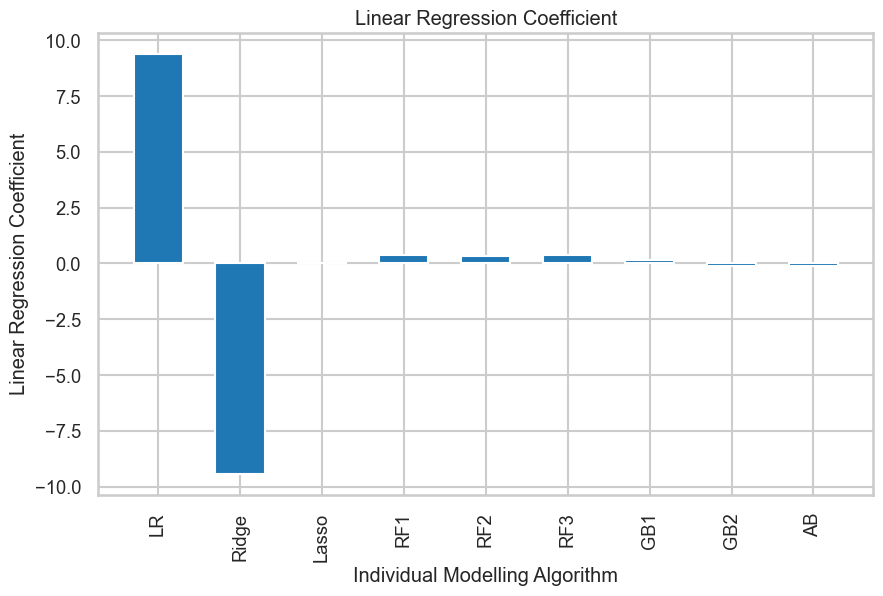

In [104]:
fig=plt.figure(figsize=(10, 6))
axes=fig.add_subplot(1, 1, 1)
bar_width = 0.6
idx = np.array(range(len(lr_stack.coef_)))
labels = X_stack.columns
plt.bar(height=lr_stack.coef_, x=idx, width=bar_width)
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Individual Modelling Algorithm')
plt.ylabel('Linear Regression Coefficient')
plt.title('Linear Regression Coefficient')

plt.show()


In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [106]:
best_n_estimators, best_max_features = 1000, 'sqrt'
best_min_samples_leaf, best_max_depth = 100, 5
param_summary = ['n_estimators: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators, best_max_features, best_min_samples_leaf, best_max_depth), 
                 'n_estimators: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators, best_max_features, best_min_samples_leaf, best_max_depth),'']

rf_stack = RandomForestRegressor(n_estimators = best_n_estimators, max_features = best_max_features, 
                                 min_samples_leaf = best_min_samples_leaf, max_depth = best_max_depth, random_state=42)

rmsle_summary, y_predict_summary = stack_model_fit(rf_stack, X_stack, Xtest_stack, y_stack, ytest_stack)
rmsle_val_summary = ['', '', '']

algo_score.loc['Stacking-RF'] = rmsle_summary+rmsle_val_summary+param_summary
algo_score.loc[['Stacking-RF']]

Train RMSLE (Working Day)  Train RMSLE (Non Working Day)  \
Modelling Algo                                                             
Stacking-RF                       0.50013                        0.58276   

                Train RMSLE (Average)  Test RMSLE (Working Day)  \
Modelling Algo                                                    
Stacking-RF                   0.52738                  0.416646   

                Test RMSLE (Non Working Day)  Test RMSLE (Average)  \
Modelling Algo                                                       
Stacking-RF                         0.526738              0.456503   

               Validation RMSLE (Working Day)  \
Modelling Algo                                  
Stacking-RF                                     

               Validation RMSLE (Non Working Day) Validation RMSLE (Average)  \
Modelling Algo                                                                 
Stacking-RF                                                                    

                                          Hyperparameters-Working  \
Modelling Algo                                                      
Stacking-RF     n_estimators: 1000, max_features: sqrt, min_sa...   

                                      Hyperparameters-Non Working  \
Modelling Algo                                                      
Stacking-RF     n_estimators: 1000, max_features: sqrt, min_sa...   

               Training+Test Time (sec)  
Modelling Algo                           
Stacking-RF

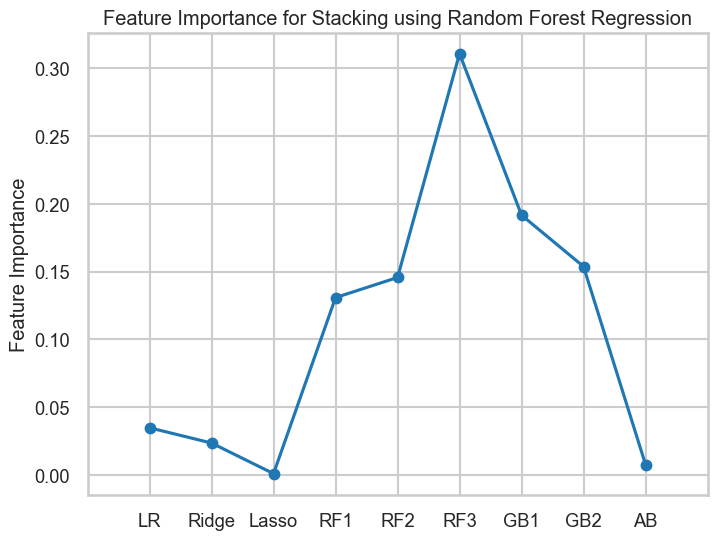

In [107]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(rf_stack.feature_importances_, marker='.', markersize=15)
plt.xticks(range(len(rf_stack.feature_importances_)), X_stack.columns)
axes.set(ylabel='Feature Importance', title='Feature Importance for Stacking using Random Forest Regression')
axes.set(xlim=[-1, len(X_stack.columns)])

plt.show()

In [108]:
algo_score.loc['Stacking-RF', 'Training+Test Time (sec)'] = sum(cv_time)+9.13

In [109]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [110]:
best_max_depth, best_max_features, best_min_samples_leaf = 4, 0.3, 100
best_n_estimators, best_learning_rate = 3000, 0.01

param_summary = ['n_estimators: {}, learning_rate: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators, best_learning_rate, best_max_features, best_min_samples_leaf, best_max_depth), 
                 'n_estimators: {}, learning_rate: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators, best_learning_rate, best_max_features, best_min_samples_leaf, best_max_depth),'']

gb_stack = GradientBoostingRegressor(n_estimators = best_n_estimators, learning_rate = best_learning_rate, 
                                 max_depth=best_max_depth, max_features=best_max_features, min_samples_leaf=best_min_samples_leaf, random_state=42)

rmsle_summary, y_predict_summary = stack_model_fit(gb_stack, X_stack, Xtest_stack, y_stack, ytest_stack)
rmsle_val_summary = ['', '', '']

algo_score.loc['Stacking-GB'] = rmsle_summary+rmsle_val_summary+param_summary
algo_score.loc[['Stacking-GB']]


Train RMSLE (Working Day)  Train RMSLE (Non Working Day)  \
Modelling Algo                                                             
Stacking-GB                      0.461375                       0.548134   

                Train RMSLE (Average)  Test RMSLE (Working Day)  \
Modelling Algo                                                    
Stacking-GB                  0.490177                  0.430291   

                Test RMSLE (Non Working Day)  Test RMSLE (Average)  \
Modelling Algo                                                       
Stacking-GB                         0.530244              0.466177   

               Validation RMSLE (Working Day)  \
Modelling Algo                                  
Stacking-GB                                     

               Validation RMSLE (Non Working Day) Validation RMSLE (Average)  \
Modelling Algo                                                                 
Stacking-GB                                                                    

                                          Hyperparameters-Working  \
Modelling Algo                                                      
Stacking-GB     n_estimators: 3000, learning_rate: 0.01, max_f...   

                                      Hyperparameters-Non Working  \
Modelling Algo                                                      
Stacking-GB     n_estimators: 3000, learning_rate: 0.01, max_f...   

               Training+Test Time (sec)  
Modelling Algo                           
Stacking-GB

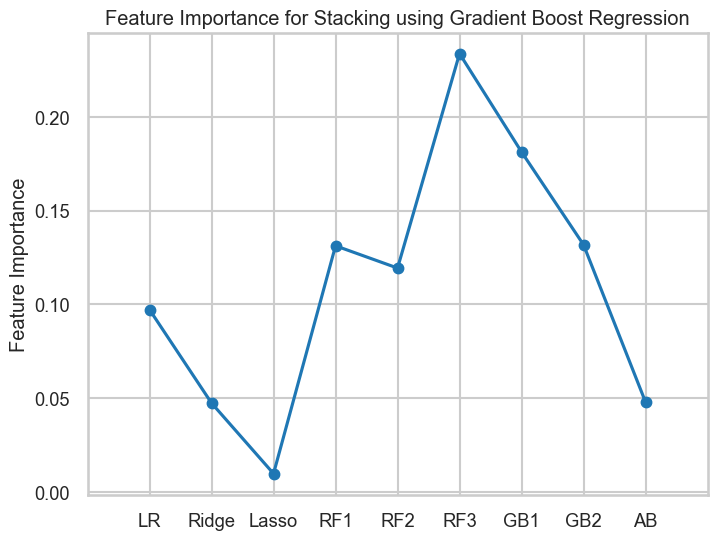

In [111]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(gb_stack.feature_importances_, marker='.', markersize=15)
plt.xticks(range(len(gb_stack.feature_importances_)), X_stack.columns)
axes.set(ylabel='Feature Importance', title='Feature Importance for Stacking using Gradient Boost Regression')
axes.set(xlim=[-1, len(X_stack.columns)])

plt.show()

In [112]:
algo_score.loc['Stacking-GB', 'Training+Test Time (sec)'] = sum(cv_time)+8.12

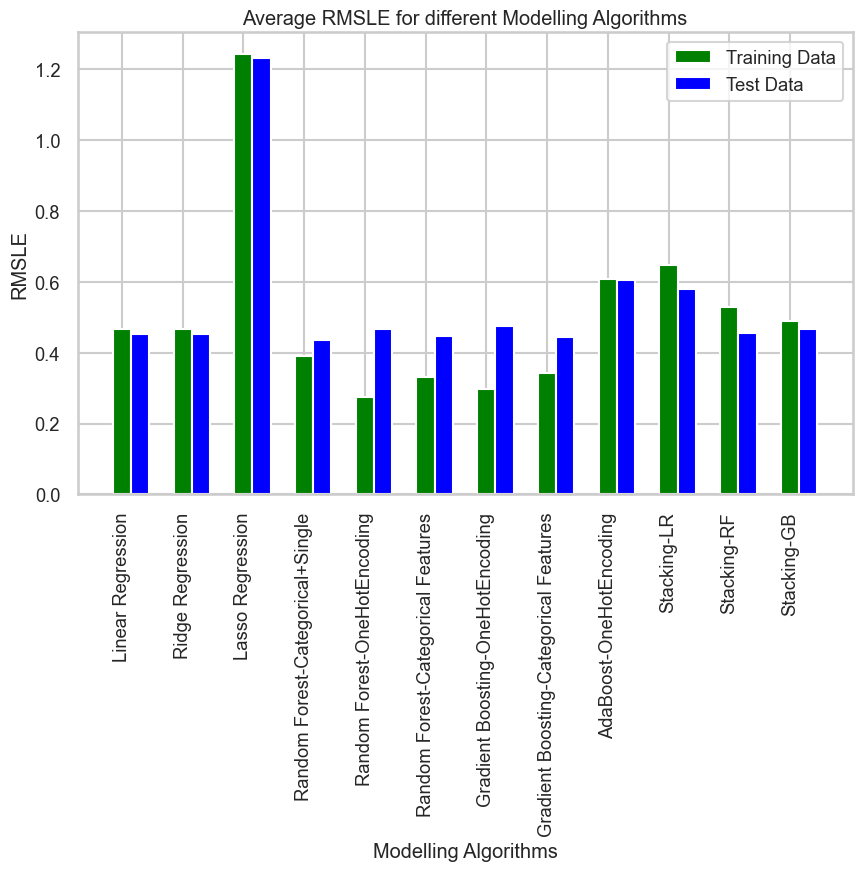

In [113]:
fig=plt.figure(figsize=(10, 6))
axes=fig.add_subplot(1, 1, 1)
bar_width = 0.3
idx = np.array(range(algo_score.shape[0]))
labels = algo_score.index
plt.bar(data=algo_score, height='Train RMSLE (Average)', x=idx, color='g', width=bar_width, label='Training Data')
plt.bar(data=algo_score, height='Test RMSLE (Average)', x=idx+bar_width, color='b', width=bar_width, label='Test Data')
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Modelling Algorithms')
plt.ylabel('RMSLE')
plt.title('Average RMSLE for different Modelling Algorithms')
plt.legend()
plt.show()

In [114]:
algo_score

Train RMSLE (Working Day)  \
Modelling Algo                                                      
Linear Regression                                        0.453983   
Ridge Regression                                         0.453984   
Lasso Regression                                         1.313353   
Random Forest-Categorical+Single                         0.375150   
Random Forest-OneHotEncoding                             0.192137   
Random Forest-Categorical Features                       0.307955   
Gradient Boosting-OneHotEncoding                         0.289375   
Gradient Boosting-Categorical Features                   0.340912   
AdaBoost-OneHotEncoding                                  0.621062   
Stacking-LR                                              0.643981   
Stacking-RF                                              0.500130   
Stacking-GB                                              0.461375   

                                        Train RMSLE (Non Working Day)  \
Modelling Algo                                                          
Linear Regression                                            0.496261   
Ridge Regression                                             0.496327   
Lasso Regression                                             1.065252   
Random Forest-Categorical+Single                             0.423445   
Random Forest-OneHotEncoding                                 0.401101   
Random Forest-Categorical Features                           0.376976   
Gradient Boosting-OneHotEncoding                             0.310780   
Gradient Boosting-Categorical Features                       0.348996   
AdaBoost-OneHotEncoding                                      0.581618   
Stacking-LR                                                  0.654926   
Stacking-RF                                                  0.582760   
Stacking-GB                                                  0.548134   

                                        Train RMSLE (Average)  \
Modelling Algo                                                  
Linear Regression                                    0.467624   
Ridge Regression                                     0.467646   
Lasso Regression                                     1.241062   
Random Forest-Categorical+Single                     0.390904   
Random Forest-OneHotEncoding                         0.275149   
Random Forest-Categorical Features                   0.331103   
Gradient Boosting-OneHotEncoding                     0.296239   
Gradient Boosting-Categorical Features               0.343462   
AdaBoost-OneHotEncoding                              0.608994   
Stacking-LR                                          0.647426   
Stacking-RF                                          0.527380   
Stacking-GB                                          0.490177   

                                        Test RMSLE (Working Day)  \
Modelling Algo                                                     
Linear Regression                                       0.412354   
Ridge Regression                                        0.412324   
Lasso Regression                                        1.285346   
Random Forest-Categorical+Single                        0.402572   
Random Forest-OneHotEncoding                            0.416997   
Random Forest-Categorical Features                      0.403613   
Gradient Boosting-OneHotEncoding                        0.415170   
Gradient Boosting-Categorical Features                  0.390840   
AdaBoost-OneHotEncoding                                 0.597872   
Stacking-LR                                             0.564394   
Stacking-RF                                             0.416646   
Stacking-GB                                             0.430291   

                                        Test RMSLE (Non Working Day)  \
Modelling Algo                                                         
Linear Regression                         

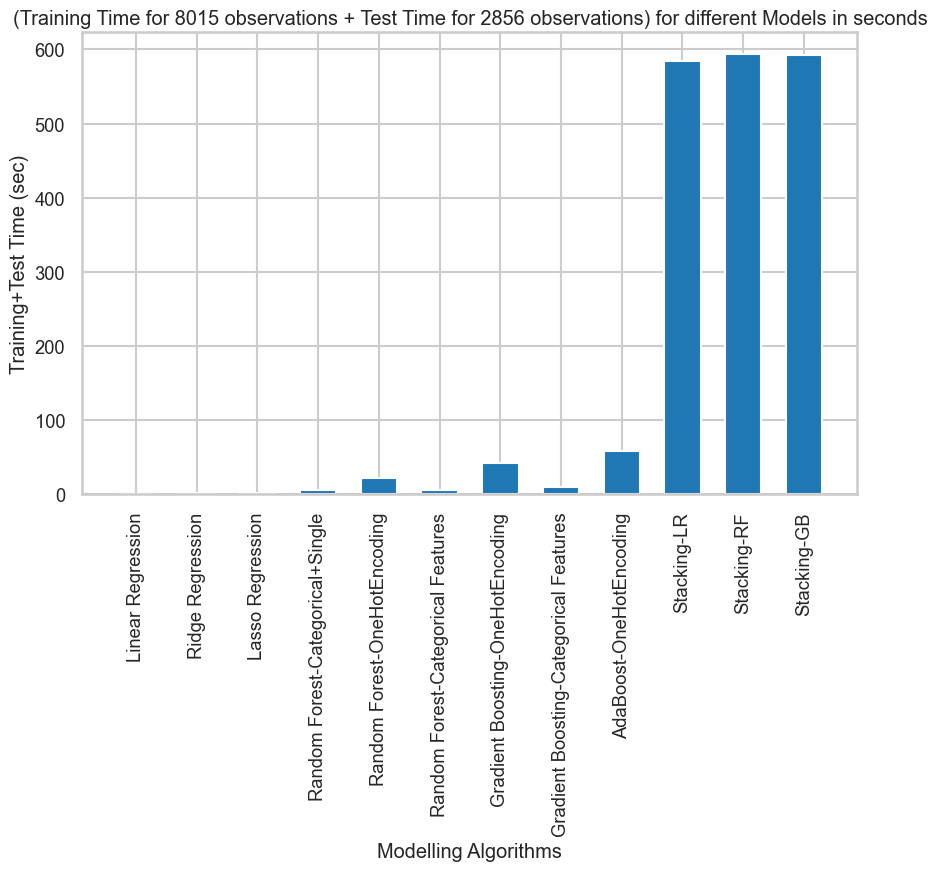

In [115]:
fig=plt.figure(figsize=(10, 6))
axes=fig.add_subplot(1, 1, 1)
bar_width = 0.6
idx = np.array(range(algo_score.shape[0]))
labels = algo_score.index
plt.bar(data=algo_score, height='Training+Test Time (sec)', x=idx, width=bar_width)
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Modelling Algorithms')
plt.ylabel('Training+Test Time (sec)')
plt.title('(Training Time for 8015 observations + Test Time for 2856 observations) for different Models in seconds')
#axes.set_yscale('log')
plt.show()

In [116]:
Xtrain = mydata_without_outliers.drop('count', axis=1)
ytrain = mydata_without_outliers['count']
logytrain = np.log1p(ytrain)

best_n_estimators, best_max_features = 500, 'auto'
best_min_samples_leaf, best_max_depth = 7, 10

rf_main = RandomForestRegressor(n_estimators = best_n_estimators, max_features = best_max_features, 
                                min_samples_leaf = best_min_samples_leaf, max_depth = best_max_depth, random_state=42)
rf_main.fit(Xtrain, logytrain)
logytest_predict = rf_main.predict(testdata)
ytest_predict = np.expm1(logytest_predict)

submission = pd.DataFrame({'datetime':testdata.index, 'count':ytest_predict})
submission.to_csv('./Data/bikeSharing_submission.csv', index=False)

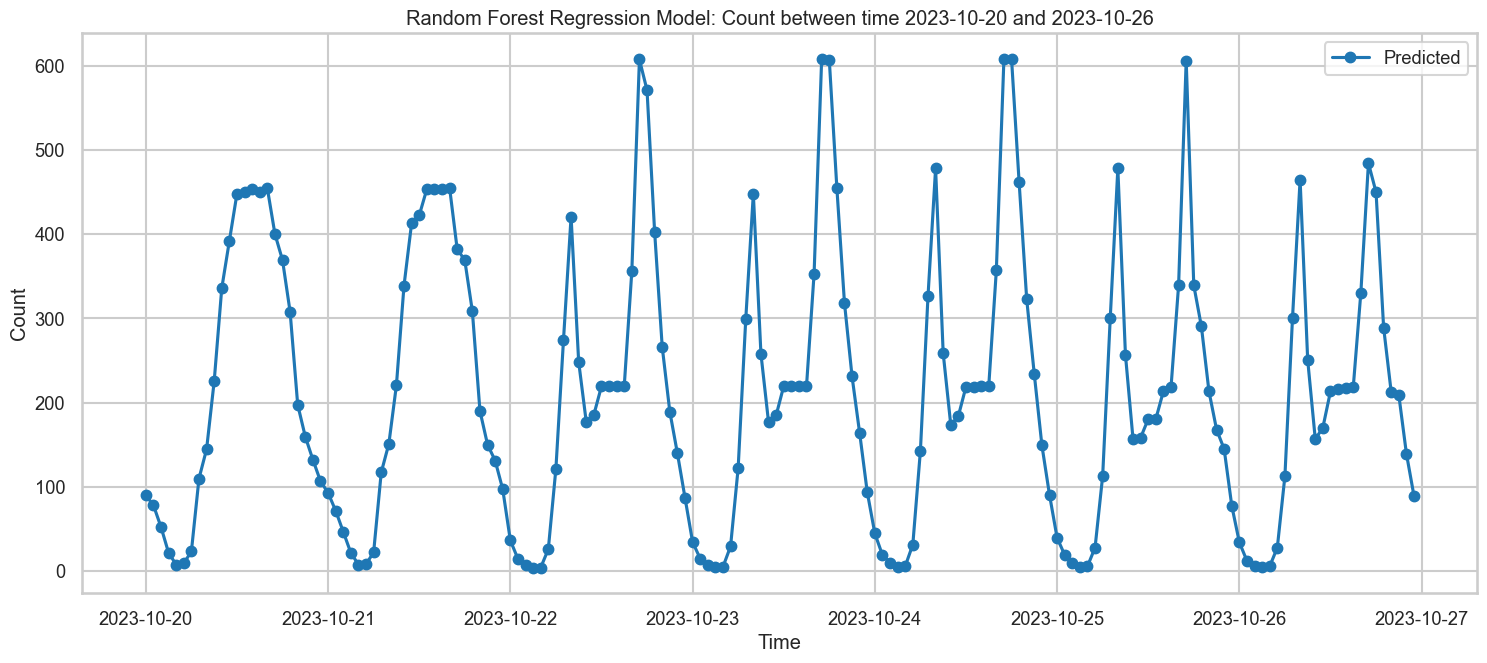

In [117]:
algo = 'Random Forest Regression'
t_from, t_to = '2023-10-20', '2023-10-26'
ytest_predict = pd.Series(ytest_predict, index = testdata.index)
fig = plt.figure(figsize=(18, 16))

axes = fig.add_subplot(2, 1, 1)
axes.plot(ytest_predict[t_from:t_to], label='Predicted', marker='.', markersize=15)
axes.set(xlabel='Time', ylabel='Count', title='{0} Model: Count between time {1} and {2}'.format(algo, t_from, t_to))
axes.legend()

plt.show()

In [118]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the dataset
bike_data = pd.read_csv('C:/Users/Manas/Downloads/Bike-Sharing-Demand-Prediction-master (1)/Bike-Sharing-Demand-Prediction-master/Data/train.csv')  # Replace with actual path

# Define features and target
X = bike_data[['temp', 'atemp', 'humidity', 'windspeed']]  # Example features
y = bike_data['count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Adjust negative predictions to zero for MSLE calculation
y_pred = np.maximum(0, y_pred)

# Calculate evaluation metrics
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))  # Use adjusted predictions for RMSLE
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display the results
print(f"RMSLE: {rmsle}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

RMSLE: 1.398692366238049
R^2: 0.2590206881324614
MAE: 116.60227322822777
RMSE: 156.38879954821178


In [119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_regression

# Load the dataset
bike_data = pd.read_csv('C:/Users/Manas/Downloads/Bike-Sharing-Demand-Prediction-master (1)/Bike-Sharing-Demand-Prediction-master/Data/train.csv')  # Replace with the actual file path

# Define features and target
X = bike_data[['temp', 'atemp', 'humidity', 'windspeed']]  # Use your relevant features
y = bike_data['count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Define base models
base_model_1 = RandomForestRegressor(n_estimators=50, random_state=42)
base_model_2 = GradientBoostingRegressor(n_estimators=50, random_state=42)

# Train base models and generate predictions on the training set
base_model_1.fit(X_train, y_train)
base_model_2.fit(X_train, y_train)

# Predictions on the training data for stacking
train_pred_1 = base_model_1.predict(X_train)
train_pred_2 = base_model_2.predict(X_train)

# Predictions on the test data for final evaluation
test_pred_1 = base_model_1.predict(X_test)
test_pred_2 = base_model_2.predict(X_test)

# Stack the predictions as new features
stacked_train_data = np.column_stack((train_pred_1, train_pred_2))
stacked_test_data = np.column_stack((test_pred_1, test_pred_2))

# Step 2: Train the meta-model (Linear Regression) on stacked predictions
meta_model = LinearRegression()
meta_model.fit(stacked_train_data, y_train)

# Make final predictions on the test set
y_pred = meta_model.predict(stacked_test_data)

# Adjust negative predictions to zero for RMSLE calculation
y_pred = np.maximum(0, y_pred)

# Step 3: Calculate evaluation metrics
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display results
print(f"RMSLE: {rmsle}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

RMSLE: 1.4715203416279488
R^2: 0.02626838604793036
MAE: 130.24346779021693
RMSE: 179.27603557496047


In [120]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
bike_data = pd.read_csv('C:/Users/Manas/Downloads/Bike-Sharing-Demand-Prediction-master (1)/Bike-Sharing-Demand-Prediction-master/Data/train.csv')  # Replace with the actual file path

# Define features and target
X = bike_data[['temp', 'atemp', 'humidity', 'windspeed']]  # Use your relevant features
y = bike_data['count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Define base models
base_model_1 = LinearRegression()
base_model_2 = GradientBoostingRegressor(n_estimators=50, random_state=42)

# Train base models and generate predictions on the training set
base_model_1.fit(X_train, y_train)
base_model_2.fit(X_train, y_train)

# Predictions on the training data for stacking
train_pred_1 = base_model_1.predict(X_train)
train_pred_2 = base_model_2.predict(X_train)

# Predictions on the test data for final evaluation
test_pred_1 = base_model_1.predict(X_test)
test_pred_2 = base_model_2.predict(X_test)

# Stack the predictions as new features
stacked_train_data = np.column_stack((train_pred_1, train_pred_2))
stacked_test_data = np.column_stack((test_pred_1, test_pred_2))

# Step 2: Train the meta-model (Random Forest) on stacked predictions
meta_model = RandomForestRegressor(n_estimators=50, random_state=42)
meta_model.fit(stacked_train_data, y_train)

# Make final predictions on the test set
y_pred = meta_model.predict(stacked_test_data)

# Adjust negative predictions to zero for RMSLE calculation
y_pred = np.maximum(0, y_pred)

# Step 3: Calculate evaluation metrics
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display results
print(f"RMSLE: {rmsle}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


RMSLE: 1.3539456436505757
R^2: 0.106894029954678
MAE: 124.90480340007298
RMSE: 171.6935976499042


In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
bike_data = pd.read_csv('C:/Users/Manas/Downloads/Bike-Sharing-Demand-Prediction-master (1)/Bike-Sharing-Demand-Prediction-master/Data/train.csv')  # Replace with the actual file path

# Define features and target
X = bike_data[['temp', 'atemp', 'humidity', 'windspeed']]  # Use relevant features
y = bike_data['count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Define base models
base_model_1 = LinearRegression()
base_model_2 = RandomForestRegressor(n_estimators=50, random_state=42)

# Train base models and generate predictions on the training set
base_model_1.fit(X_train, y_train)
base_model_2.fit(X_train, y_train)

# Predictions on the training data for stacking
train_pred_1 = base_model_1.predict(X_train)
train_pred_2 = base_model_2.predict(X_train)

# Predictions on the test data for final evaluation
test_pred_1 = base_model_1.predict(X_test)
test_pred_2 = base_model_2.predict(X_test)

# Stack the predictions as new features
stacked_train_data = np.column_stack((train_pred_1, train_pred_2))
stacked_test_data = np.column_stack((test_pred_1, test_pred_2))

# Step 2: Train the meta-model (Gradient Boosting) on stacked predictions
meta_model = GradientBoostingRegressor(n_estimators=50, random_state=42)
meta_model.fit(stacked_train_data, y_train)

# Make final predictions on the test set
y_pred = meta_model.predict(stacked_test_data)

# Adjust negative predictions to zero for RMSLE calculation
y_pred = np.maximum(0, y_pred)

# Step 3: Calculate evaluation metrics
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display results
print(f"RMSLE: {rmsle}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


RMSLE: 1.3599060508018985
R^2: 0.045839057872868016
MAE: 128.2800723090026
RMSE: 177.46528962507878


In [122]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
bike_data = pd.read_csv('C:/Users/Manas/Downloads/Bike-Sharing-Demand-Prediction-master (1)/Bike-Sharing-Demand-Prediction-master/Data/train.csv')  # Replace with the actual file path

# Define features and target
X = bike_data[['temp', 'atemp', 'humidity', 'windspeed']]  # Use relevant features
y = bike_data['count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Adjust negative predictions to zero for RMSLE calculation
y_pred = np.maximum(0, y_pred)

# Calculate evaluation metrics
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display results
print(f"RMSLE: {rmsle}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


RMSLE: 1.3545798453739744
R^2: 0.11989064315605169
MAE: 124.8844895219343
RMSE: 170.43976383334603


In [123]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
bike_data = pd.read_csv('C:/Users/Manas/Downloads/Bike-Sharing-Demand-Prediction-master (1)/Bike-Sharing-Demand-Prediction-master/Data/train.csv')  # Replace with the actual file path

# Define features and target
X = bike_data[['temp', 'atemp', 'humidity', 'windspeed']]  # Use relevant features
y = bike_data['count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Adjust negative predictions to zero for RMSLE calculation
y_pred = np.maximum(0, y_pred)

# Calculate evaluation metrics
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display results
print(f"RMSLE: {rmsle}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


RMSLE: 1.3503547252858883
R^2: 0.3064836040665
MAE: 112.24451695692156
RMSE: 151.2972280047732


In [124]:
pip install shap

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Mean Squared Error: 29017.95


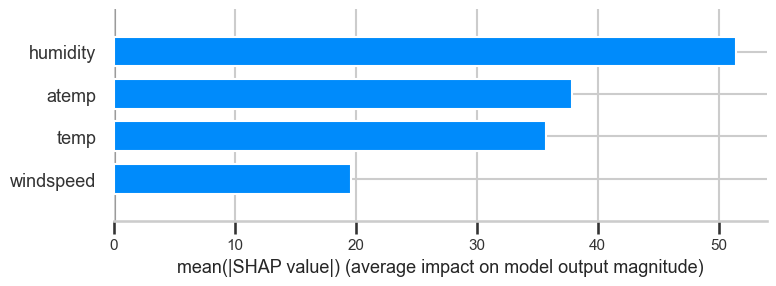

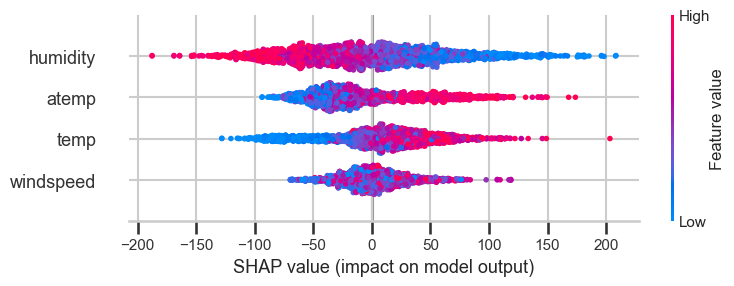

In [125]:
# Import necessary libraries
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import shap

# Train a Random Forest Regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# SHAP explanation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

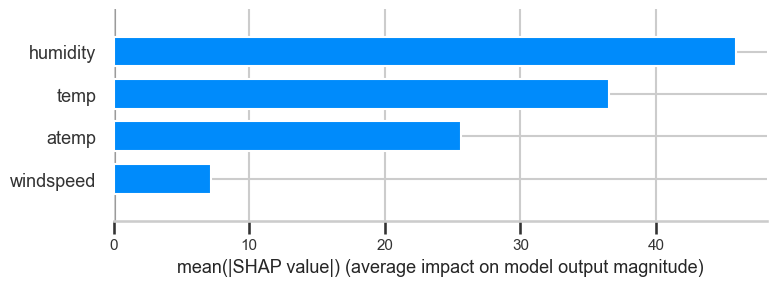

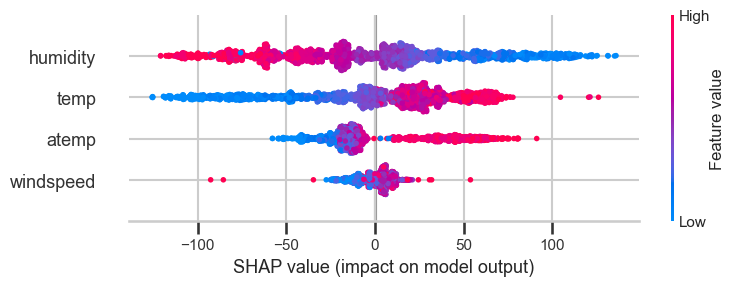

In [126]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
import shap

# Train the GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

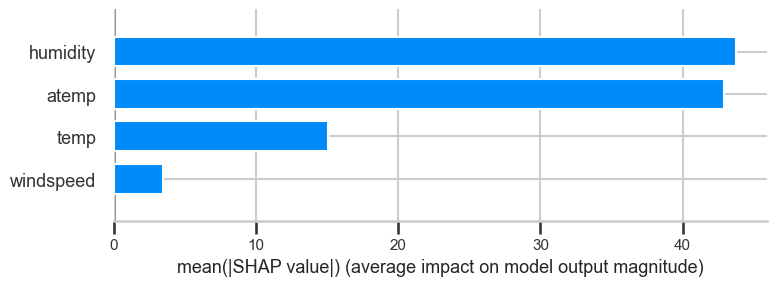

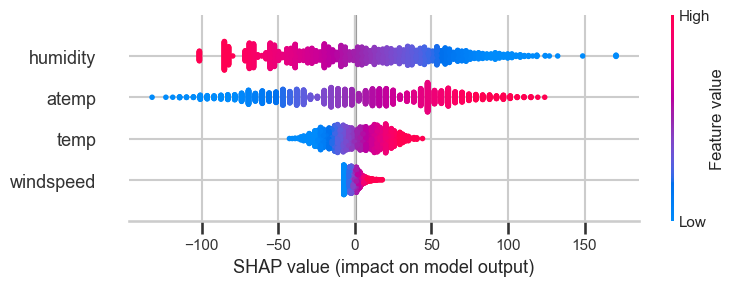

In [127]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import shap

# Train the GradientBoostingRegressor
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# SHAP explanation using LinearExplainer
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

# Summary plots
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)